In [8]:
! jupyter nbconvert --to HTML AnalysePerspectivesV2.ipynb

[NbConvertApp] Converting notebook AnalysePerspectivesV2.ipynb to HTML
[NbConvertApp] WARNING | Alternative text is missing on 29 image(s).
[NbConvertApp] Writing 4535093 bytes to AnalysePerspectivesV2.html


# Eval runs

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import re
import matplotlib.cm as cm
import matplotlib.colors as mcolors

pd.set_option('display.max_columns', None)

In [17]:
def process_and_plot_mrr(file_path, ylim, full_concat_mrr_ref, with_pos=False):
    with open(file_path, 'r') as file:
        data = file.readlines()

    results = []

    # -----------------------------
    # Regex patterns (MRR + GBIG)
    # -----------------------------
    experiment_pattern = re.compile(r"Perform 1:N Evaluation on (\[.*?\])")

    front_pattern = re.compile(
        r"Front RR1: [\d\.]+ MRR: ([\d\.]+) GBIG: ([\d\.]+)"
    )
    concat_pattern = re.compile(
        r"Concat RR1: [\d\.]+ MRR: ([\d\.]+) GBIG: ([\d\.]+)"
    )
    concat_mean_pattern = re.compile(
        r"Concat_Mean RR1: [\d\.]+ MRR: ([\d\.]+) GBIG: ([\d\.]+)"
    )

    current_experiment = None

    for line in data:
        exp_match = experiment_pattern.search(line)
        front_match = front_pattern.search(line)
        concat_match = concat_pattern.search(line)
        concat_mean_match = concat_mean_pattern.search(line)

        if exp_match:
            current_experiment = exp_match.group(1)

        if (
            current_experiment
            and front_match
            and concat_match
            and concat_mean_match
        ):
            front_mrr = float(front_match.group(1))
            front_gbig = float(front_match.group(2))

            concat_mrr = float(concat_match.group(1))
            concat_gbig = float(concat_match.group(2))

            concat_mean_mrr = float(concat_mean_match.group(1))
            concat_mean_gbig = float(concat_mean_match.group(2))

            results.append(
                (
                    current_experiment,
                    front_mrr, front_gbig,
                    concat_mrr, concat_gbig,
                    concat_mean_mrr, concat_mean_gbig
                )
            )
            current_experiment = None

    # -----------------------------
    # Unpack
    # -----------------------------
    experiments = [r[0] for r in results]

    front_mrrs = [r[1] for r in results]
    front_gbigs = [r[2] for r in results]

    concat_mrrs = [r[3] for r in results]
    concat_gbigs = [r[4] for r in results]

    concat_mean_mrrs = [r[5] for r in results]
    concat_mean_gbigs = [r[6] for r in results]

    front_mrr_ref = front_mrrs[0]

    # -----------------------------
    # View-count coloring
    # -----------------------------
    def count_views(coord_str):
        return len(re.findall(r"\d+", coord_str))

    num_views = [count_views(r[0]) for r in results]

    norm = mcolors.Normalize(vmin=min(num_views), vmax=max(num_views))
    cmap = cm.viridis
    colors = [cmap(norm(v)) for v in num_views]

    # -----------------------------
    # Console output
    # -----------------------------
    print(
        "Exp | Front MRR | Front GBIG | Concat MRR | Concat GBIG | "
        "Concat-Mean MRR | Concat-Mean GBIG | Dataset"
    )
    print("-" * 120)

    for i, r in enumerate(results):
        print(
            f"Exp {i:02d} | "
            f"{r[1]:.4f} | {r[2]:.3f} | "
            f"{r[3]:.4f} | {r[4]:.3f} | "
            f"{r[5]:.4f} | {r[6]:.3f} | "
            f"{r[0]}"
        )

    # -----------------------------
    # Bar plot (MRR only, unchanged)
    # -----------------------------
    x = np.arange(len(experiments))
    width = 0.25

    fig, ax = plt.subplots(figsize=(20, 6))

    ax.bar(x - width, front_mrrs, width, label="Front Only MRR")
    ax.bar(x, concat_mrrs, width, label="Concat MRR")
    ax.bar(x + width, concat_mean_mrrs, width, label="Concat Mean MRR")

    ax.axhline(
        y=full_concat_mrr_ref,
        linestyle="--",
        label="FULL CONCAT (MRR)"
    )

    ax.set_ylabel("MRR")
    ax.set_xticks(x)
    ax.set_xticklabels([f"Exp {i}" for i in range(len(experiments))], rotation=90)
    ax.set_ylim(ylim)
    ax.legend()

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Scatter: Concat Mean vs Concat
    # -----------------------------
    fig, ax = plt.subplots(figsize=(15, 15))

    ax.scatter(concat_mean_mrrs, concat_mrrs, alpha=0.8)

    for i in range(len(experiments)):
        ax.annotate(
            f"{i}",
            (concat_mean_mrrs[i], concat_mrrs[i]),
            textcoords="offset points",
            xytext=(6, 6),
            fontsize=9,
            color=colors[i],
        )

    ax.axhline(y=front_mrr_ref, linestyle="--")
    ax.axvline(x=front_mrr_ref, linestyle="--")

    ax.axhline(y=full_concat_mrr_ref, linestyle="--")
    ax.axvline(x=full_concat_mrr_ref, linestyle="--")

    ax.set_xlabel("Concat-Mean MRR")
    ax.set_ylabel("Concat MRR")
    ax.set_xlim(ylim)
    ax.set_ylim(ylim)
    ax.grid(True)

    plt.show()

    # -----------------------------
    # Scatter: Concat-Mean GBIG vs Concat GBIG
    # -----------------------------
    fig, ax = plt.subplots(figsize=(15, 15))

    ax.scatter(concat_mean_gbigs, concat_gbigs, alpha=0.8)

    for i in range(len(experiments)):
        ax.annotate(
            f"{i}",
            (concat_mean_gbigs[i], concat_gbigs[i]),
            textcoords="offset points",
            xytext=(6, 6),
            fontsize=9,
            color=colors[i],
            alpha=0.9
        )

    # Reference lines (Front GBIG)
    front_gbig_ref = front_gbigs[0]
    ax.axhline(y=front_gbig_ref, linestyle="--")
    ax.axvline(x=front_gbig_ref, linestyle="--")

    ax.set_xlabel("Concat-Mean GBIG")
    ax.set_ylabel("Concat GBIG")
    ax.grid(True)

    plt.show()

        # -----------------------------
    # Zoomed Scatter: Upper Right Quadrant (front_gbig_ref)
    # -----------------------------
    fig, ax = plt.subplots(figsize=(15, 15))

    ax.scatter(concat_mean_gbigs, concat_gbigs, alpha=0.8)

    for i in range(len(experiments)):
        ax.annotate(
            f"{i}",
            (concat_mean_gbigs[i], concat_gbigs[i]),
            textcoords="offset points",
            xytext=(6, 6),
            fontsize=9,
            color=colors[i],
            alpha=0.9
        )

    # Reference lines
    front_gbig_ref = front_gbigs[0]
    ax.axhline(y=front_gbig_ref, linestyle="--")
    ax.axvline(x=front_gbig_ref, linestyle="--")

    # ---- ZOOM: upper right quadrant ----
    padding_x = 0.02 * (max(concat_mean_gbigs) - front_gbig_ref)
    padding_y = 0.02 * (max(concat_gbigs) - front_gbig_ref)

    ax.set_xlim(front_gbig_ref, max(concat_mean_gbigs) + padding_x)
    ax.set_ylim(front_gbig_ref, max(concat_gbigs) + padding_y)

    ax.set_xlabel("Concat-Mean GBIG")
    ax.set_ylabel("Concat GBIG")
    ax.grid(True)

    plt.show()



Exp | Front MRR | Front GBIG | Concat MRR | Concat GBIG | Concat-Mean MRR | Concat-Mean GBIG | Dataset
------------------------------------------------------------------------------------------------------------------------
Exp 00 | 99.9770 | 29.046 | 99.9770 | 29.046 | 99.9770 | 29.046 | ['0_0']
Exp 01 | 99.9770 | 29.046 | 99.9890 | 29.780 | 99.9890 | 30.237 | ['-10_0', '-9_0', '-8_0', '-7_0', '-6_0', '-5_0', '-4_0', '-3_0', '-2_0', '-1_0', '0_-10', '0_-9', '0_-8', '0_-7', '0_-6', '0_-5', '0_-4', '0_-3', '0_-2', '0_-1', '0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8', '0_9', '0_10', '1_0', '2_0', '3_0', '4_0', '5_0', '6_0', '7_0', '8_0', '9_0', '10_0']
Exp 02 | 99.9770 | 29.046 | 99.9890 | 29.806 | 99.9890 | 30.239 | ['-10_0', '-8_0', '-6_0', '-4_0', '-2_0', '0_-10', '0_-8', '0_-6', '0_-4', '0_-2', '0_0', '0_2', '0_4', '0_6', '0_8', '0_10', '2_0', '4_0', '6_0', '8_0', '10_0']
Exp 03 | 99.9800 | 28.710 | 99.9890 | 29.766 | 99.9890 | 30.207 | ['-10_0', '-7_0', '-4_0', '-1_

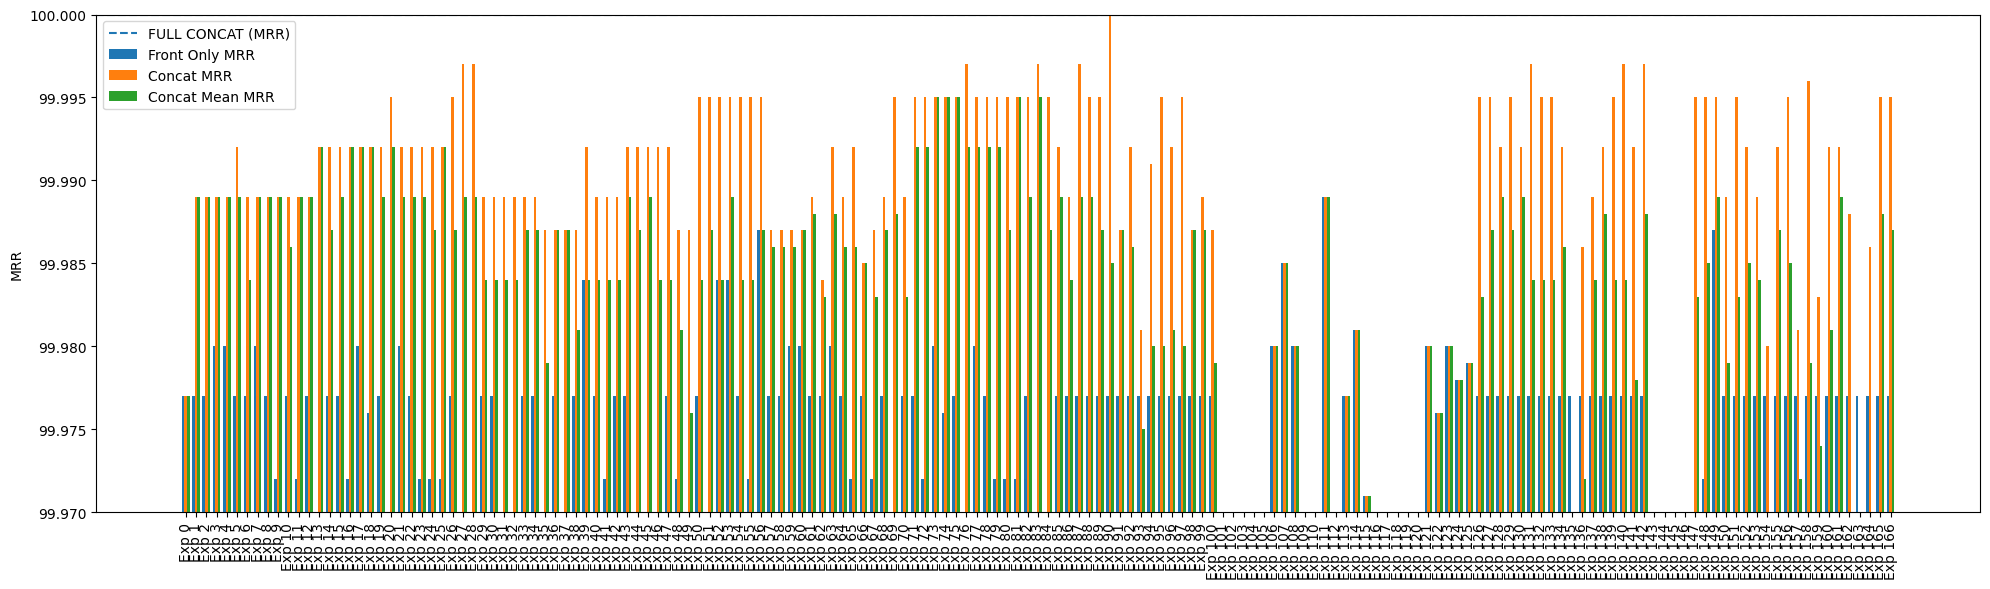

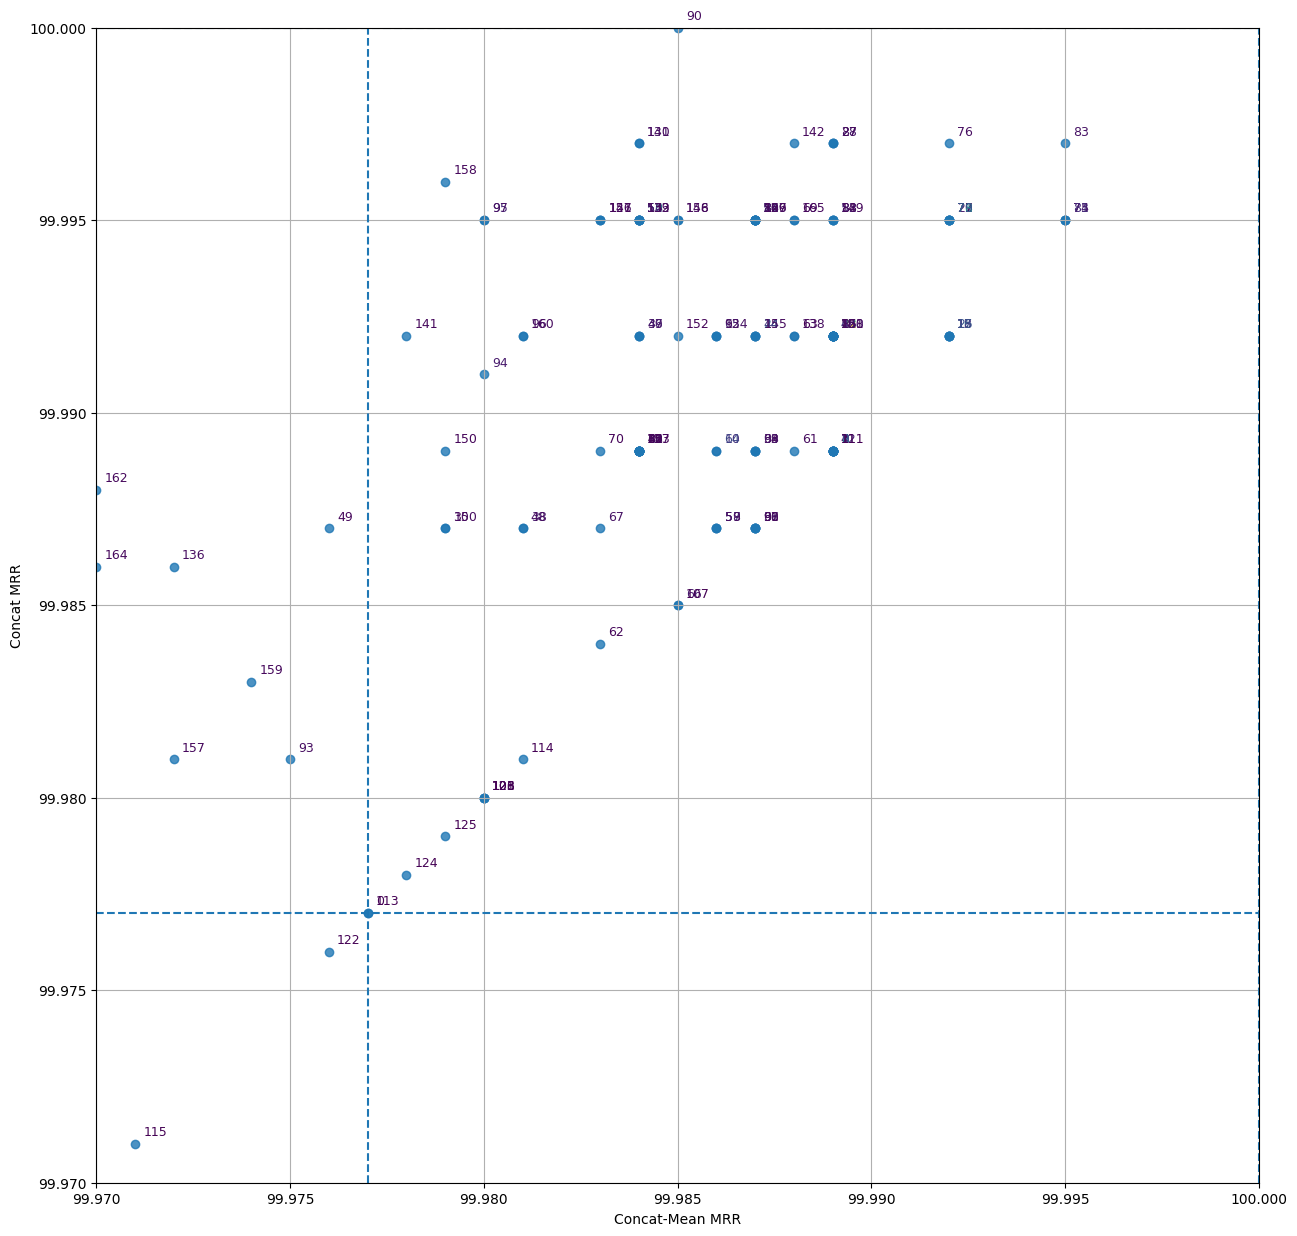

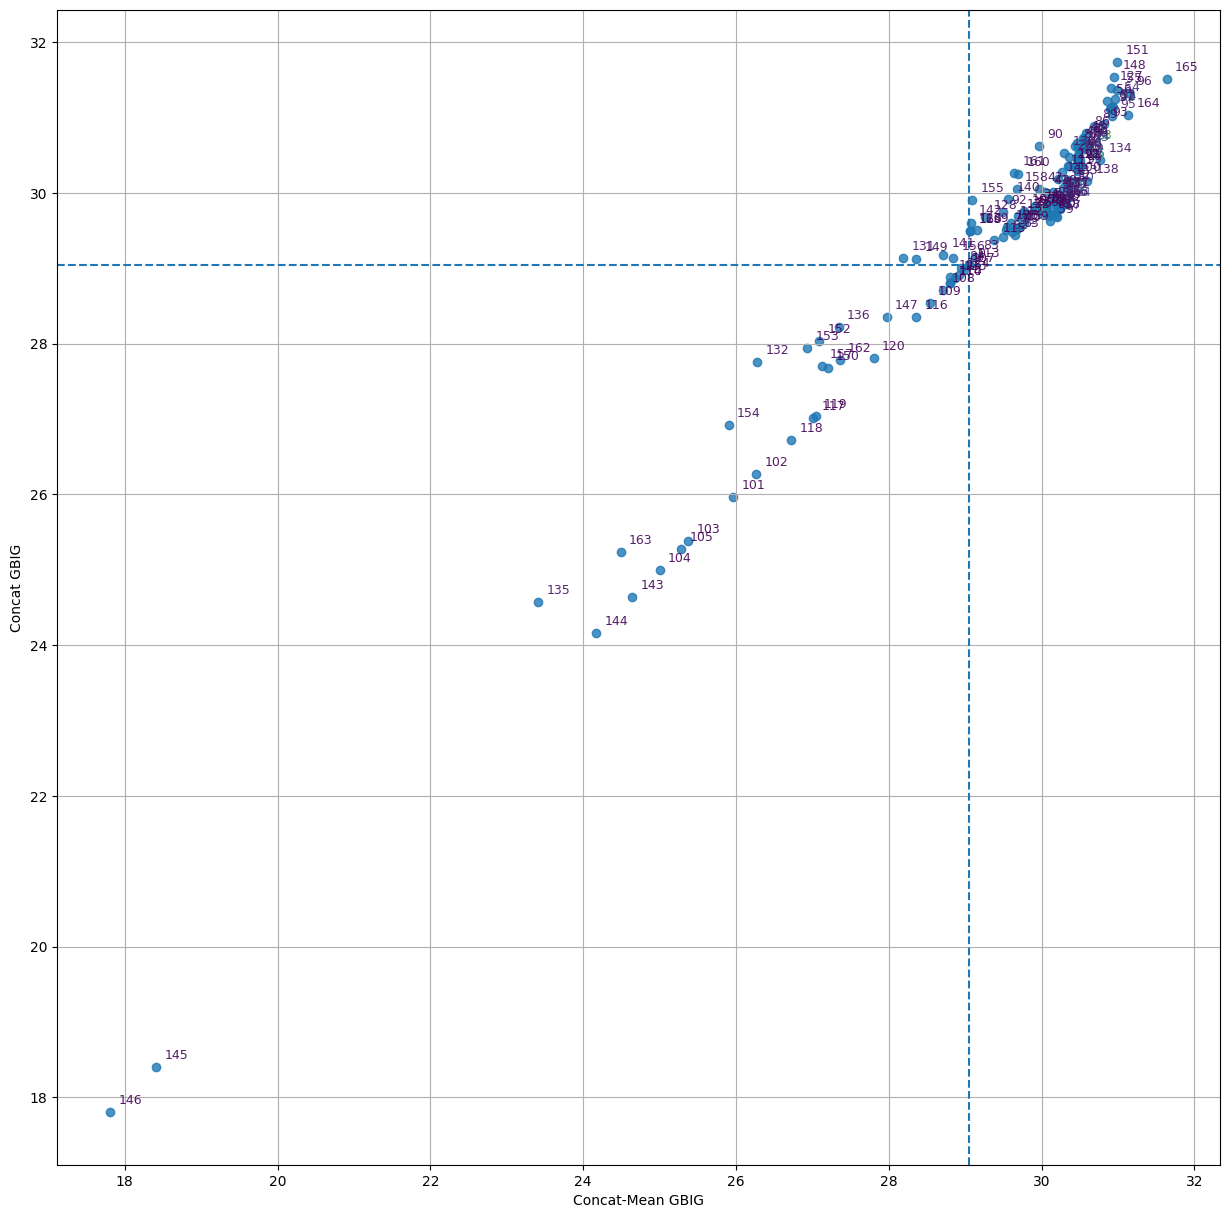

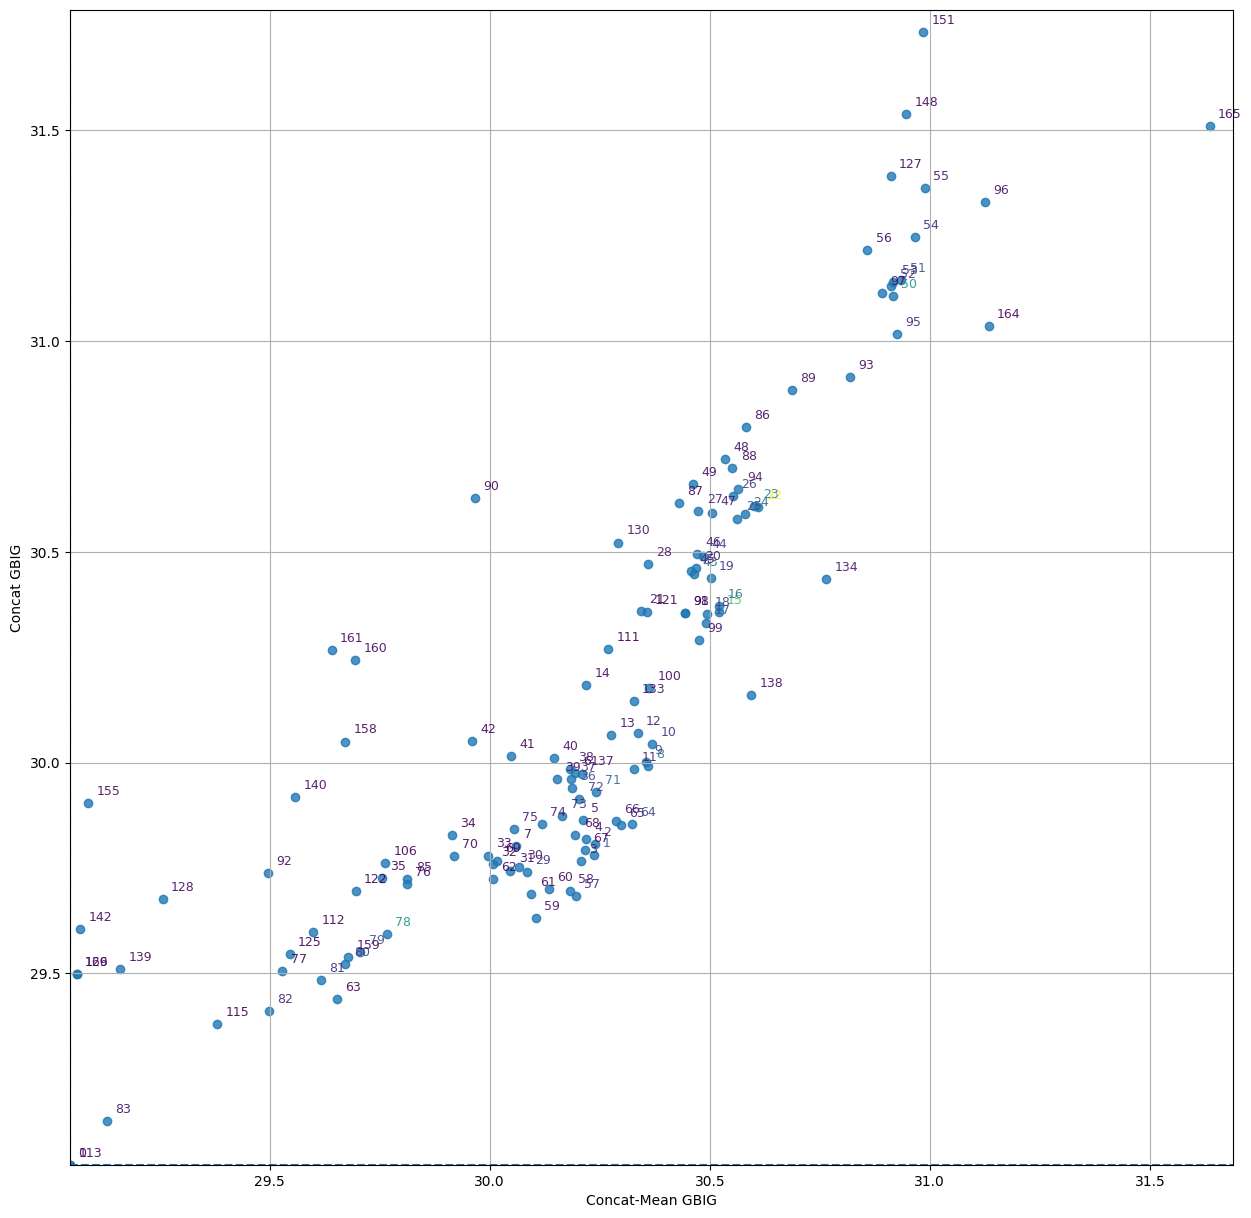

In [18]:
process_and_plot_mrr('mass_eval_late_fusion_glint18_extras2.txt', ylim=(99.97, 100), full_concat_mrr_ref=100)

Exp | Front MRR | Concat MRR | Concat-Mean MRR | Dataset Coords 
------------------------------------------------------------------------------------------
Exp 00 | 99.9840 | 99.9840 | 99.9840 | ['0_0'] | 
Exp 01 | 99.9840 | 99.9950 | 99.9950 | ['-10_0', '-9_0', '-8_0', '-7_0', '-6_0', '-5_0', '-4_0', '-3_0', '-2_0', '-1_0', '0_-10', '0_-9', '0_-8', '0_-7', '0_-6', '0_-5', '0_-4', '0_-3', '0_-2', '0_-1', '0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8', '0_9', '0_10', '1_0', '2_0', '3_0', '4_0', '5_0', '6_0', '7_0', '8_0', '9_0', '10_0'] | 
Exp 02 | 99.9840 | 99.9950 | 99.9950 | ['-10_0', '-8_0', '-6_0', '-4_0', '-2_0', '0_-10', '0_-8', '0_-6', '0_-4', '0_-2', '0_0', '0_2', '0_4', '0_6', '0_8', '0_10', '2_0', '4_0', '6_0', '8_0', '10_0'] | 
Exp 03 | 99.9890 | 99.9970 | 99.9970 | ['-10_0', '-7_0', '-4_0', '-1_0', '0_-10', '0_-7', '0_-4', '0_-1', '0_2', '0_5', '0_8', '2_0', '5_0', '8_0'] | 
Exp 04 | 99.9890 | 99.9950 | 99.9920 | ['-10_0', '-6_0', '-2_0', '0_-10', '0_-6', '0_

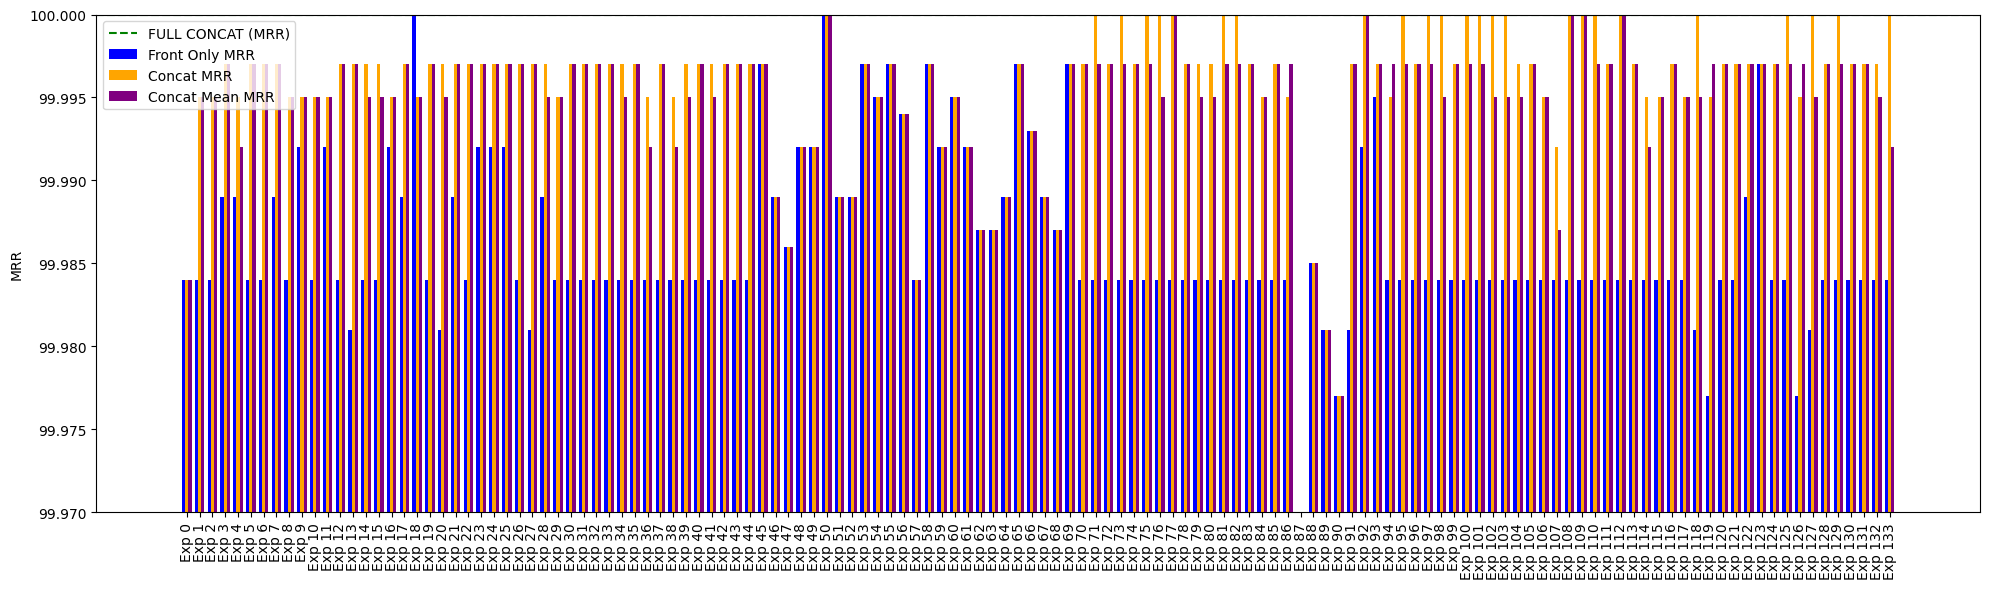

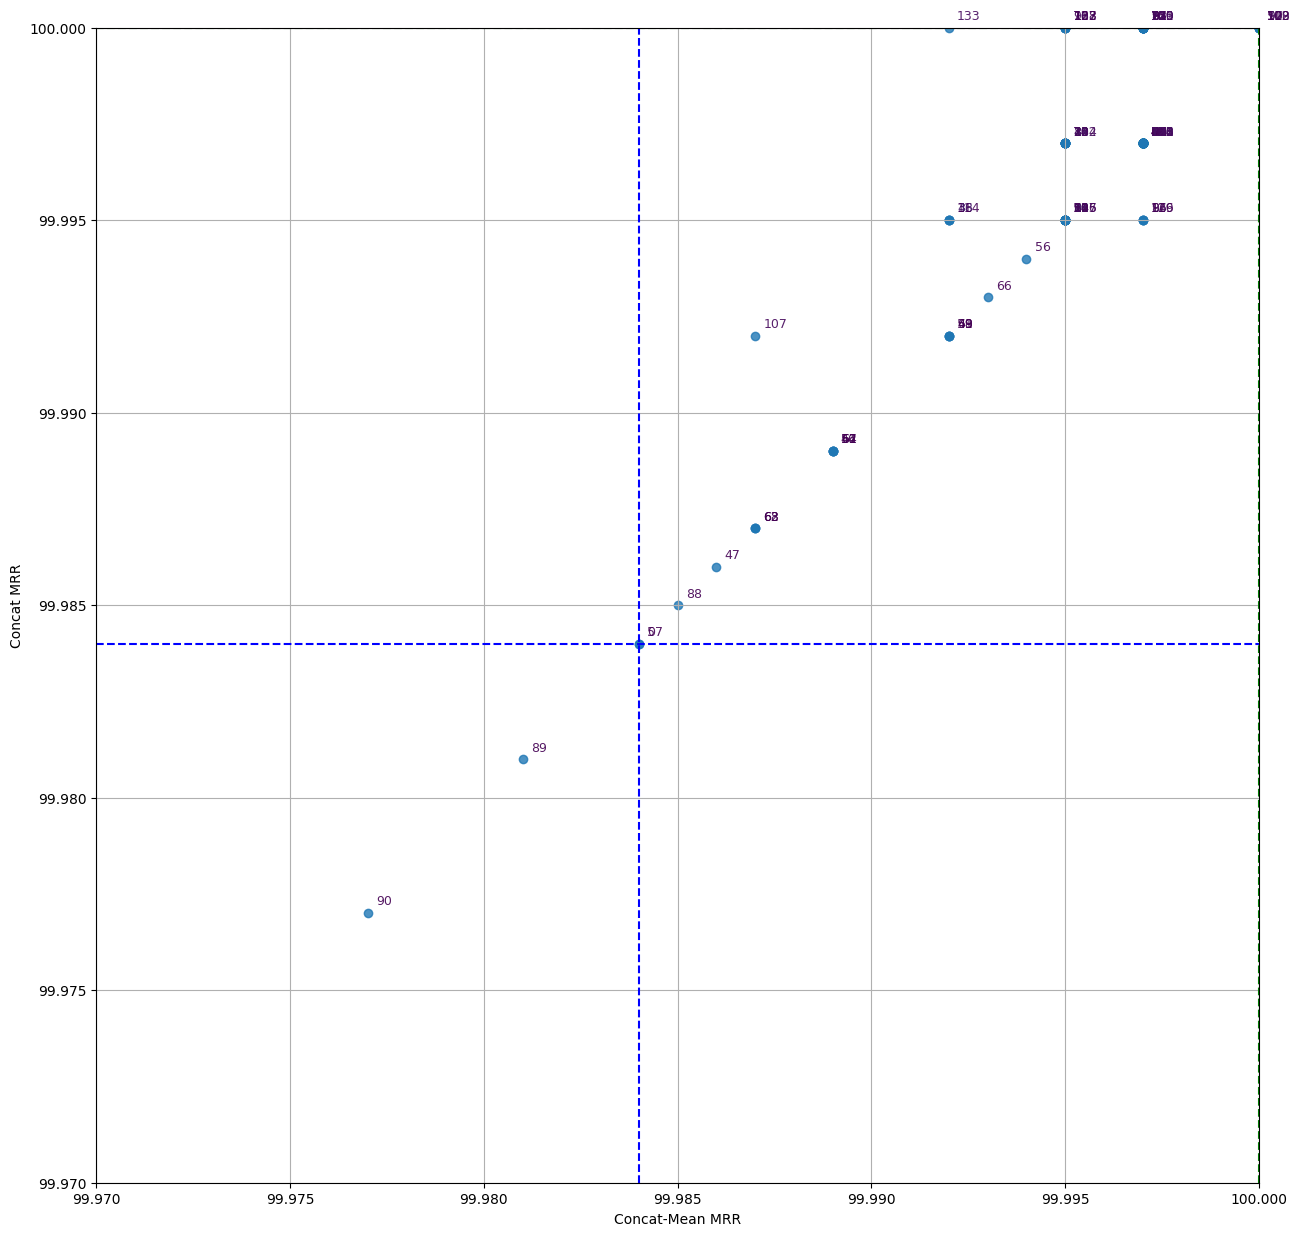

In [6]:
process_and_plot_mrr('mass_eval_late_fusion_glint100_extras.txt', ylim=(99.97, 100), full_concat_mrr_ref=100)

Dataset len: 1450


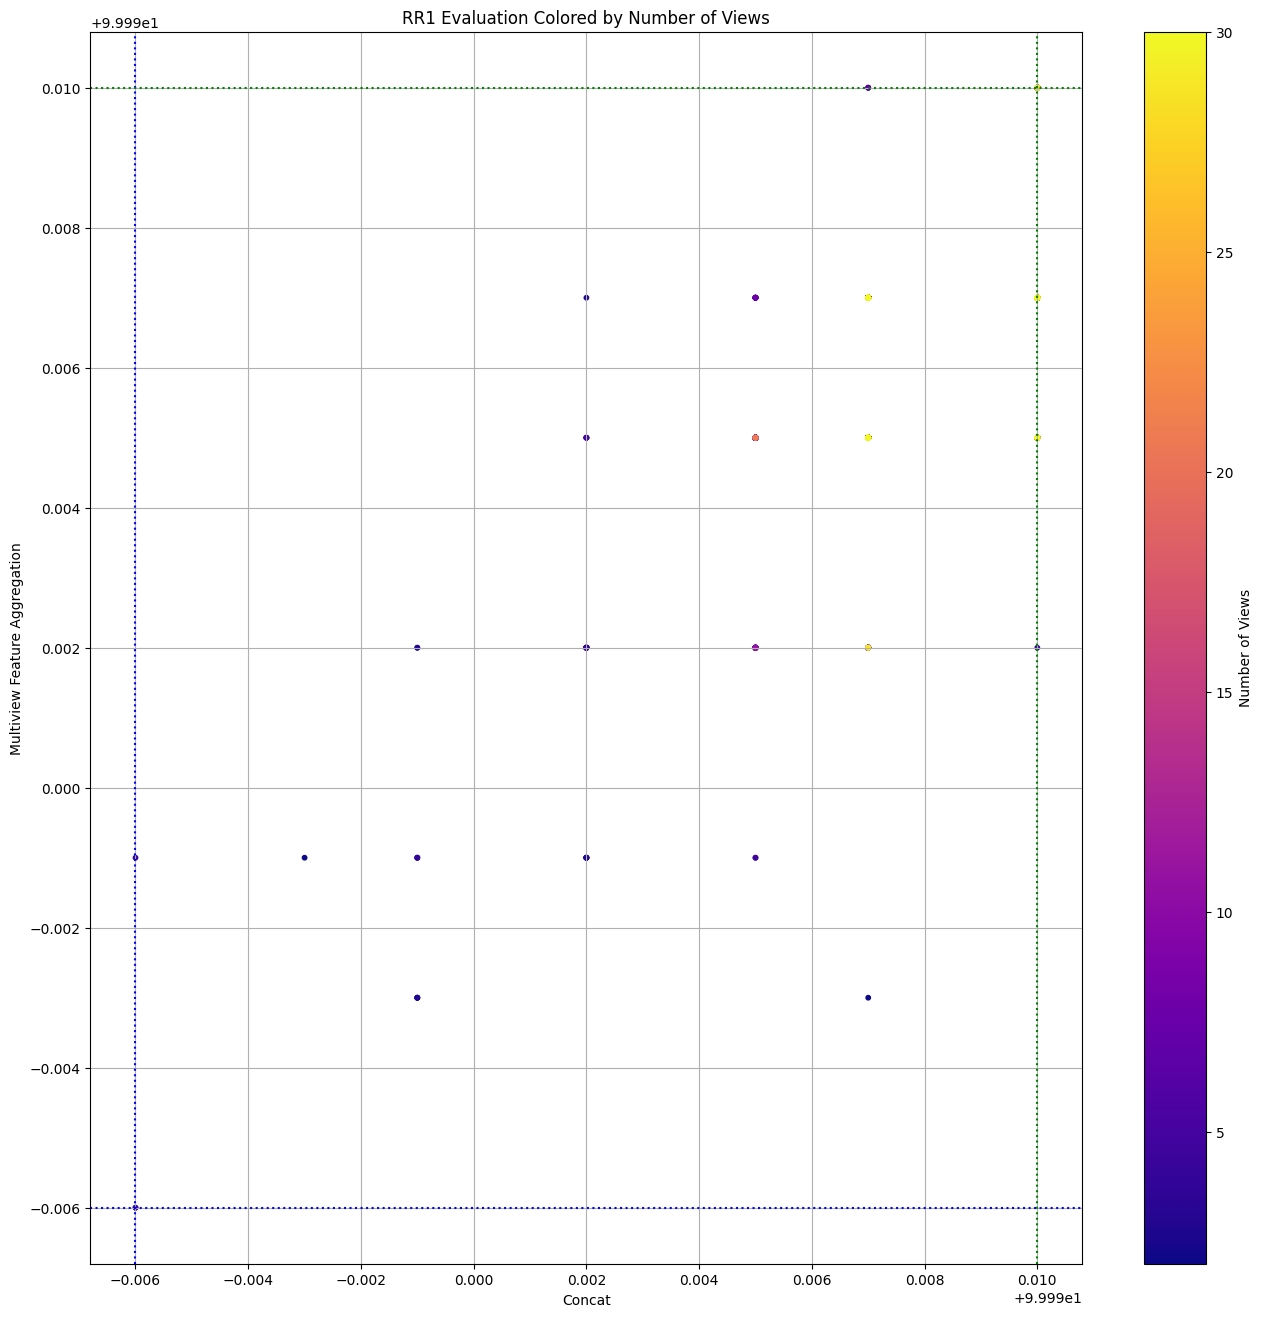

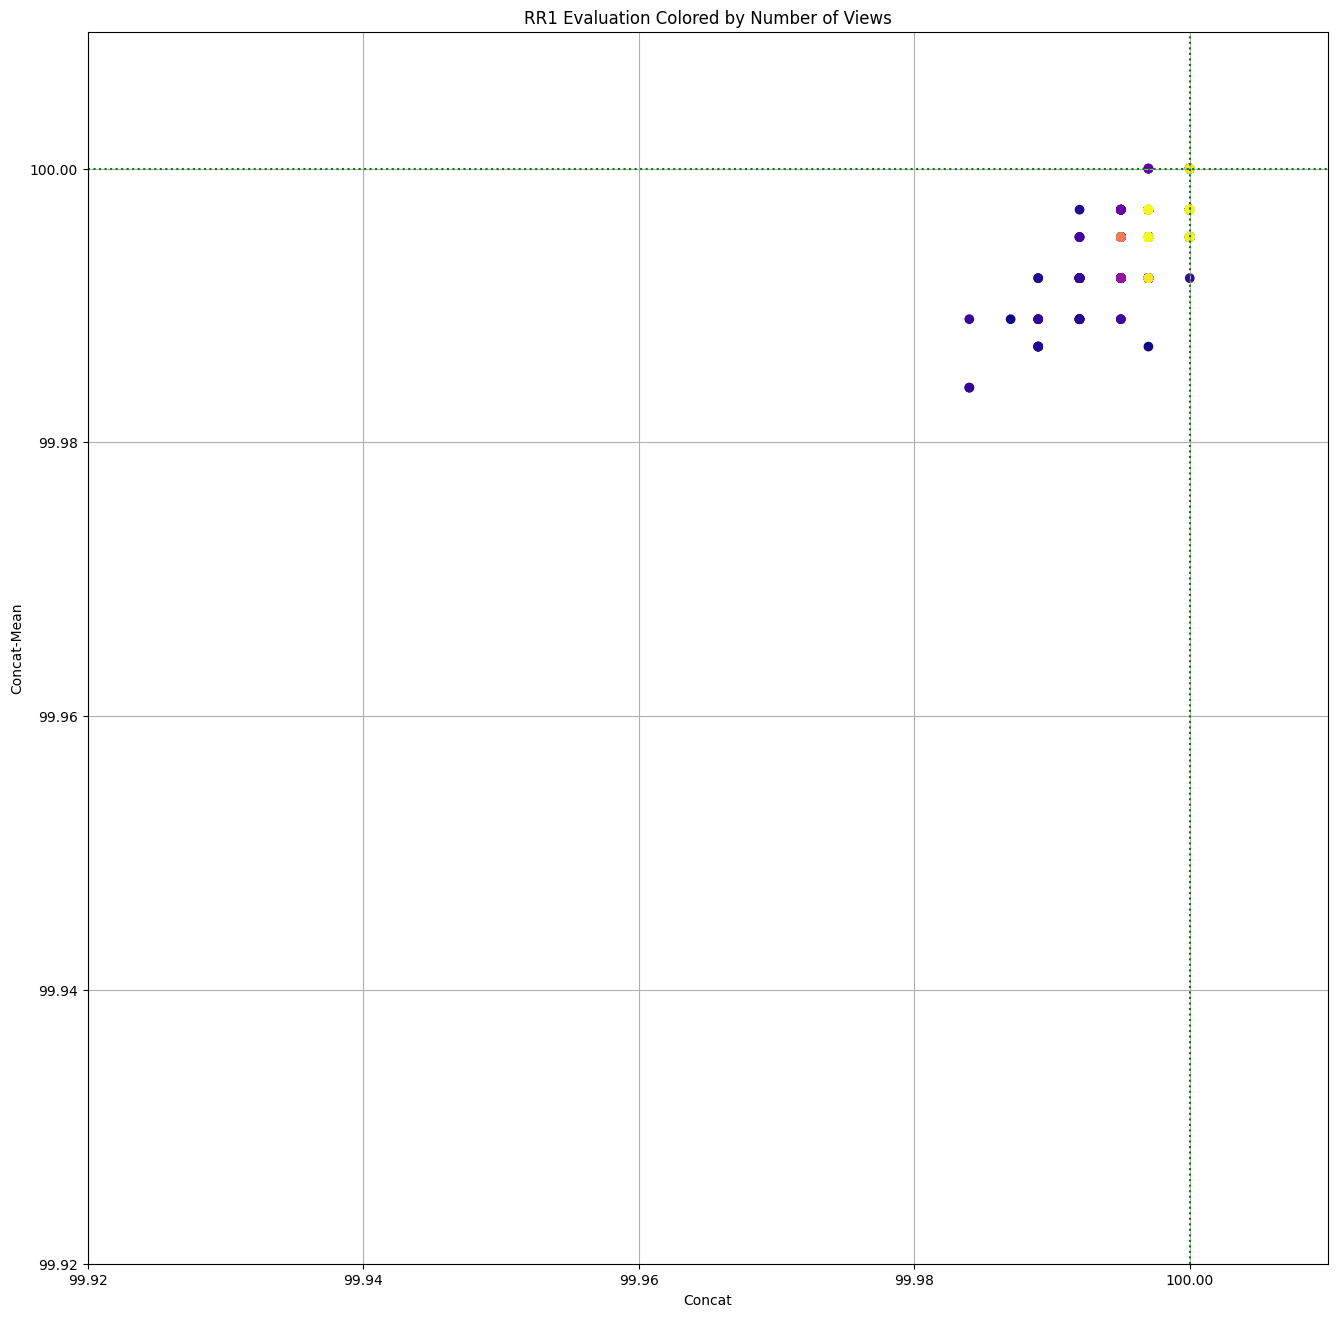

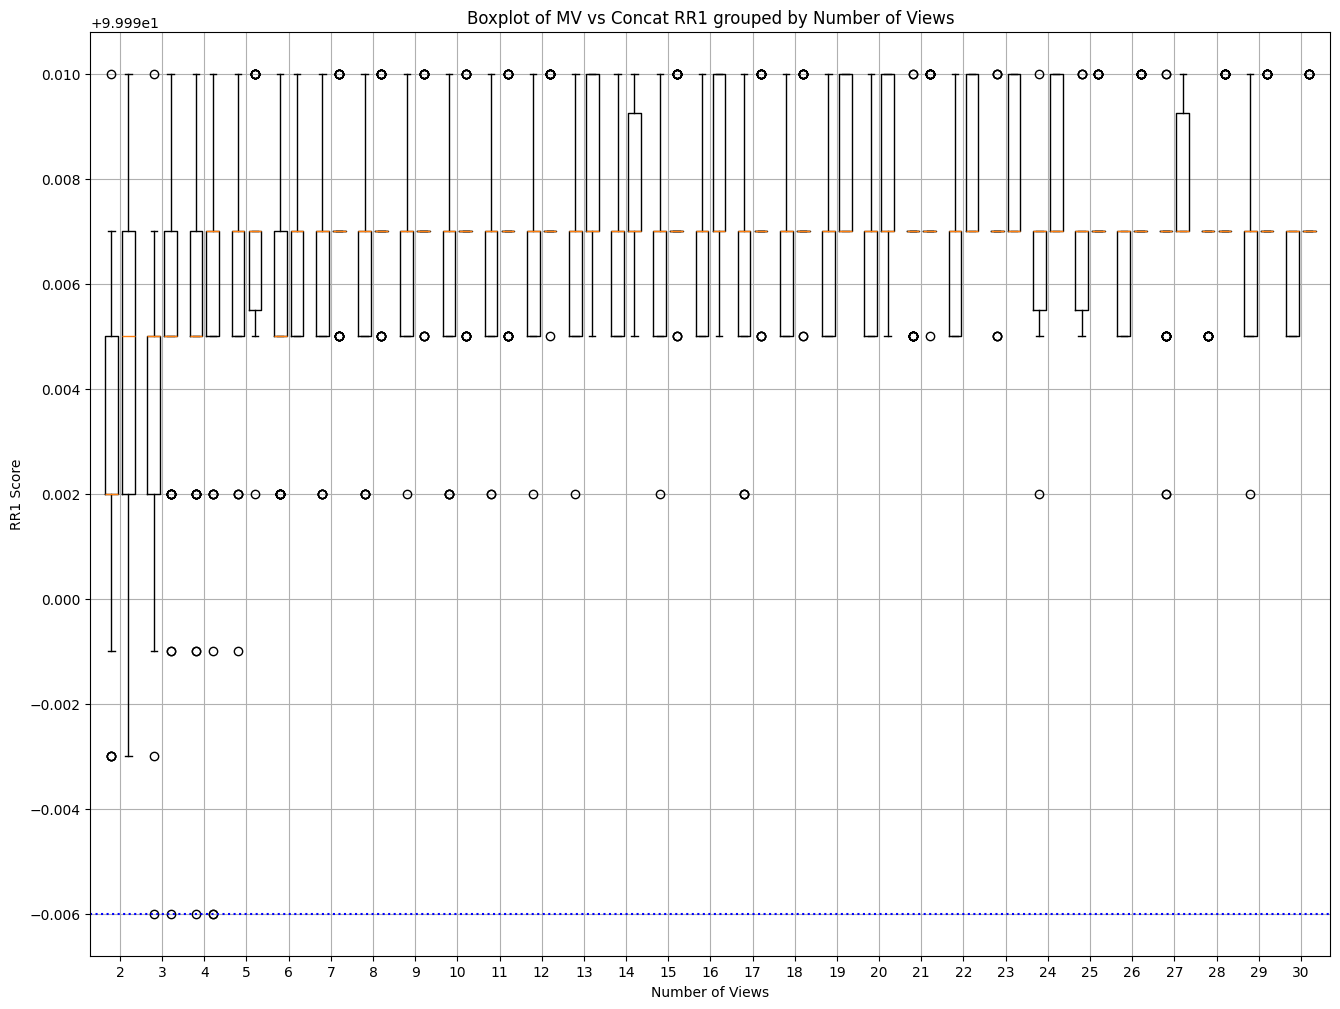

In [7]:
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from collections import defaultdict

ANSI_ESCAPE = re.compile(r"\x1B\[[0-?]*[ -/]*[@-~]")

def process_and_plot2(file_path, xlim, ylim):

    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    results = []

    current_coords = None

    for line in lines:
        line = line.strip()

        # --------- Parse view list ----------
        clean_line = ANSI_ESCAPE.sub("", line)

        if "Perform 1:N Evaluation on" in clean_line:
            match = re.search(r"\[(.*?)\]", clean_line)
            if match:
                current_coords = [
                    c.strip().strip("'")
                    for c in match.group(1).split(",")
                ]
            continue

        # --------- Parse metrics ----------
        if line.startswith("Dataset:") and current_coords is not None:

            def extract_mrr(block_name):
                m = re.search(rf"{block_name} RR1:\s*[\d.]+\s*MRR:\s*([\d.]+)", line)
                return float(m.group(1)) if m else None

            front_mrr  = extract_mrr("Front")
            concat_mrr = extract_mrr("Concat")
            conatmean_mrr     = extract_mrr("Concat_Mean")

            if front_mrr is not None and concat_mrr is not None and conatmean_mrr is not None:
                results.append((current_coords, front_mrr, concat_mrr, conatmean_mrr))
            
            current_coords = None

    print("Dataset len:", len(results))

    coords_strs = [r[0] for r in results]
    lengths = [len(c) for c in coords_strs]
    front_rr1_values = [r[1] for r in results]
    concat_rr1_values = [r[2] for r in results]
    mv_rr1_values = [r[3] for r in results]

    # ---------------- Scatter ----------------
    norm = mcolors.Normalize(vmin=min(lengths), vmax=max(lengths))

    fig, ax = plt.subplots(figsize=(16, 16))
    scatter = ax.scatter(concat_rr1_values, mv_rr1_values, c=lengths,
                         cmap=cm.plasma, norm=norm, s=10)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Number of Views")

    ax.set_xlabel("Concat")
    ax.set_ylabel("Multiview Feature Aggregation")
    ax.set_title("RR1 Evaluation Colored by Number of Views")

    val1 = front_rr1_values[0]
    val2 = max(concat_rr1_values)
    val3 = max(mv_rr1_values)

    ax.axvline(val1, color="b", ls=":")
    ax.axhline(val1, color="b", ls=":")
    ax.axvline(val2, color="g", ls=":")
    ax.axhline(val3, color="g", ls=":")

    plt.grid(True)
    plt.show()

    # ---------------- Zoomed ----------------
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.scatter(concat_rr1_values, mv_rr1_values, c=lengths,
               cmap=cm.plasma, norm=norm)

    ax.axvline(val2, color="g", ls=":")
    ax.axhline(val3, color="g", ls=":")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel("Concat")
    ax.set_ylabel("Concat-Mean")
    ax.set_title("RR1 Evaluation Colored by Number of Views")

    plt.grid(True)
    plt.show()

    # -------- Group by number of views --------
    mv_grouped = defaultdict(list)
    concat_grouped = defaultdict(list)

    for coords, mv_val, concat_val in zip(coords_strs, mv_rr1_values, concat_rr1_values):
        view_count = len(coords)
        mv_grouped[view_count].append(mv_val)
        concat_grouped[view_count].append(concat_val)

    lengths_sorted = sorted(mv_grouped.keys())
    mv_data = [mv_grouped[l] for l in lengths_sorted]
    concat_data = [concat_grouped[l] for l in lengths_sorted]

    x_vals = np.arange(1, len(lengths_sorted) + 1)

    fig, ax = plt.subplots(figsize=(16, 12))
    ax.boxplot(mv_data, positions=x_vals - 0.2, widths=0.3)
    ax.boxplot(concat_data, positions=x_vals + 0.2, widths=0.3)

    ax.axhline(val1, color="b", linestyle=":")
    ax.set_xticks(x_vals)
    ax.set_xticklabels(lengths_sorted)
    ax.set_xlabel("Number of Views")
    ax.set_ylabel("RR1 Score")
    ax.set_title("Boxplot of MV vs Concat RR1 grouped by Number of Views")

    plt.grid(True)
    plt.show()



process_and_plot2('mass_eval_late_fusion_glint100_random.txt', xlim=(99.92, 100.01), ylim=(99.92, 100.01))

Dataset len: 475


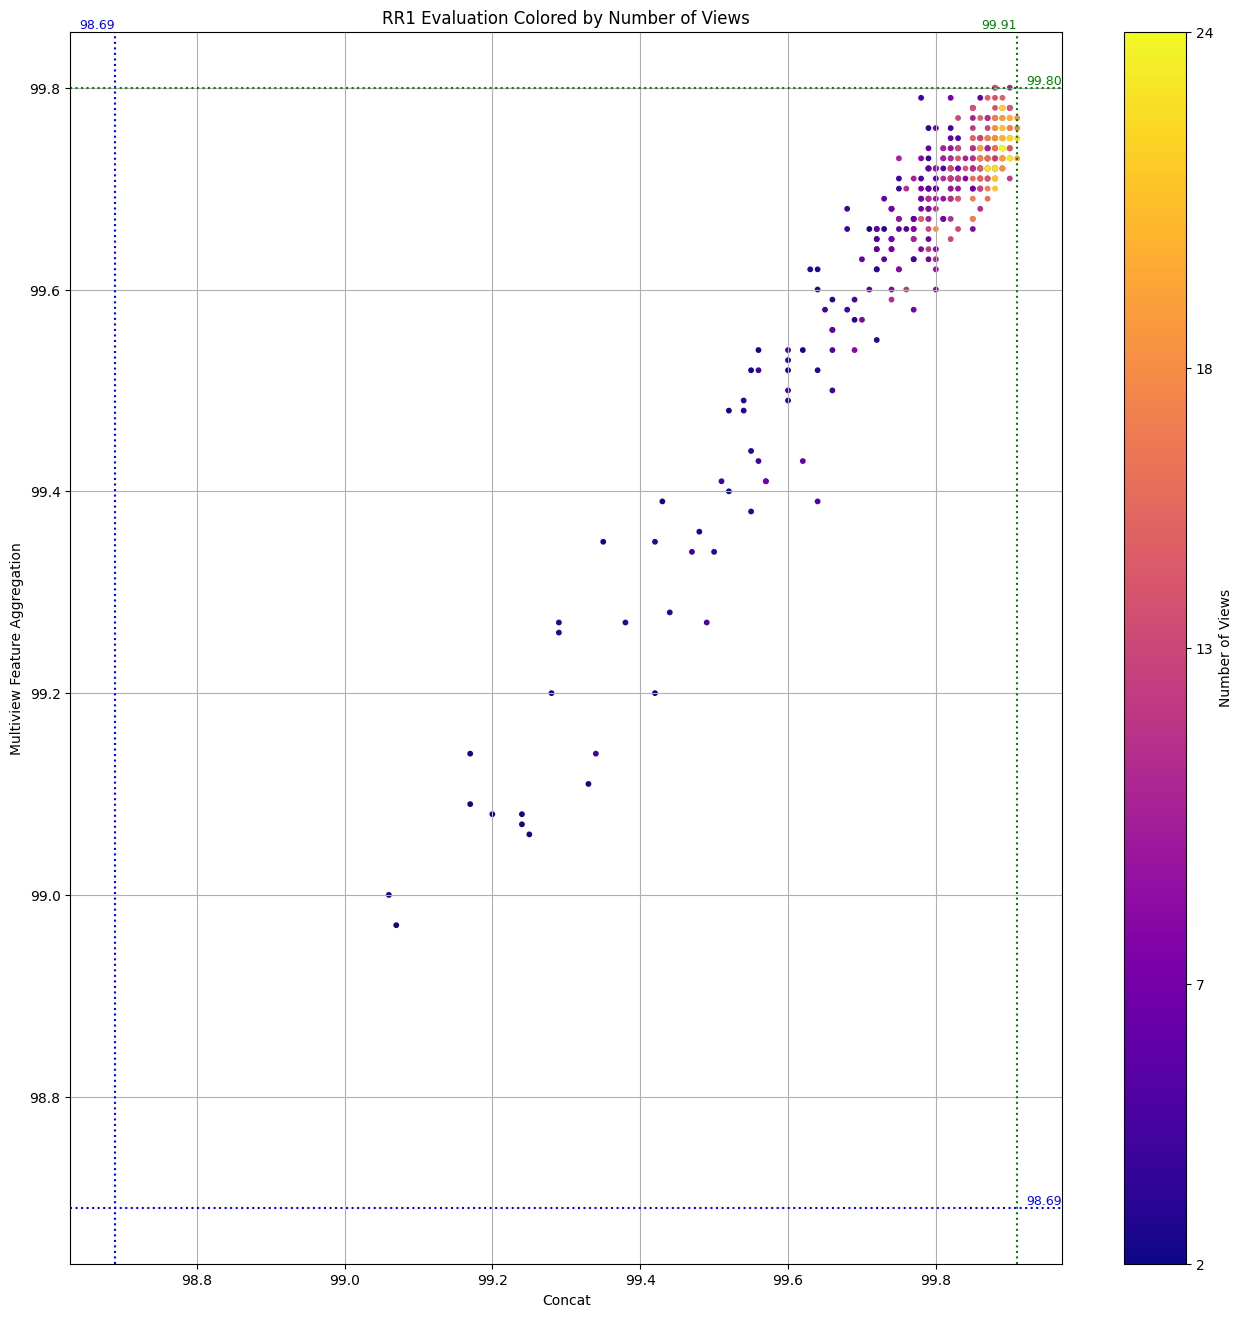

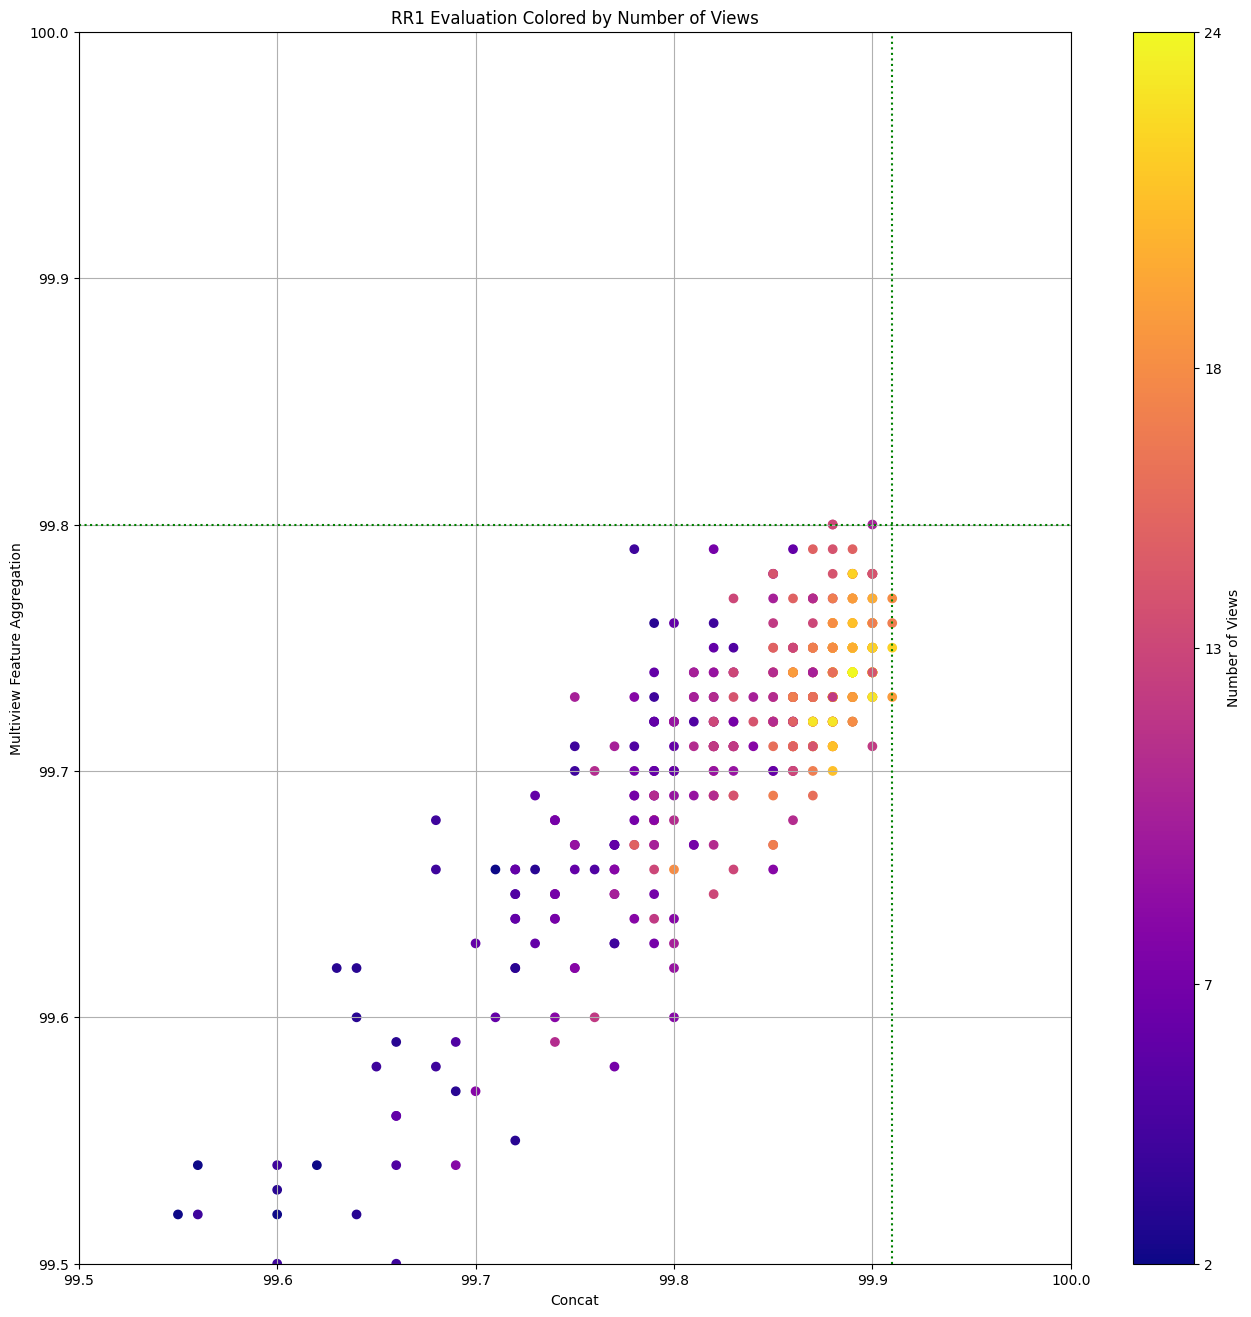

13 20
16 20
9 18
14 22
18 22
3 22
6 23
12 21
15 22
21 18
2 21
5 18
10 22
22 20
24 22
19 18
17 20
20 22
7 21
4 20
8 22
11 21
23 20


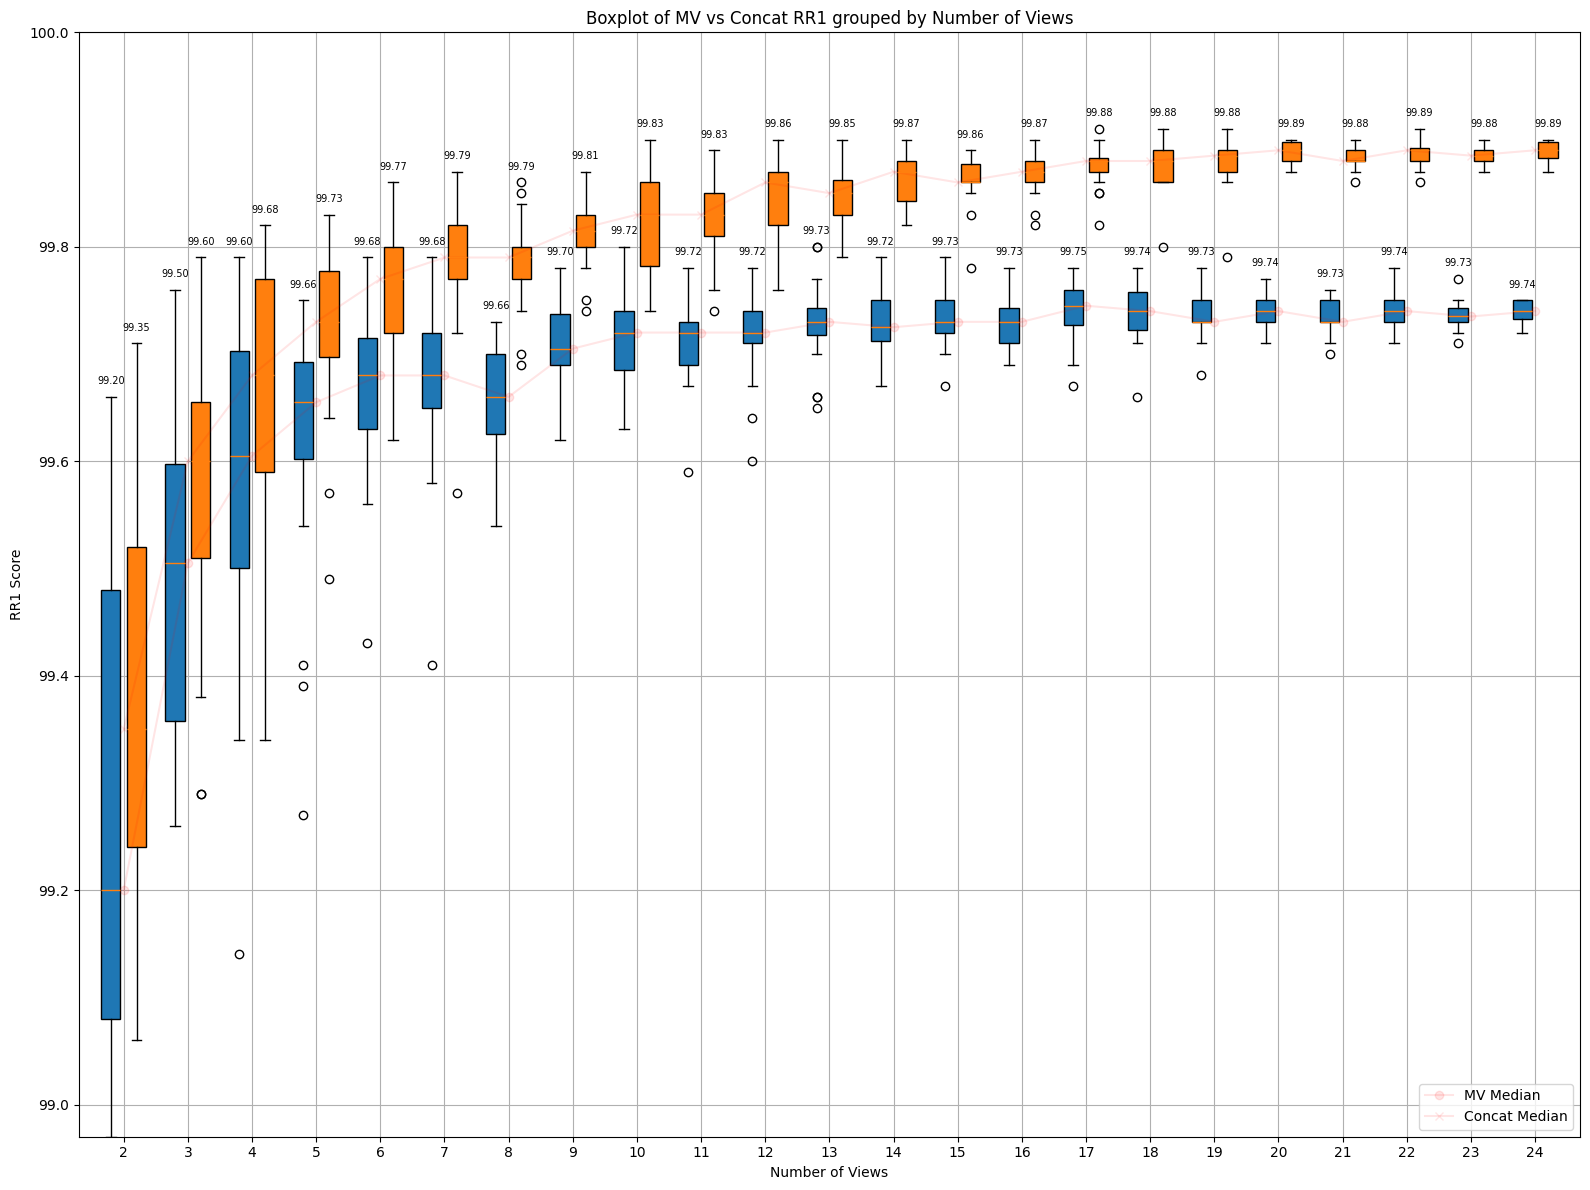

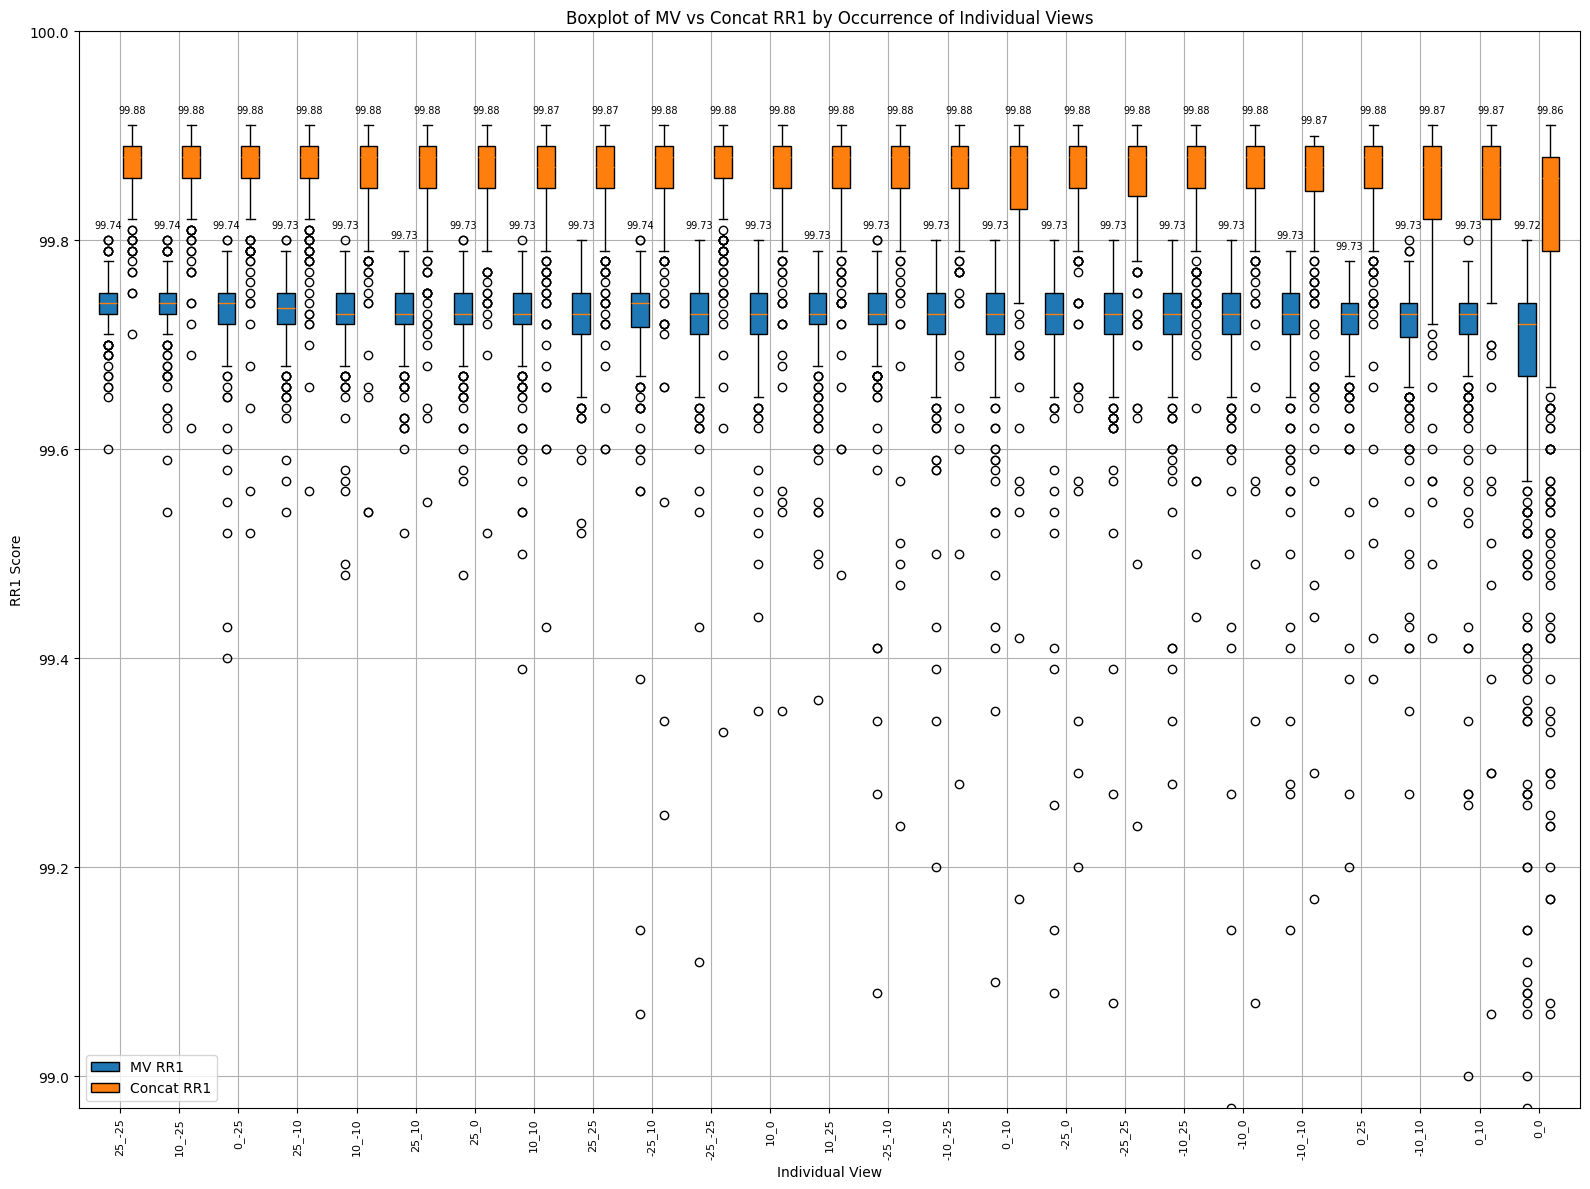

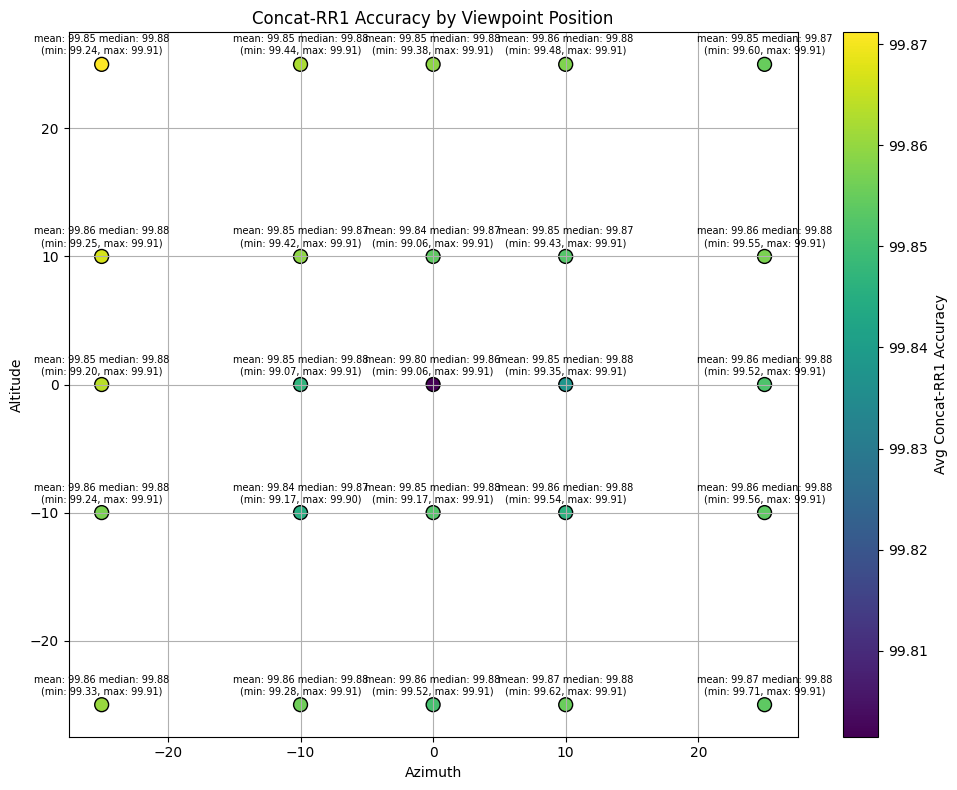

In [18]:
process_and_plot2('perspectives_asia_bff_nobias.txt', xlim=(99.5, 100), ylim=(99.5, 100))

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from collections import defaultdict

extras = [['0_0', '-25_0', '-10_0', '25_0', '10_0'],  # Azimuth axis
            ['0_0', '0_-25', '0_-10', '0_10', '0_25'],  # Alitude axis
            ['0_0', '-25_-25', '-10_-10', '10_10', '25_25'],  # diagonal
            ['0_0', '-25_25', '-10_10', '10_-10', '25_-25'],  # diagonal
            ['0_0', '-25_25', '-10_10', '10_-10', '25_-25', '-25_-25', '-10_-10', '10_10', '25_25'],  # cross
            ['0_0', '-25_-25', '-25_25', '25_-25', '25_25'],  # Only corners
            ['0_0', '-10_-10', '-10_10', '10_-10', '10_10'],  # Only middle row
            ['0_0', '25_-25', '25_-10', '25_0', '25_10', '25_25'],  # Top row
            ['0_0', '10_-25', '10_-10', '10_0', '10_10', '10_25'],  # 2 Top row
            ['0_0', '25_-25', '25_-10', '25_0', '25_10', '25_25', '10_-25', '10_-10', '10_0', '10_10', '10_25'],  # Tops All
            ['0_0', '25_-25', '25_-10', '25_0', '25_10', '25_25', '10_-25', '10_-10', '10_0', '10_10', '10_25', '0_-25', '0_-10', '0_10', '0_25'],  # Tops All + Middle
            ['0_0', '25_-25', '25_25', '10_-10', '10_10', '0_-25', '0_25'],  # Tops Corners + Middle Sides
            ['0_0', '25_-25', '25_25', '10_-10', '10_10', '0_-25', '0_25', '25_0'],  # Tops Corners + Middle and Top Sides
            ]

extras_labels = {
    0: '1 Azimuth axis',
    1: '2 Altitude axis',
    2: '3 Diagonal TL-BR',
    3: '4 Diagonal TR-BL',
    4: '5 Cross pattern',
    5: '6 Only corners',
    6: '7 Only middle row',
    7: '8 Top row',
    8: '9 2nd Top row',
    9: '10 Top All',
    10: '11 Top All + Middle',
    11: '12 Top Corners + Sides',
    12: '13 Top Corners + Sides + Mid'
}

extras_sets = [set(group) for group in extras]
special_views = sorted(set(v for group in extras for v in group))

def is_extra(coords):
    return any(set(coords) == extra for extra in extras_sets)

def clean_ansi(text):
    ansi_codes = ['\x1b[92m', '\x1b[0m', '\x1b[1m', '\x1b[4m']
    for code in ansi_codes:
        text = text.replace(code, '')
    return text

def get_extra_label(coords):
    for i, extra_set in enumerate(extras_sets):
        if set(coords) == extra_set:
            return extras_labels[i]
    return "Unknown Extra Pattern"

def process_and_plot3(file_path, xlim, ylim):

    with open(file_path, 'r') as file:
        data = file.readlines()

    results = []
    for line in data:
        if "bff_crop_ 0_0 : C1033 E1033 Q18734 ; Evaluation:" in line:
            continue
        line = clean_ansi(line).strip()
        if "Evaluation: Front-RR1:" in line:
            line = line.strip()
            dataset_part, eval_part = line.split(";")

            # Parse crop coordinates
            dataset_name, *coords_strs = dataset_part.split(":")[0].strip().split()

            parts = eval_part.split()
            front_rr1 = float(parts[2])
            concat_rr1 = float(parts[6])
            concatpca_rr1 = float(parts[10])
            mv_rr1 = float(parts[14])

            results.append((coords_strs , front_rr1, concat_rr1, concatpca_rr1, mv_rr1))

    print(f"Dataset len:", len(results))

    coords_strs = [r[0] for r in results]
    front_rr1_values = [r[1] for r in results]
    concat_rr1_values = [r[2] for r in results]
    concatpca_rr1_values = [r[3] for r in results]
    mv_rr1_values = [r[4] for r in results]


    print("---- Extras Only ----")
    for coords, front_rr1, concat_rr1, concatpca_rr1, mv_rr1 in results:
        if is_extra(coords):
            label = get_extra_label(coords)
            print(f"{label} | Views: {coords}")
            print(f"  Front RR1: {front_rr1:.2f}")
            print(f"  Concat RR1: {concat_rr1:.2f}")
            print(f"  ConcatPCA RR1: {concatpca_rr1:.2f}")
            print(f"  MV RR1: {mv_rr1:.2f}")
            print()

    # ----------------Scatter ---------------
    lengths = [len(c) for c in coords_strs]
    min_len, max_len = min(lengths), max(lengths)
    norm = mcolors.Normalize(vmin=min_len, vmax=max_len)
    cmap = cm.plasma

    fig, ax = plt.subplots(figsize=(16, 16))
    #scatter = ax.scatter(concat_rr1_values, mv_rr1_values, c=lengths, cmap=cmap, norm=norm, s=10)
    colors = [lengths[i] for i in range(len(coords_strs))]
    is_extras = [is_extra(coords_strs[i]) for i in range(len(coords_strs))]

    scatter = ax.scatter(
        [concat_rr1_values[i] for i in range(len(coords_strs)) if not is_extras[i]],
        [mv_rr1_values[i] for i in range(len(coords_strs)) if not is_extras[i]],
        c=[colors[i] for i in range(len(coords_strs)) if not is_extras[i]],
        cmap=cmap, norm=norm, s=10, label="Regular Samples"
    )
    scatter_extras = ax.scatter(
        [concat_rr1_values[i] for i in range(len(coords_strs)) if is_extras[i]],
        [mv_rr1_values[i] for i in range(len(coords_strs)) if is_extras[i]],
        c=[colors[i] for i in range(len(coords_strs)) if is_extras[i]],
        edgecolors='black', marker='*', s=100, label="Extras"
    )

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Number of Views')
    tick_values = np.linspace(min_len, max_len, num=5, dtype=int)
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels([str(v) for v in tick_values])
    #for i, txt in enumerate(coords_strs):
    #    ax.annotate(len(txt), (concat_rr1_values[i]+1.0, mv_rr1_values[i]-0.005), fontsize=8, ha='right')
    ax.set_xlabel('Concat')
    val1 = front_rr1_values[0]
    val2 = max(concat_rr1_values)
    val3 = max(mv_rr1_values)
    ax.axvline(val1, color='b', ls=':')
    ax.axhline(val1, color='b', ls=':')
    ax.text(val1, ax.get_ylim()[1], f'{val1:.2f}', color='b', va='bottom', ha='right', fontsize=9)
    ax.text(ax.get_xlim()[1], val1, f'{val1:.2f}', color='b', va='bottom', ha='right', fontsize=9)
    ax.axvline(val2, color='g', ls=':')
    ax.axhline(val3, color='g', ls=':')
    ax.text(val2, ax.get_ylim()[1], f'{val2:.2f}', color='g', va='bottom', ha='right', fontsize=9)
    ax.text(ax.get_xlim()[1], val3, f'{val3:.2f}', color='g', va='bottom', ha='right', fontsize=9)
    ax.set_ylabel('Multiview Feature Aggregation')
    ax.set_title('RR1 Evaluation Colored by Number of Views')
    plt.grid(True)
    plt.show()

    # ------------- Zoomed in scatter ------------------
    lengths = [len(c) for c in coords_strs]
    min_len, max_len = min(lengths), max(lengths)
    norm = mcolors.Normalize(vmin=min_len, vmax=max_len)
    cmap = cm.plasma

    fig, ax = plt.subplots(figsize=(16, 16))
    scatter = ax.scatter(
        [concat_rr1_values[i] for i in range(len(coords_strs)) if not is_extras[i]],
        [mv_rr1_values[i] for i in range(len(coords_strs)) if not is_extras[i]],
        c=[colors[i] for i in range(len(coords_strs)) if not is_extras[i]],
        cmap=cmap, norm=norm, s=50, label="Regular Samples"
    )
    scatter_extras = ax.scatter(
        [concat_rr1_values[i] for i in range(len(coords_strs)) if is_extras[i]],
        [mv_rr1_values[i] for i in range(len(coords_strs)) if is_extras[i]],
        c=[colors[i] for i in range(len(coords_strs)) if is_extras[i]],
        edgecolors='black', marker='*', s=150, label="Extras"
    )

    
    for i, extra_group in enumerate(extras_sets):
        label = extras_labels.get(i, f"Extras {i}")
        for j, coords in enumerate(coords_strs):
            if set(coords) == extra_group:
                x = concat_rr1_values[j]
                y = mv_rr1_values[j]
                ax.annotate(label, (x, y), fontsize=8, ha='left', va='bottom', color='black',
                            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
                break
            
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Number of Views')
    tick_values = np.linspace(min_len, max_len, num=5, dtype=int)
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels([str(v) for v in tick_values])
    #for i, txt in enumerate(coords_strs):
    #    ax.annotate(len(txt), (concat_rr1_values[i]+1.0, mv_rr1_values[i]-0.005), fontsize=8, ha='right')
    ax.axvline(val2, color='g', ls=':')
    ax.axhline(val3, color='g', ls=':')
    ax.set_xlabel('Concat')
    ax.set_ylabel('Multiview Feature Aggregation')
    ax.set_title('RR1 Evaluation Colored by Number of Views')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.grid(True)
    plt.show()


    # --- Group values by number of views ---
    mv_grouped = defaultdict(list)
    concat_grouped = defaultdict(list)
    concatpca_grouped = defaultdict(list)
    for coords, mv_val, concat_val, concatpca_val in zip(coords_strs, mv_rr1_values, concat_rr1_values, concatpca_rr1_values):
        view_count = len(coords)
        mv_grouped[view_count].append(mv_val)
        concat_grouped[view_count].append(concat_val)
        concatpca_grouped[view_count].append(concatpca_val)

    for k,v in concat_grouped.items():
        print(k, len(v))

    lengths_sorted = sorted(set(mv_grouped.keys()).union(concat_grouped.keys()))
    mv_data = [mv_grouped[l] for l in lengths_sorted]
    concat_data = [concat_grouped[l] for l in lengths_sorted]
    concatpca_data = [concatpca_grouped[l] for l in lengths_sorted]
    mins_mv = [np.min(mv_grouped[l]) for l in lengths_sorted]
    meds_mv = [np.median(mv_grouped[l]) for l in lengths_sorted]
    maxs_mv = [np.max(mv_grouped[l]) for l in lengths_sorted]
    mins_concat = [np.min(concat_grouped[l]) for l in lengths_sorted]
    meds_concat = [np.median(concat_grouped[l]) for l in lengths_sorted]
    maxs_concat = [np.max(concat_grouped[l]) for l in lengths_sorted]
    mins_concatpca = [np.min(concatpca_grouped[l]) for l in lengths_sorted]
    meds_concatpca = [np.median(concatpca_grouped[l]) for l in lengths_sorted]
    maxs_concatpca = [np.max(concatpca_grouped[l]) for l in lengths_sorted]
    x_vals = np.arange(1, len(lengths_sorted) + 1)
    positions_mv = x_vals - 0.25
    positions_concat = x_vals + 0.25
    positions_concatpca = x_vals

    fig, ax = plt.subplots(figsize=(16, 12))

    bp_mv = ax.boxplot(mv_data, positions=positions_mv, widths=0.25, patch_artist=True)
    bp_concat = ax.boxplot(concat_data, positions=positions_concat, widths=0.25, patch_artist=True)
    bp_concatpca = ax.boxplot(concatpca_data, positions=positions_concatpca, widths=0.25, patch_artist=True)

    for patch in bp_mv['boxes']:
        patch.set_facecolor('#1f77b4')  # blue
    for patch in bp_concat['boxes']:
        patch.set_facecolor('#ff7f0e')  # orange
    for patch in bp_concatpca['boxes']:
        patch.set_facecolor('#2ca02c')  # orange

    for i in range(len(lengths_sorted)):
        ax.text(positions_mv[i], maxs_mv[i] + 0.01, f'{meds_mv[i]:.2f}', ha='center', va='bottom', fontsize=7, color='black')
        ax.text(positions_concat[i], maxs_concat[i] + 0.01, f'{meds_concat[i]:.2f}', ha='center', va='bottom', fontsize=7, color='black')
        ax.text(positions_concatpca[i], maxs_concatpca[i] + 0.01, f'{meds_concatpca[i]:.2f}', ha='center', va='bottom', fontsize=7, color='black')

    ax.axhline(val1, color='b', linestyle=':')

    #ax.plot(x_vals, mins_mv, label='MV Min', color='blue', linestyle='--', marker='o', alpha=0.1)
    #ax.plot(x_vals, meds_mv, label='MV Median', color='red', linestyle='-', marker='o', alpha=0.1)
    #ax.plot(x_vals, maxs_mv, label='MV Max', color='green', linestyle='--', marker='o', alpha=0.1)
    #ax.plot(x_vals, mins_concat, label='Concat Min', color='blue', linestyle='--', marker='x', alpha=0.1)
    #ax.plot(x_vals, meds_concat, label='Concat Median', color='red', linestyle='-', marker='x', alpha=0.1)
    #ax.plot(x_vals, maxs_concat, label='Concat Max', color='green', linestyle='--', marker='x', alpha=0.1)

    ax.set_ylim(max(92, np.min(mv_rr1_values)), 100)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(lengths_sorted)
    ax.set_xlabel('Number of Views')
    ax.set_ylabel('RR1 Score')
    ax.set_title('Boxplot of MV vs Concat RR1 grouped by Number of Views')
    ax.grid(True)
    ax.legend([bp_mv["boxes"][0], bp_concatpca["boxes"][0], bp_concat["boxes"][0]], ['MV RR1', 'Concat PCA RR1', 'Concat RR1'], loc='lower right')
    plt.tight_layout()
    plt.show()




    # ----------- Box Plot Views -----------
    mv_bucket = defaultdict(list)
    concat_bucket = defaultdict(list)
    concatpca_bucket = defaultdict(list)

    for coords, mv_val, concat_val, concatpca_val in zip(coords_strs, mv_rr1_values, concat_rr1_values, concatpca_rr1_values):
        for coord in coords:
            mv_bucket[coord].append(mv_val)
            concat_bucket[coord].append(concat_val)
            concatpca_bucket[coord].append(concatpca_val)

    sorted_coords = sorted(mv_bucket.keys(), key=lambda k: np.mean(mv_bucket[k]), reverse=True)

    mv_data = [mv_bucket[coord] for coord in sorted_coords]
    concat_data = [concat_bucket[coord] for coord in sorted_coords]
    concatpca_data = [concatpca_bucket[coord] for coord in sorted_coords]

    fig, ax = plt.subplots(figsize=(max(20, len(sorted_coords) * 0.6), 12))

    positions_mv = np.arange(1, len(sorted_coords) + 1) - 0.2
    positions_concat = np.arange(1, len(sorted_coords) + 1) + 0.2
    positions_concatpca = np.arange(1, len(sorted_coords) + 1)

    bp_mv = ax.boxplot(mv_data, positions=positions_mv, patch_artist=True, widths=0.2)
    bp_concat = ax.boxplot(concat_data, positions=positions_concat, patch_artist=True, widths=0.2)
    bp_concatpca = ax.boxplot(concatpca_data, positions=positions_concatpca, patch_artist=True, widths=0.2)

    for patch in bp_mv['boxes']:
        patch.set_facecolor('#1f77b4')  # Blue
    for patch in bp_concat['boxes']:
        patch.set_facecolor('#ff7f0e')  # Orange
    for patch in bp_concatpca['boxes']:
        patch.set_facecolor('#2ca02c')  # Green

    for i, (mv_vals, concat_vals, concatpca_vals) in enumerate(zip(mv_data, concat_data, concatpca_data)):
        ax.text(positions_mv[i], np.max(mv_vals) + 0.01, f'{np.median(mv_vals):.2f}', 
                ha='center', va='bottom', fontsize=7, color='black')
        ax.text(positions_concat[i], np.max(concat_vals) + 0.01, f'{np.median(concat_vals):.2f}', 
                ha='center', va='bottom', fontsize=7, color='black')
        ax.text(positions_concatpca[i], np.max(concatpca_vals) + 0.01, f'{np.median(concatpca_vals):.2f}', 
                ha='center', va='bottom', fontsize=7, color='black')
        
    ax.axhline(val1, color='b', linestyle=':')

    ax.set_ylim(max(92, np.min(mv_rr1_values)), 100)
    ax.set_xticks(np.arange(1, len(sorted_coords) + 1))
    ax.set_xticklabels(sorted_coords, rotation=90, fontsize=8)
    ax.set_xlabel('Individual View')
    ax.set_ylabel('RR1 Score')
    ax.set_title('Boxplot of MV vs Concat RR1 by Occurrence of Individual Views')
    ax.legend([bp_mv["boxes"][0], bp_concatpca["boxes"][0], bp_concat["boxes"][0]], ['MV RR1', 'Concat PCA RR1', 'Concat RR1'], loc='lower left')
    ax.grid(True)

    for x in x_vals[:-1]:
        ax.axvline(x + 0.5, color='gray', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()



    # ----------- Scatter Perspective plot ---------

    position_vals = defaultdict(list)

    for coords, val in zip(coords_strs, concat_rr1_values):
        for c in coords:
            position_vals[c].append(val)

    sorted_keys = sorted(position_vals.keys())
    alitude_coords = []
    azimuth_coords = []
    color_vals = []

    for key in sorted_keys:
        match = re.match(r"(-?\d+)_(-?\d+)", key)  # allow negative numbers
        if match:
            x, y = map(int, match.groups())
            alitude_coords.append(x)
            azimuth_coords.append(y)
            color_vals.append(np.mean(position_vals[key]))  # Avg RR1 per coord

    fig, ax = plt.subplots(figsize=(10, 8))
    sc = ax.scatter(azimuth_coords, alitude_coords , c=color_vals, cmap='viridis', edgecolor='black', s=100)
    cbar = plt.colorbar(sc, label='Avg Concat-RR1 Accuracy')
    ax.set_xlabel('Azimuth')
    ax.set_ylabel('Altitude')
    ax.set_title('Concat-RR1 Accuracy by Viewpoint Position')
    for i, key in enumerate(sorted_keys):
        vals = position_vals[key]
        mean_val = np.mean(vals)
        median_val = np.median(vals)
        min_val = np.min(vals)
        max_val = np.max(vals)

        # Get only decimal parts
        mean_dec = f'.{str(mean_val).split(".")[1][:2]}'
        median_dec = f'.{str(median_val).split(".")[1][:2]}'
        min_dec = f'.{str(min_val).split(".")[1][:2]}'
        max_dec = f'.{str(max_val).split(".")[1][:2]}'

        text = f'mean: {mean_dec} median: {median_dec}\n(min: {min_dec}, max: {max_dec})'
        ax.text(alitude_coords[i], azimuth_coords[i] + 1.5, text, fontsize=7, ha='center', va='center', color='black')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

Dataset len: 693
---- Extras Only ----
11 Top All + Middle | Views: ['0_0', '25_-25', '25_-10', '25_0', '25_10', '25_25', '10_-25', '10_-10', '10_0', '10_10', '10_25', '0_-25', '0_-10', '0_10', '0_25']
  Front RR1: 97.91
  Concat RR1: 99.78
  ConcatPCA RR1: 99.75
  MV RR1: 99.67

1 Azimuth axis | Views: ['0_0', '-25_0', '-10_0', '25_0', '10_0']
  Front RR1: 97.91
  Concat RR1: 99.53
  ConcatPCA RR1: 99.54
  MV RR1: 99.34

9 2nd Top row | Views: ['0_0', '10_-25', '10_-10', '10_0', '10_10', '10_25']
  Front RR1: 97.91
  Concat RR1: 99.65
  ConcatPCA RR1: 99.64
  MV RR1: 99.51

6 Only corners | Views: ['0_0', '-25_-25', '-25_25', '25_-25', '25_25']
  Front RR1: 97.91
  Concat RR1: 99.73
  ConcatPCA RR1: 99.77
  MV RR1: 99.60

4 Diagonal TR-BL | Views: ['0_0', '-25_25', '-10_10', '10_-10', '25_-25']
  Front RR1: 97.91
  Concat RR1: 99.70
  ConcatPCA RR1: 99.69
  MV RR1: 99.55

7 Only middle row | Views: ['0_0', '-10_-10', '-10_10', '10_-10', '10_10']
  Front RR1: 97.91
  Concat RR1: 99.43


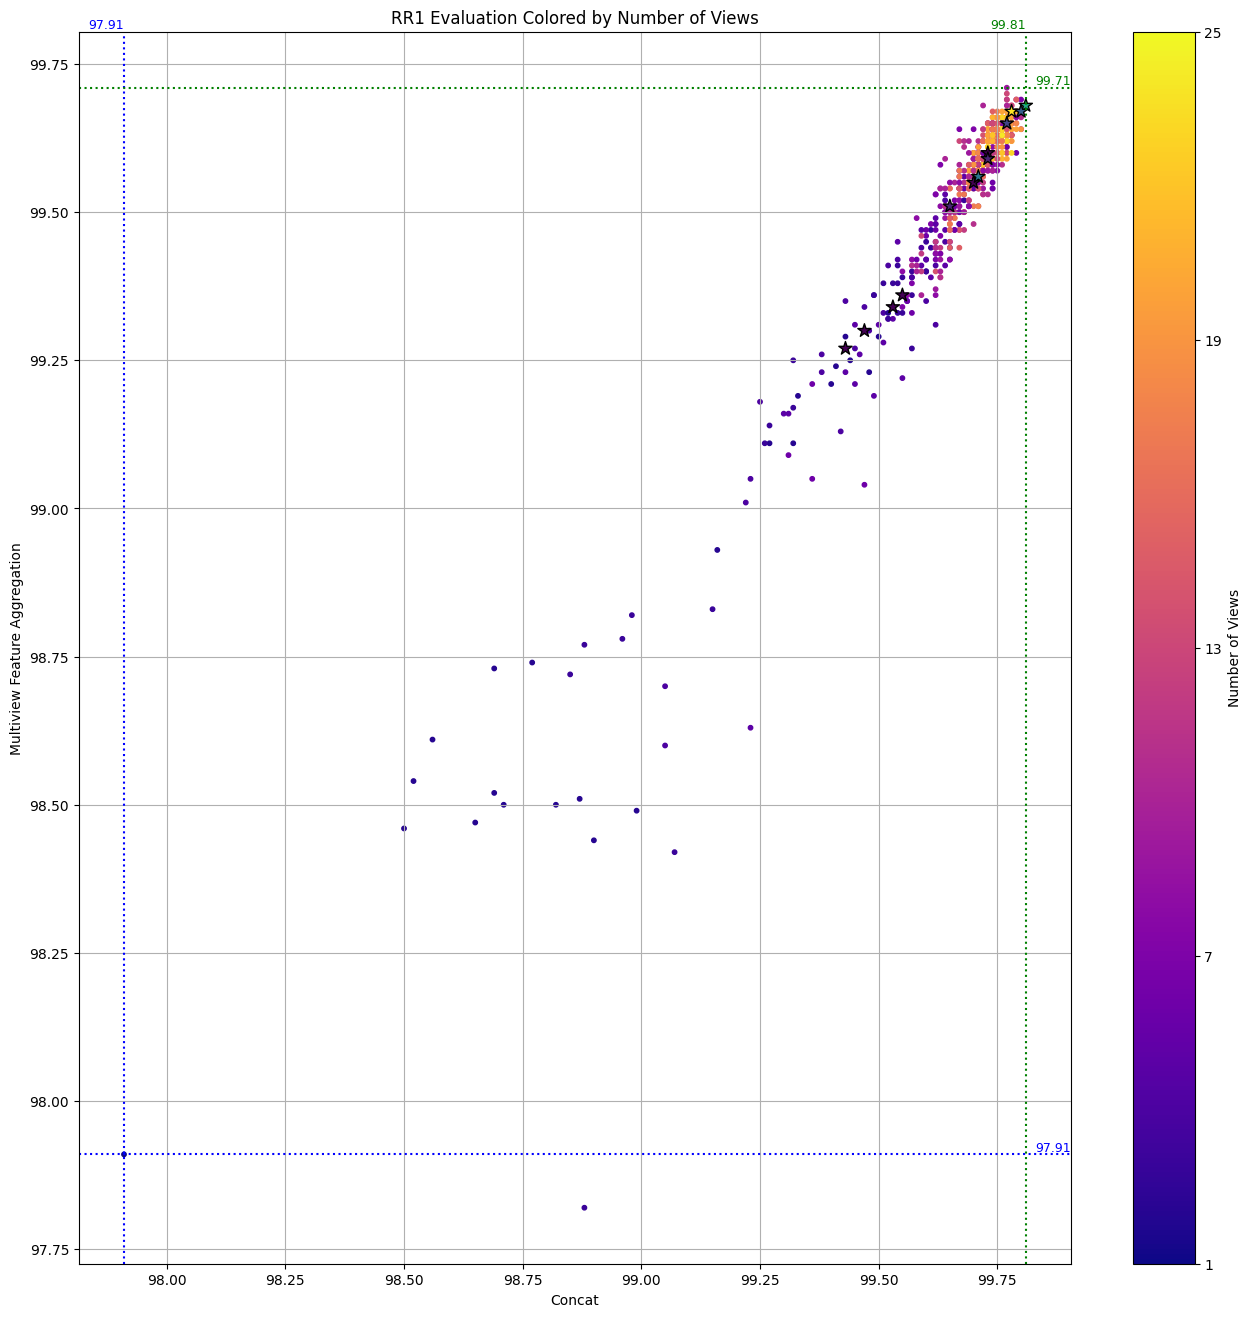

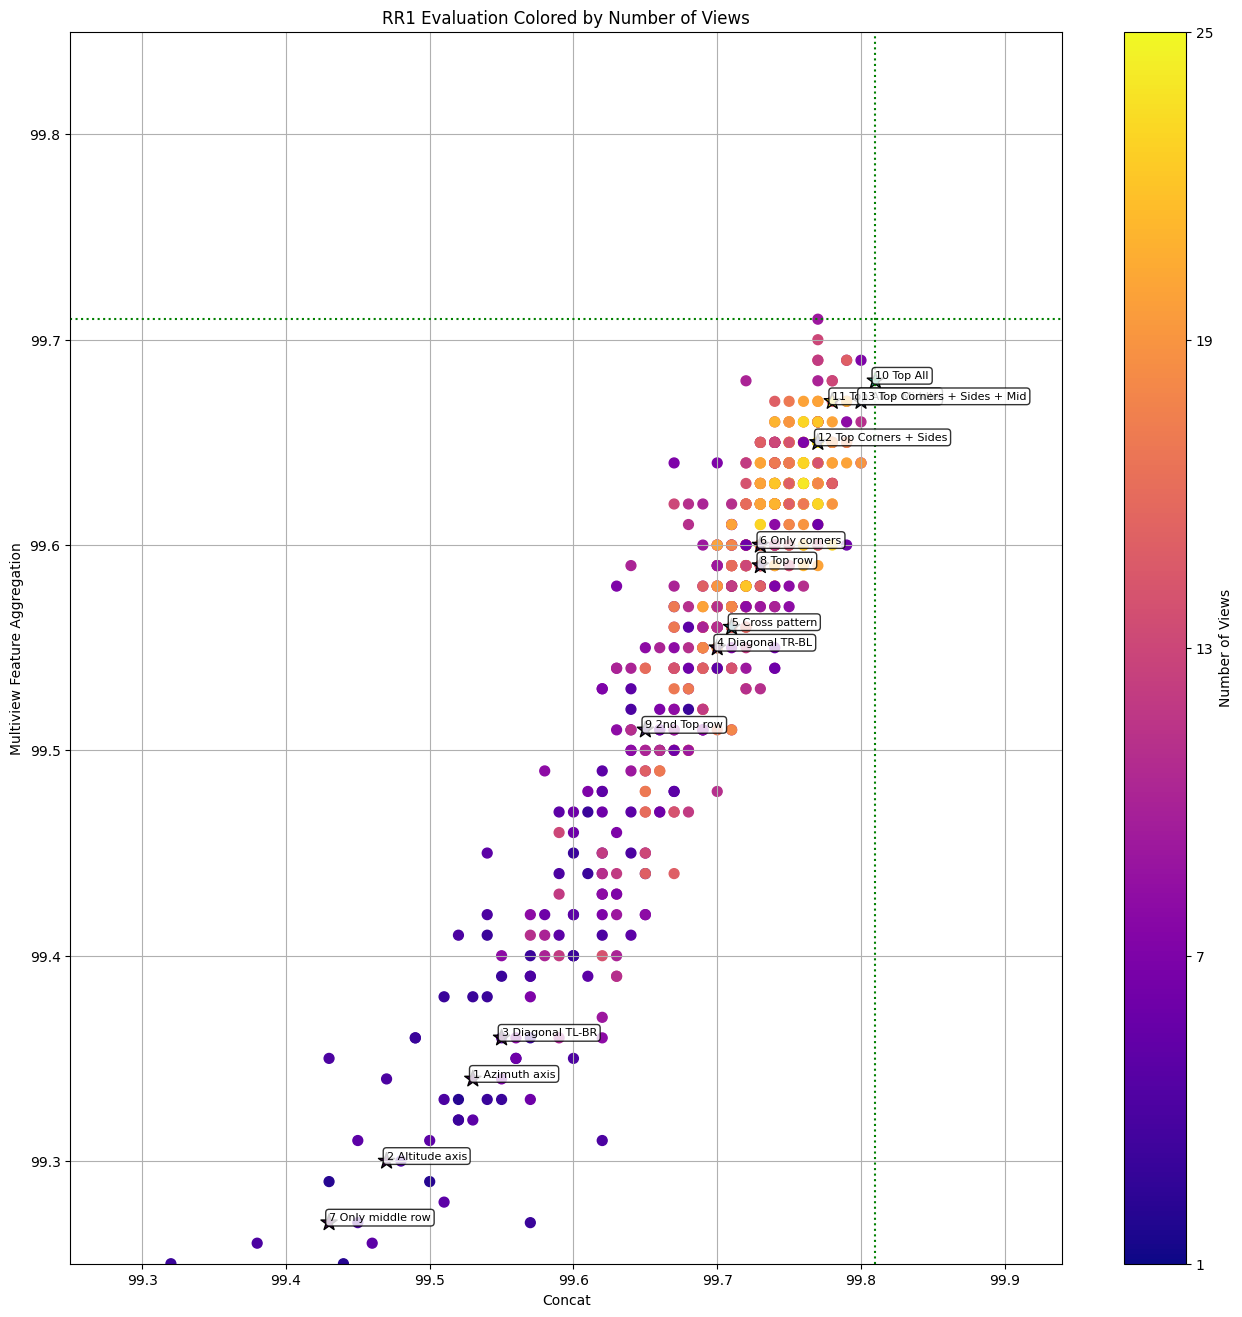

17 30
5 36
15 31
10 30
16 30
19 30
12 30
13 30
7 31
22 30
18 30
9 31
8 31
14 30
24 24
3 30
23 30
21 30
6 32
11 31
2 24
4 30
20 30
25 1
1 1


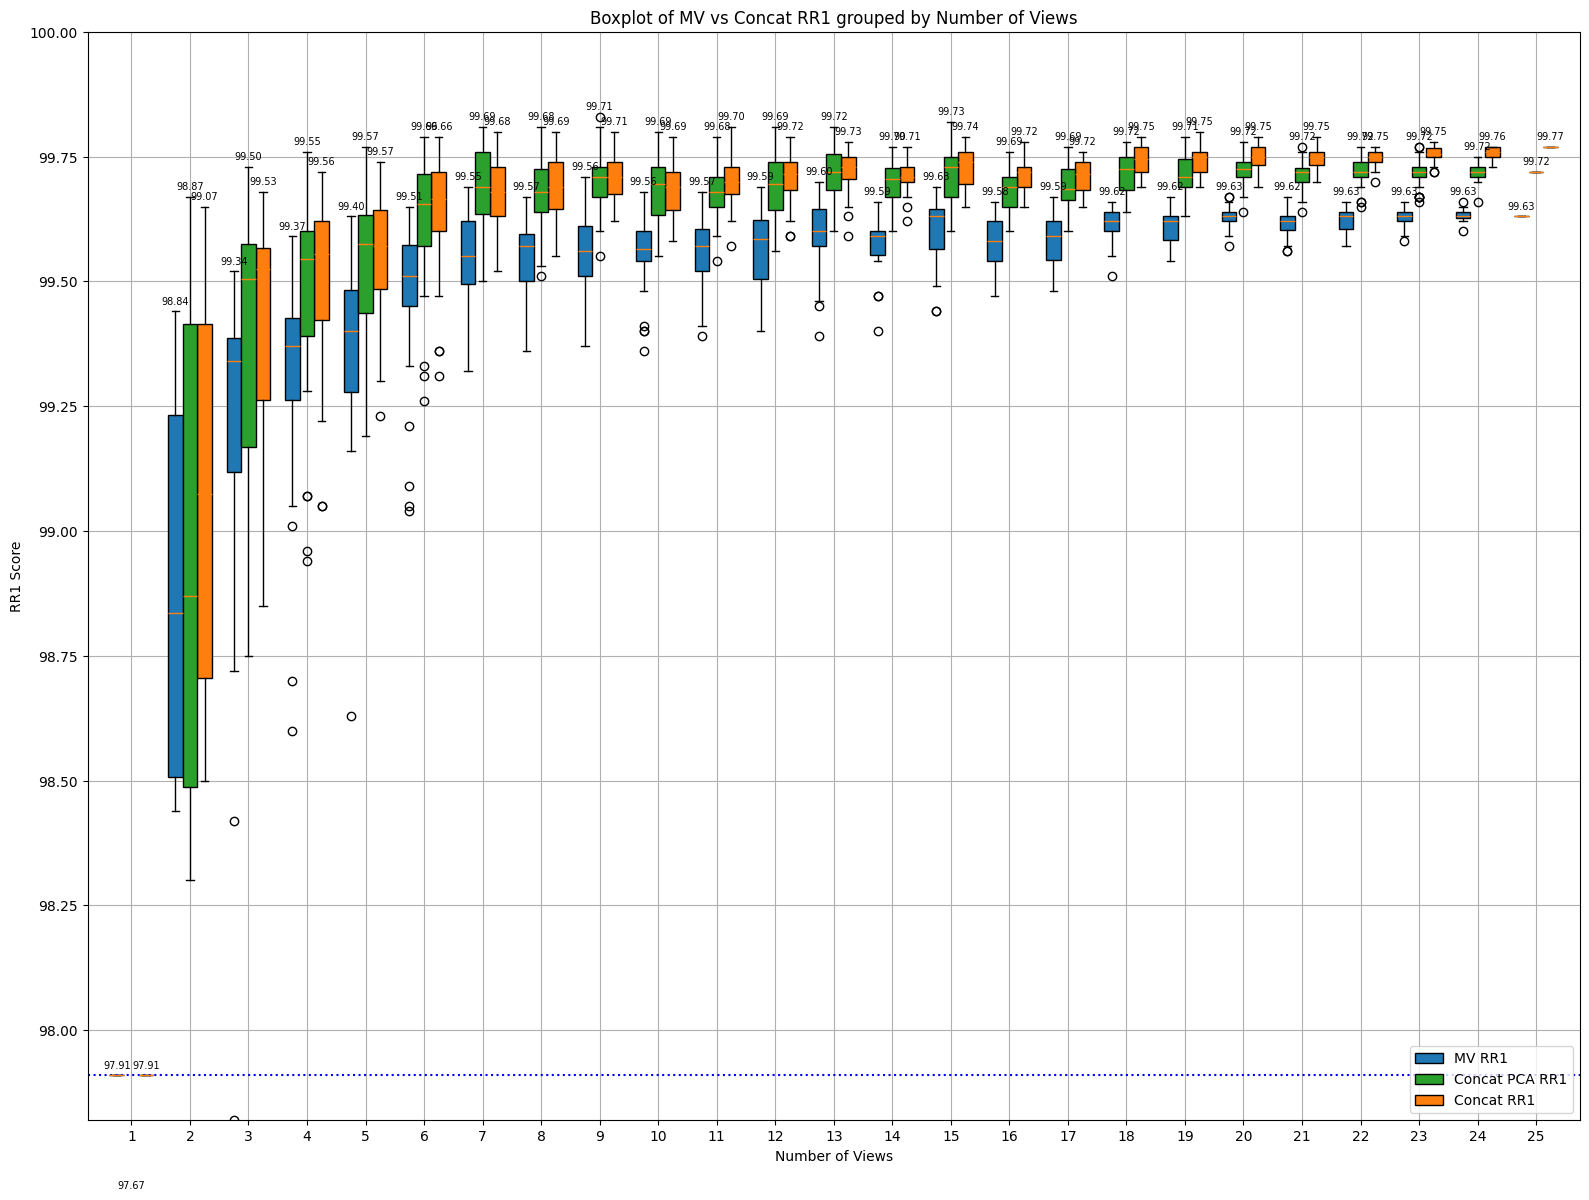

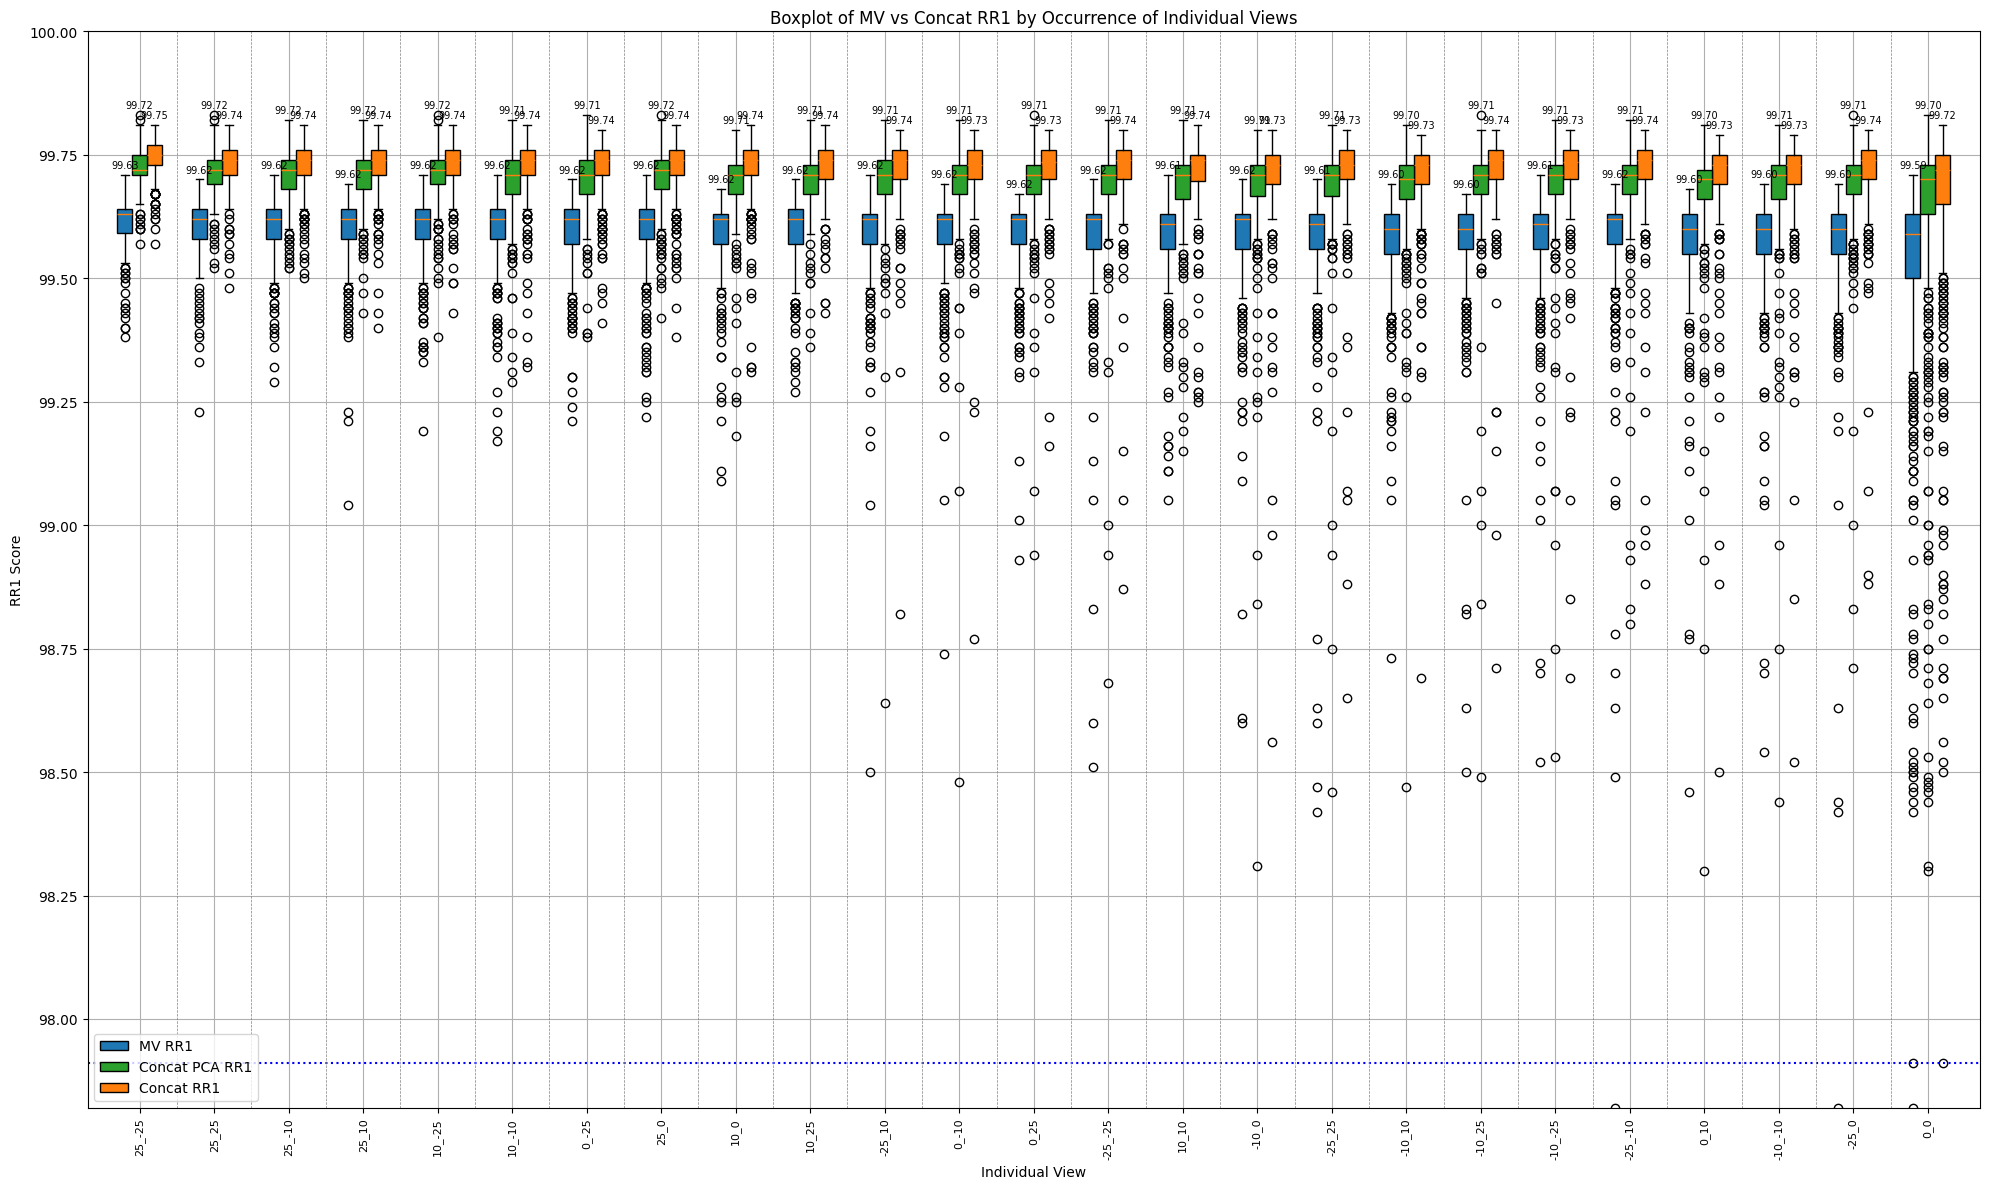

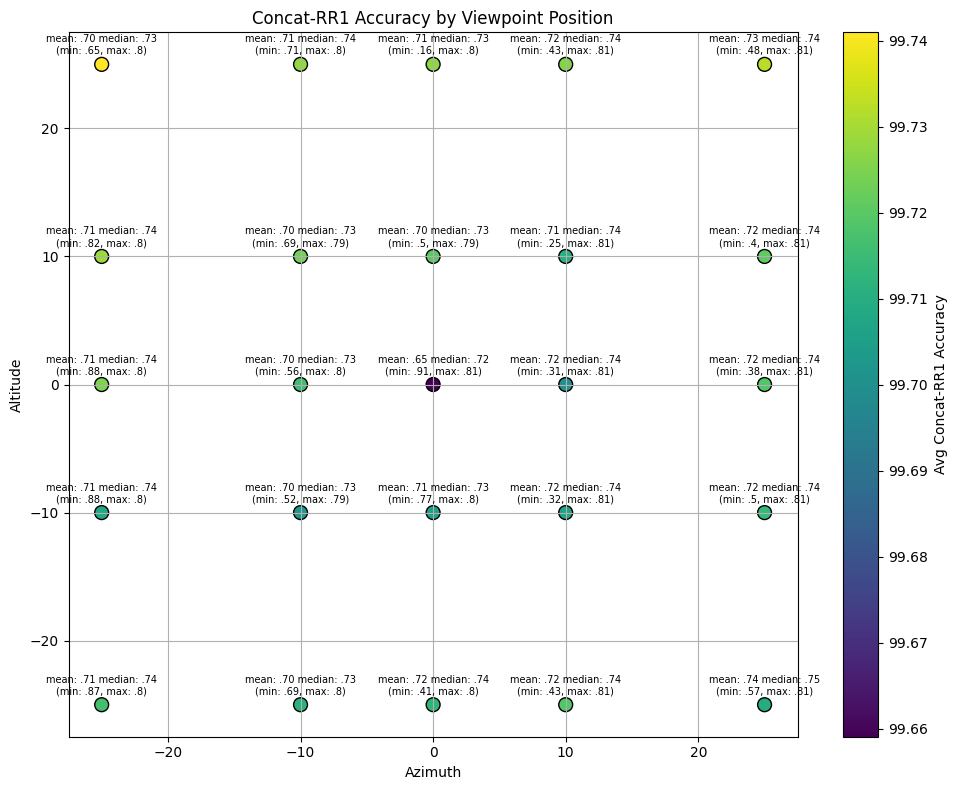

In [ ]:
process_and_plot3('192_masseval_no_bias30E.txt', xlim=(99.25, 99.94), ylim=(99.25, 99.85))

Dataset len: 703
---- Extras Only ----
11 Top All + Middle | Views: ['0_0', '25_-25', '25_-10', '25_0', '25_10', '25_25', '10_-25', '10_-10', '10_0', '10_10', '10_25', '0_-25', '0_-10', '0_10', '0_25']
  Front RR1: 98.69
  Concat RR1: 99.85
  ConcatPCA RR1: 99.82
  MV RR1: 99.74

1 Azimuth axis | Views: ['0_0', '-25_0', '-10_0', '25_0', '10_0']
  Front RR1: 98.69
  Concat RR1: 99.73
  ConcatPCA RR1: 99.73
  MV RR1: 99.61

12 Top Corners + Sides | Views: ['0_0', '25_-25', '25_25', '10_-10', '10_10', '0_-25', '0_25']
  Front RR1: 98.69
  Concat RR1: 99.84
  ConcatPCA RR1: 99.81
  MV RR1: 99.73

9 2nd Top row | Views: ['0_0', '10_-25', '10_-10', '10_0', '10_10', '10_25']
  Front RR1: 98.69
  Concat RR1: 99.74
  ConcatPCA RR1: 99.69
  MV RR1: 99.65

6 Only corners | Views: ['0_0', '-25_-25', '-25_25', '25_-25', '25_25']
  Front RR1: 98.69
  Concat RR1: 99.83
  ConcatPCA RR1: 99.81
  MV RR1: 99.73

4 Diagonal TR-BL | Views: ['0_0', '-25_25', '-10_10', '10_-10', '25_-25']
  Front RR1: 98.69


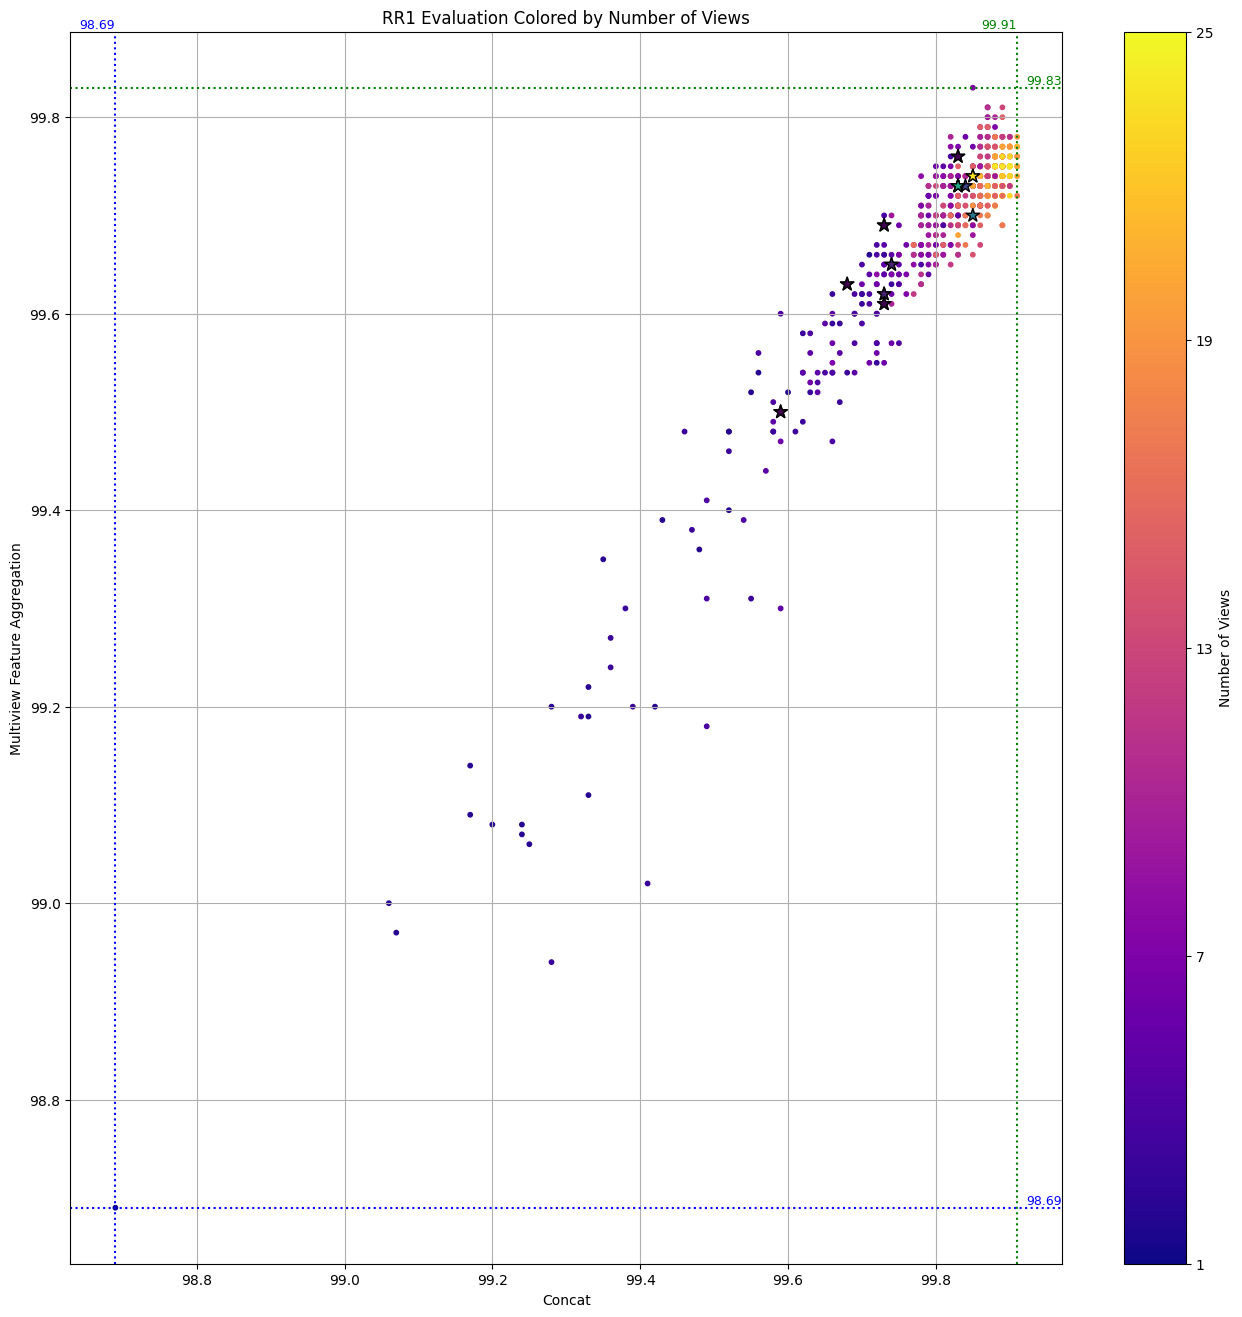

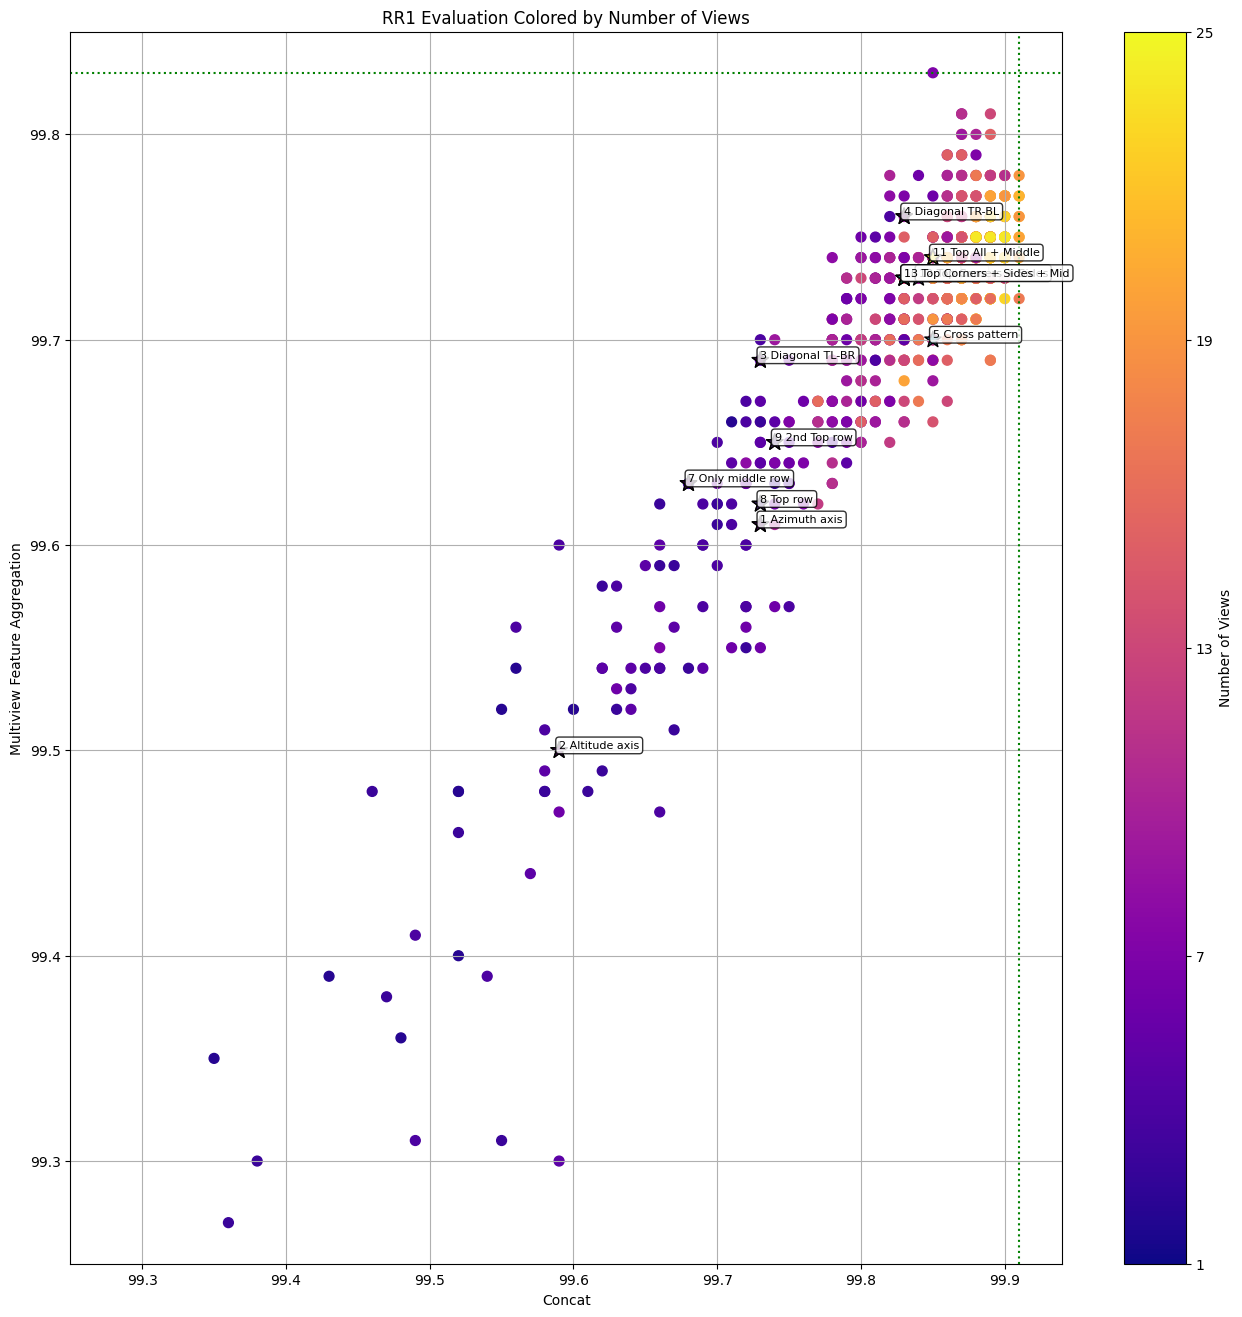

15 32
5 42
7 31
6 34
8 31
9 31
11 32
17 30
10 30
16 30
19 30
12 30
13 30
22 30
18 30
14 30
24 24
3 30
23 30
21 30
2 24
4 30
20 30
25 1
1 1


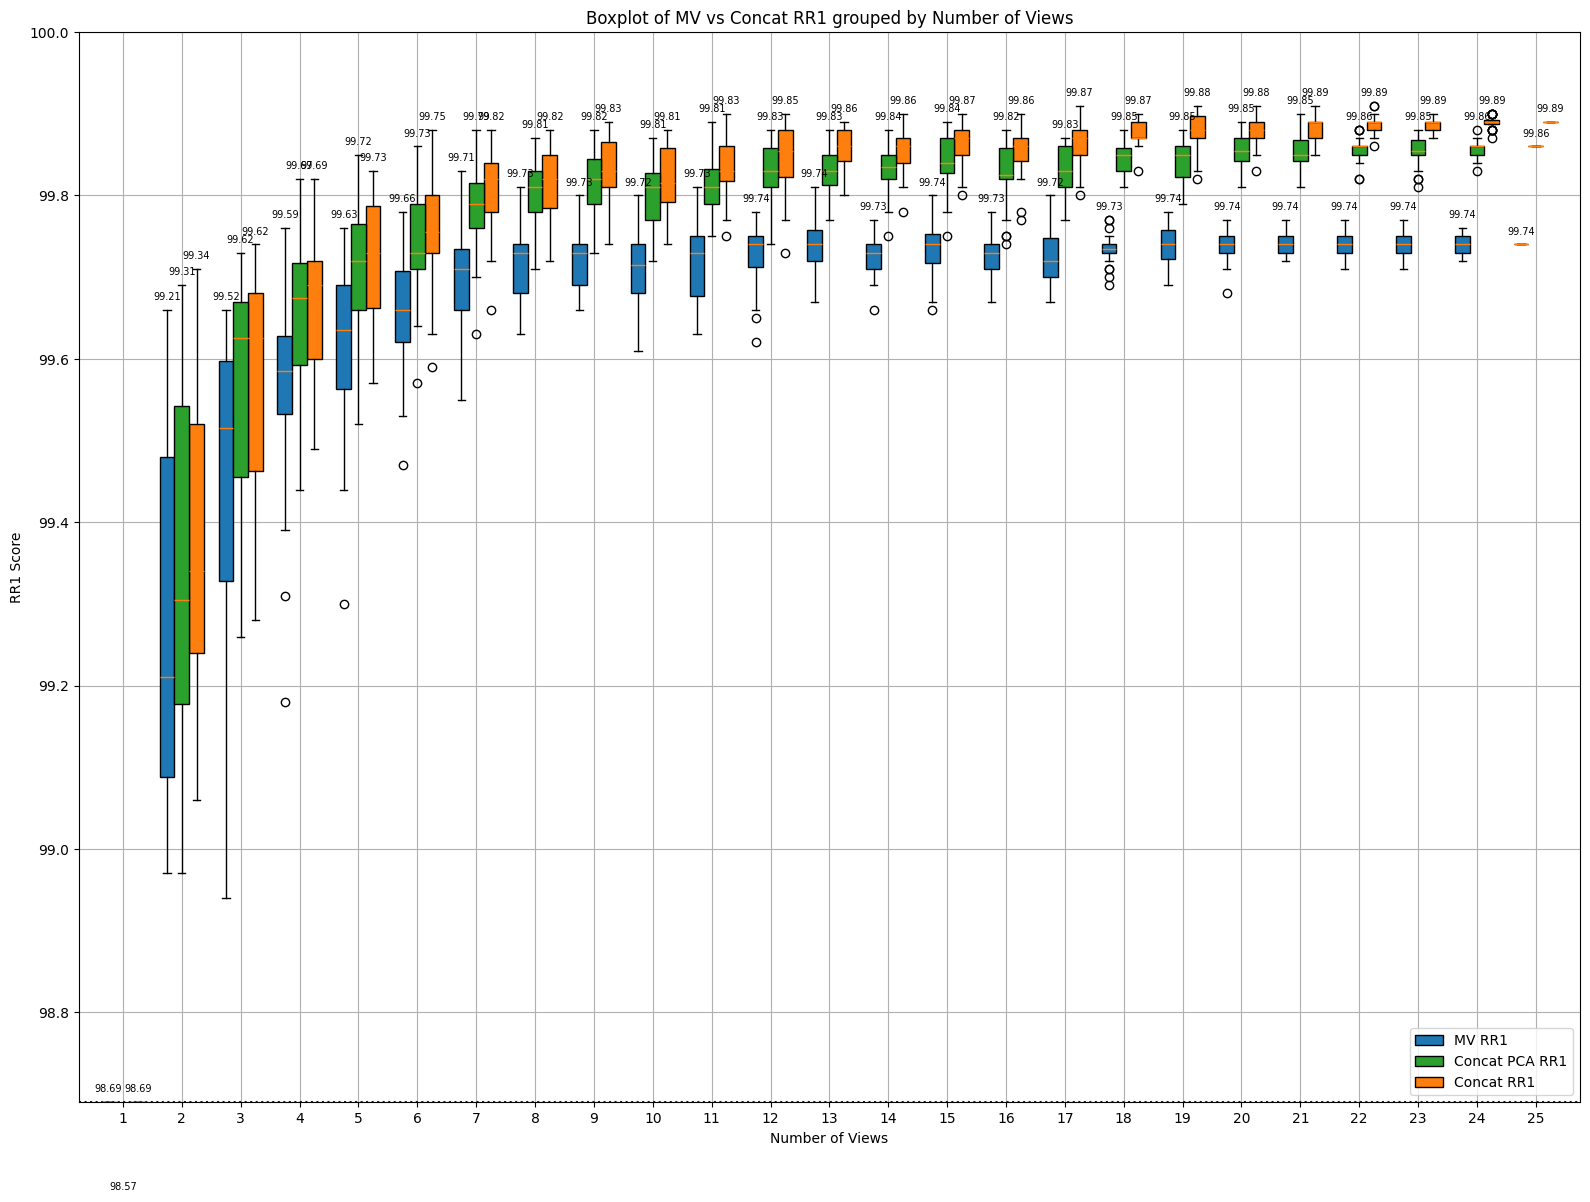

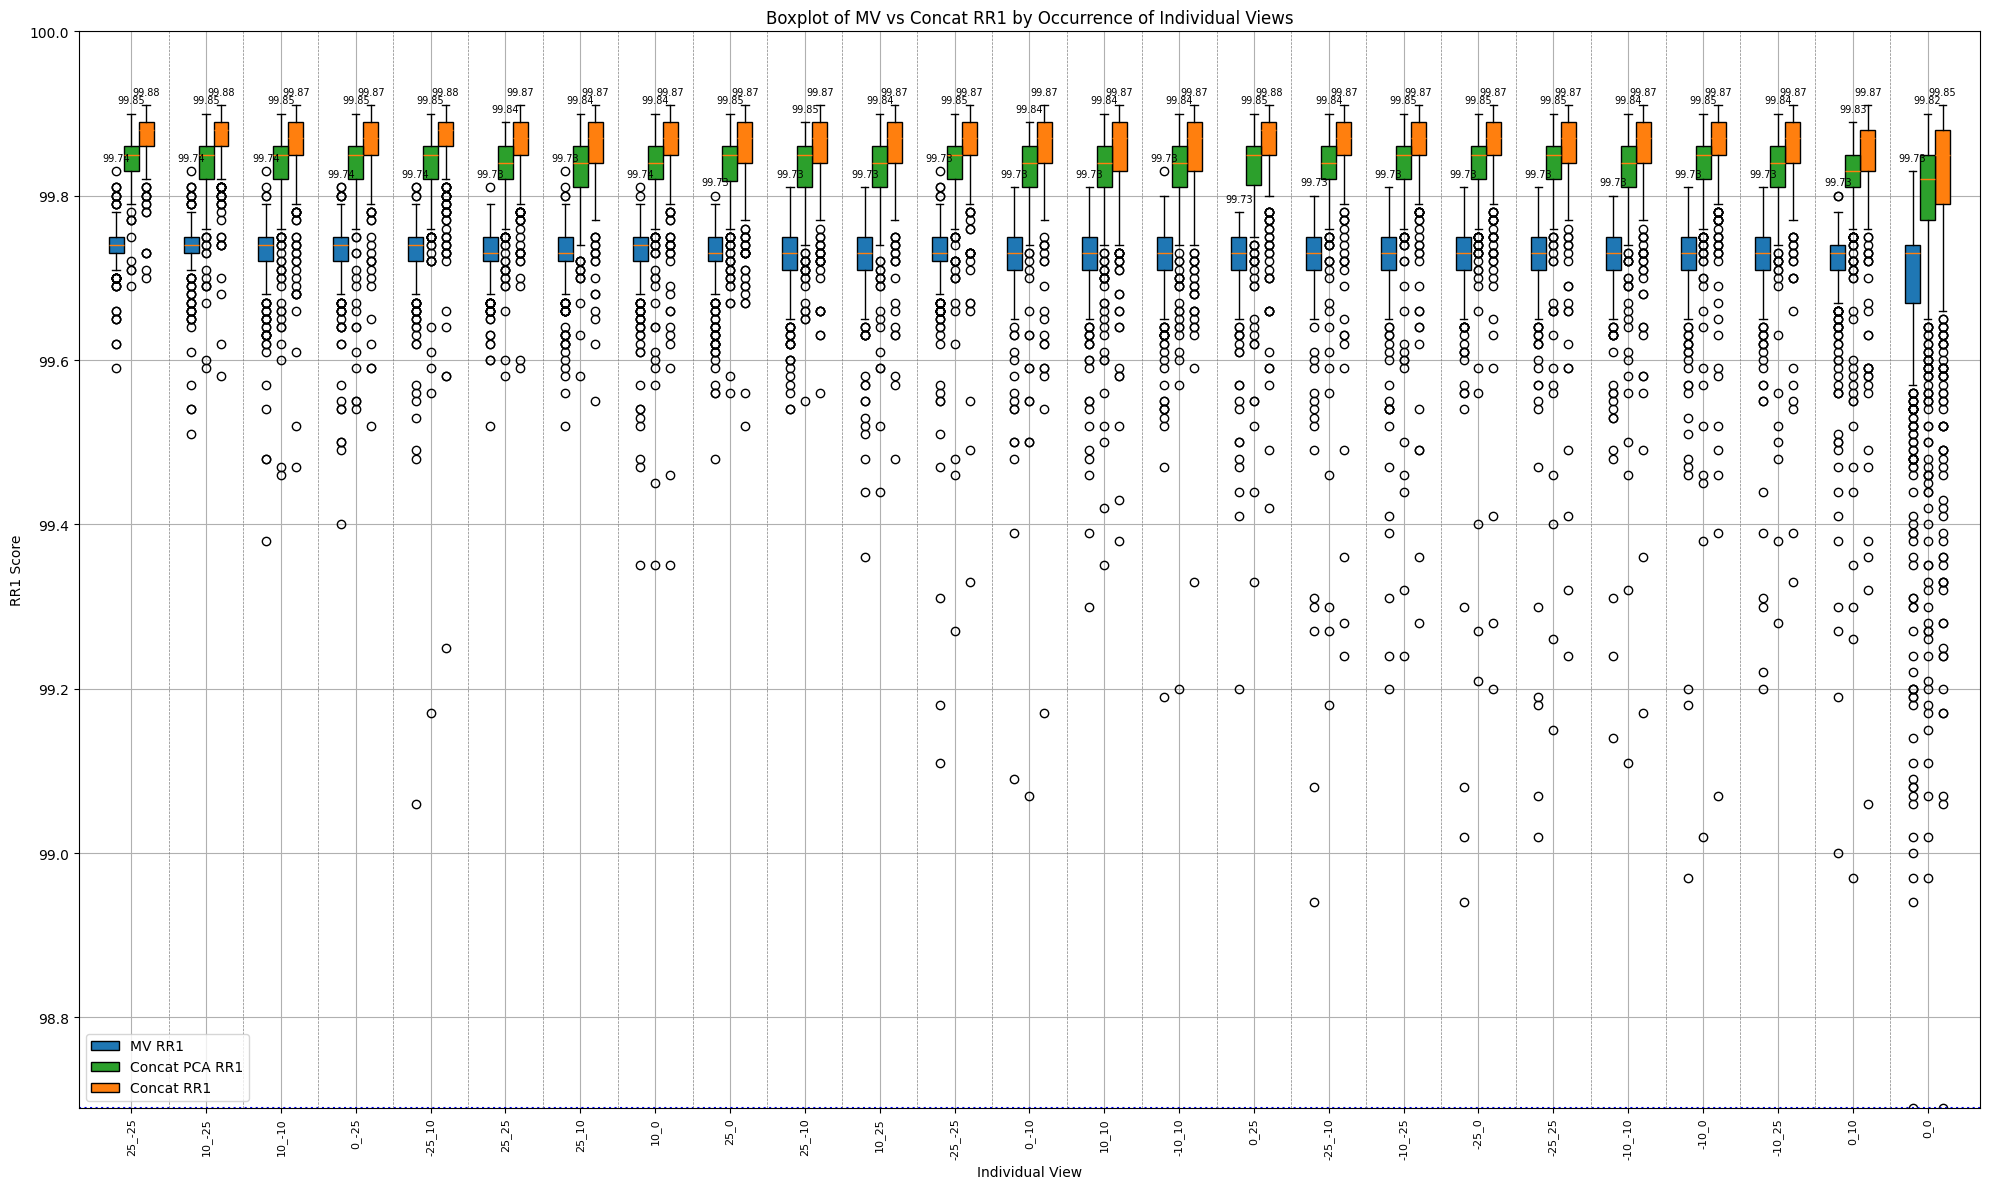

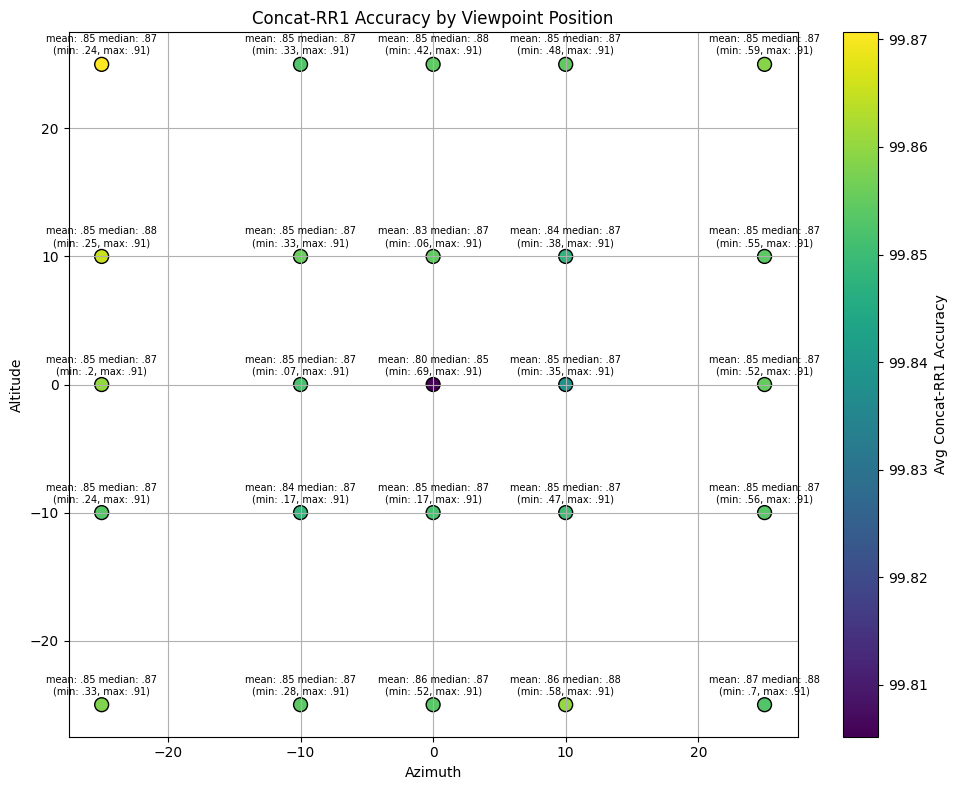

In [4]:
process_and_plot3('193_masseval_no_bias30E.txt', xlim=(99.25, 99.94), ylim=(99.25, 99.85))

Dataset len: 696
---- Extras Only ----


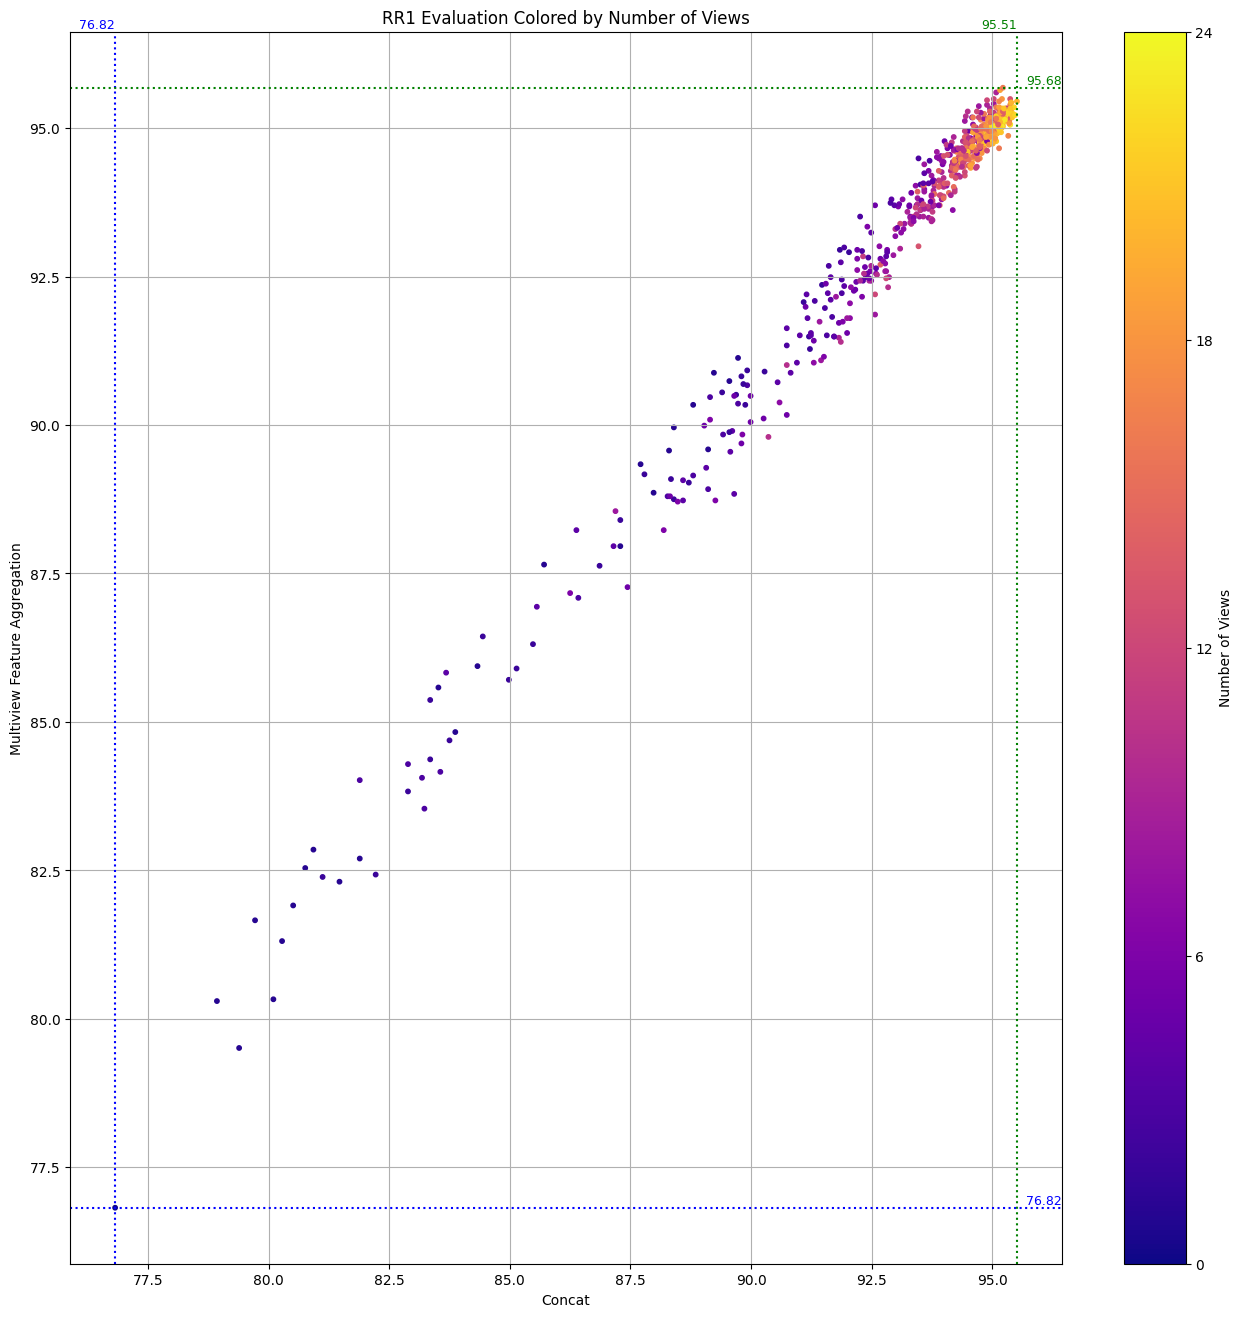

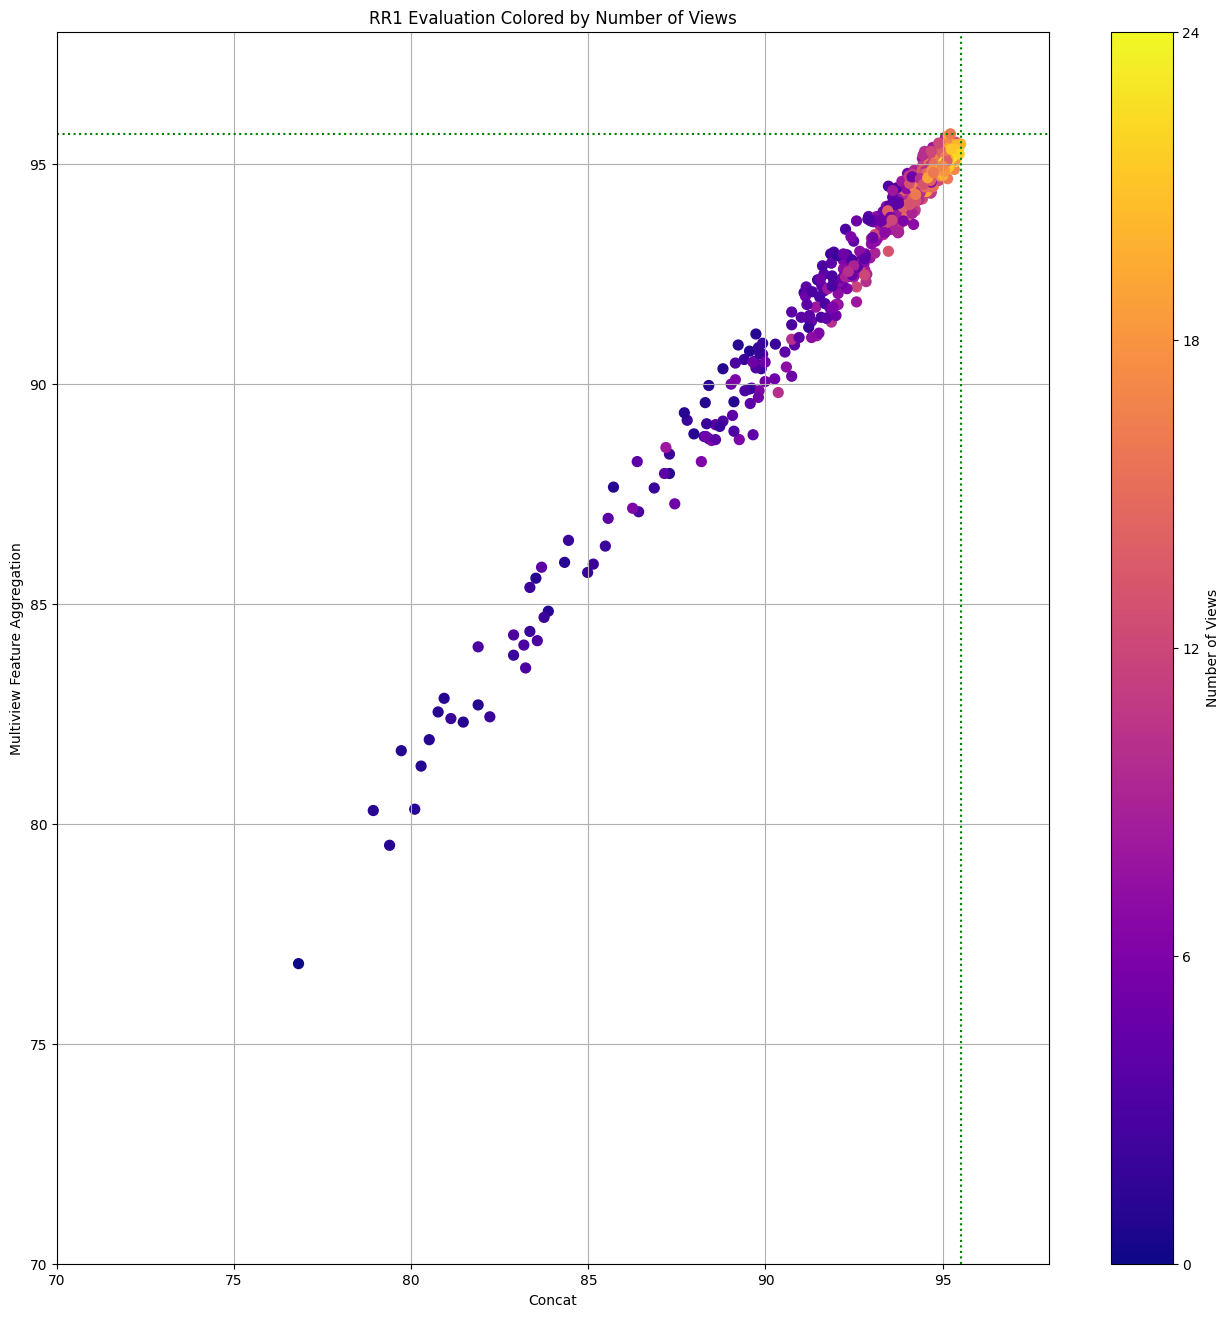

18 30
8 32
15 30
14 31
19 30
22 30
17 30
7 31
21 30
10 31
1 24
9 30
13 30
12 30
2 30
11 30
16 30
6 31
20 30
23 24
4 37
5 33
3 30
0 1
24 1


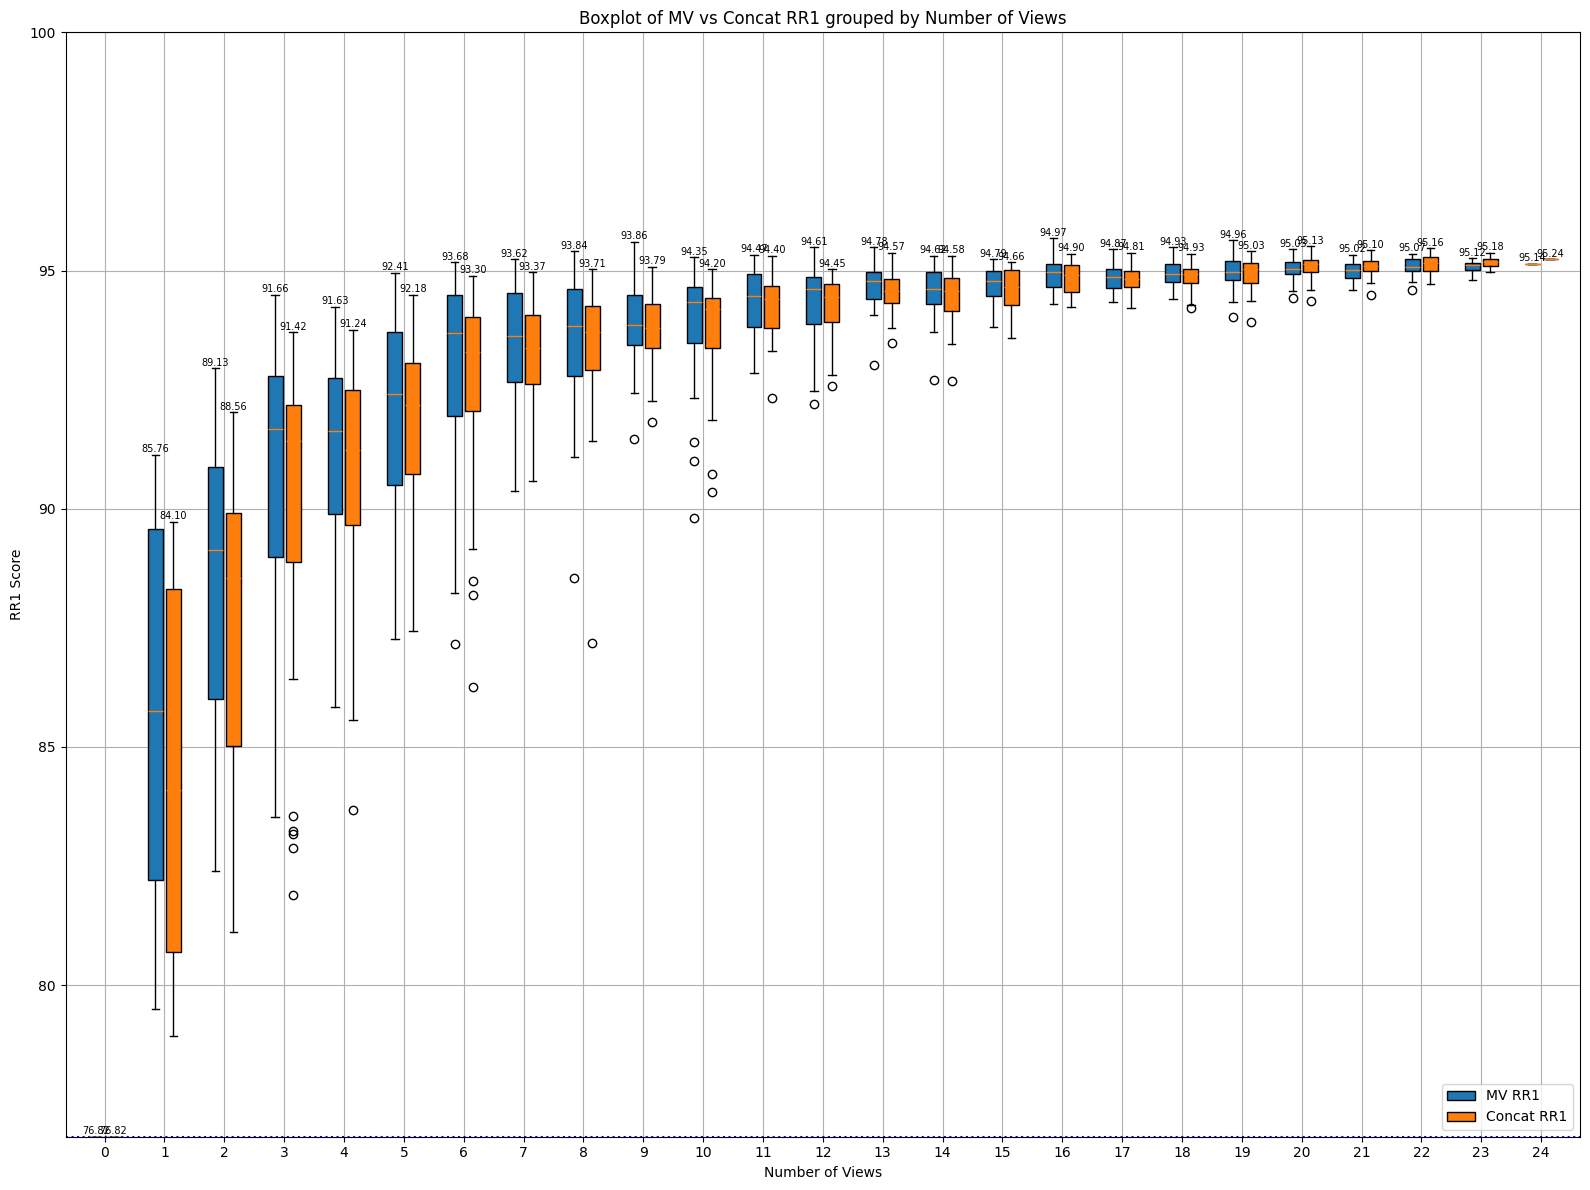

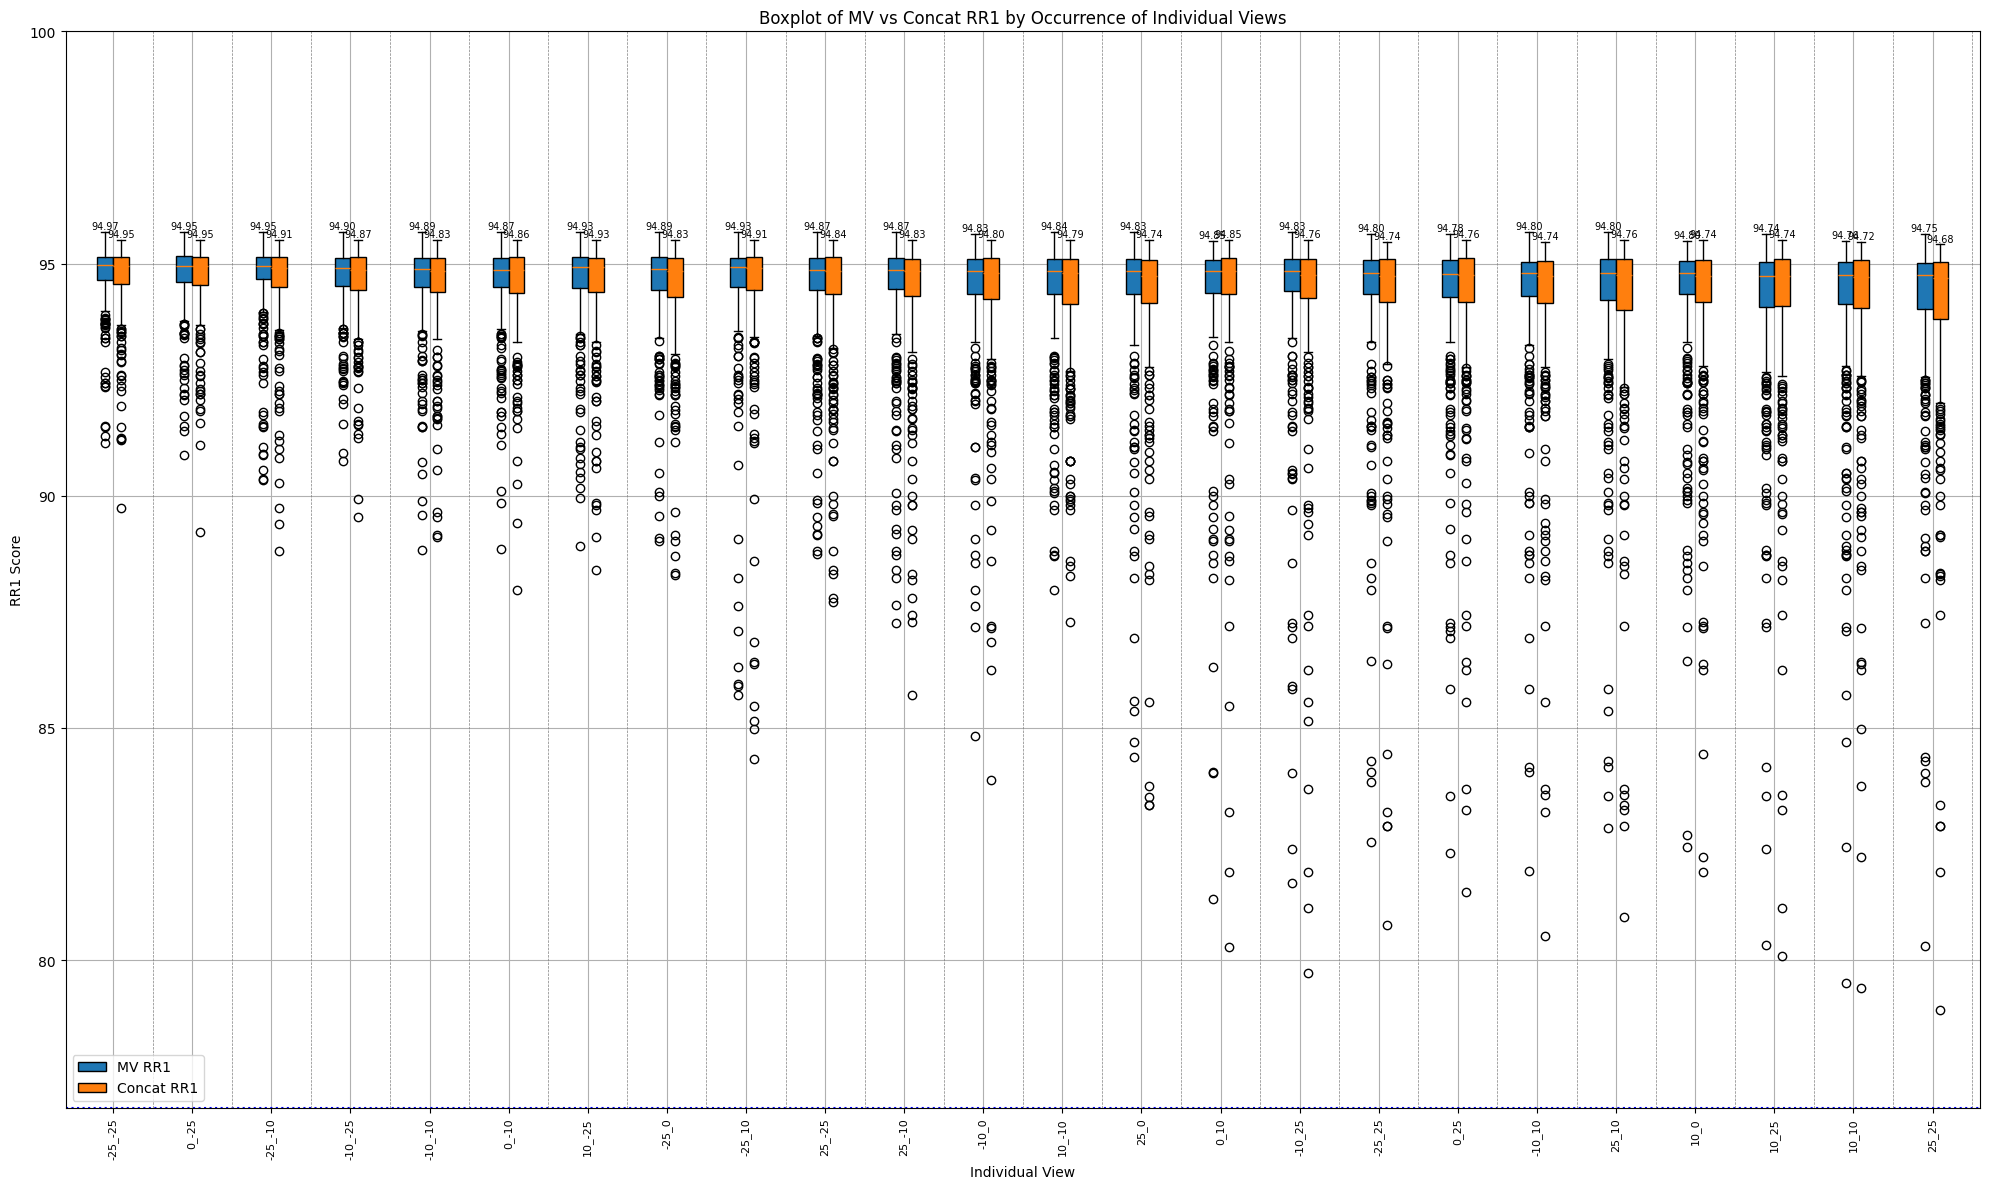

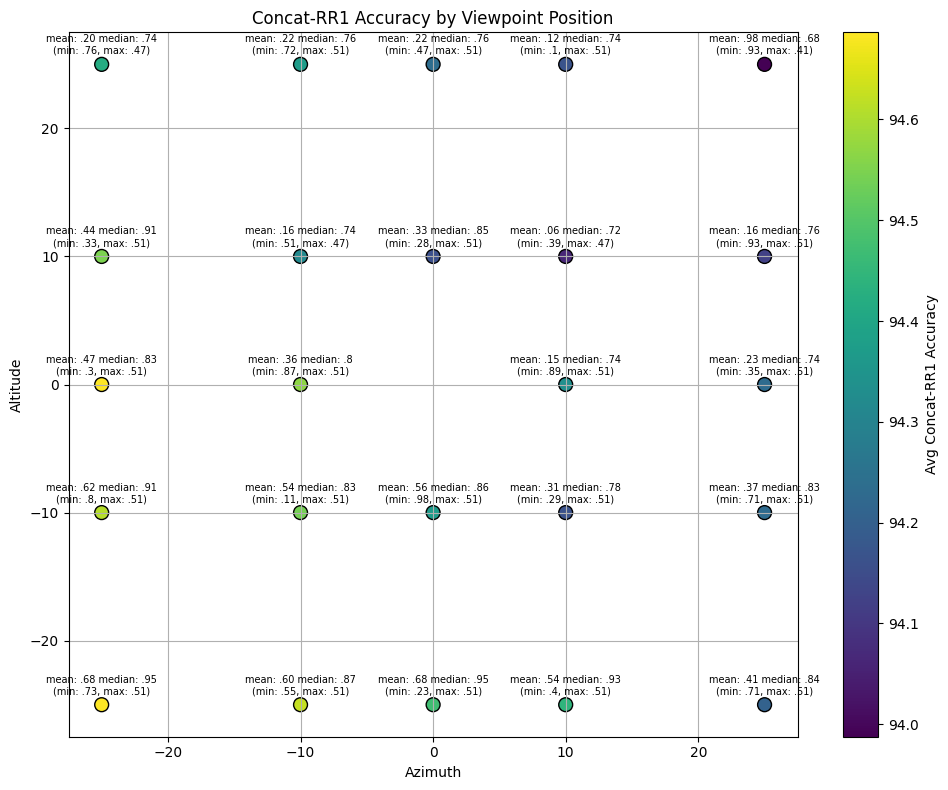

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from collections import defaultdict

extras = [['0_0', '-25_0', '-10_0', '25_0', '10_0'],  # Azimuth axis
            ['0_0', '0_-25', '0_-10', '0_10', '0_25'],  # Alitude axis
            ['0_0', '-25_-25', '-10_-10', '10_10', '25_25'],  # diagonal
            ['0_0', '-25_25', '-10_10', '10_-10', '25_-25'],  # diagonal
            ['0_0', '-25_25', '-10_10', '10_-10', '25_-25', '-25_-25', '-10_-10', '10_10', '25_25'],  # cross
            ['0_0', '-25_-25', '-25_25', '25_-25', '25_25'],  # Only corners
            ['0_0', '-10_-10', '-10_10', '10_-10', '10_10'],  # Only middle row
            ['0_0', '25_-25', '25_-10', '25_0', '25_10', '25_25'],  # Top row
            ['0_0', '10_-25', '10_-10', '10_0', '10_10', '10_25'],  # 2 Top row
            ['0_0', '25_-25', '25_-10', '25_0', '25_10', '25_25', '10_-25', '10_-10', '10_0', '10_10', '10_25'],  # Tops All
            ['0_0', '25_-25', '25_-10', '25_0', '25_10', '25_25', '10_-25', '10_-10', '10_0', '10_10', '10_25', '0_-25', '0_-10', '0_10', '0_25'],  # Tops All + Middle
            ['0_0', '25_-25', '25_25', '10_-10', '10_10', '0_-25', '0_25'],  # Tops Corners + Middle Sides
            ['0_0', '25_-25', '25_25', '10_-10', '10_10', '0_-25', '0_25', '25_0'],  # Tops Corners + Middle and Top Sides
            ]

extras_labels = {
    0: '1 Azimuth axis',
    1: '2 Altitude axis',
    2: '3 Diagonal TL-BR',
    3: '4 Diagonal TR-BL',
    4: '5 Cross pattern',
    5: '6 Only corners',
    6: '7 Only middle row',
    7: '8 Top row',
    8: '9 2nd Top row',
    9: '10 Top All',
    10: '11 Top All + Middle',
    11: '12 Top Corners + Sides',
    12: '13 Top Corners + Sides + Mid'
}

extras_sets = [set(group) for group in extras]
special_views = sorted(set(v for group in extras for v in group))

def is_extra(coords):
    return any(set(coords) == extra for extra in extras_sets)

def clean_ansi(text):
    ansi_codes = ['\x1b[92m', '\x1b[0m', '\x1b[1m', '\x1b[4m']
    for code in ansi_codes:
        text = text.replace(code, '')
    return text

def get_extra_label(coords):
    for i, extra_set in enumerate(extras_sets):
        if set(coords) == extra_set:
            return extras_labels[i]
    return "Unknown Extra Pattern"

def process_and_plot3(file_path, xlim, ylim):

    with open(file_path, 'r') as file:
        data = file.readlines()

    results = []
    for line in data:
        line = clean_ansi(line).strip()
        if "Front-RR1:" in line:
            line = line.strip()
            dataset_part, eval_part = line.split("E118Q4793:")

            # Parse crop coordinates
            dataset_name, *coords_strs = dataset_part.split(":")[0].strip().split()

            parts = eval_part.split()
            front_rr1 = float(parts[1])
            concat_rr1 = float(parts[5])
            #concatpca_rr1 = float(parts[13])
            mv_rr1 = float(parts[17])

            results.append((coords_strs , front_rr1, concat_rr1, mv_rr1))

    print(f"Dataset len:", len(results))

    coords_strs = [r[0] for r in results]
    front_rr1_values = [r[1] for r in results]
    concat_rr1_values = [r[2] for r in results]
    mv_rr1_values = [r[3] for r in results]


    print("---- Extras Only ----")
    for coords, front_rr1, concat_rr1, mv_rr1 in results:
        if is_extra(coords):
            label = get_extra_label(coords)
            print(f"{label} | Views: {coords}")
            print(f"  Front RR1: {front_rr1:.2f}")
            print(f"  Concat RR1: {concat_rr1:.2f}")
            print(f"  MV RR1: {mv_rr1:.2f}")
            print()

    # ----------------Scatter ---------------
    lengths = [len(c) for c in coords_strs]
    min_len, max_len = min(lengths), max(lengths)
    norm = mcolors.Normalize(vmin=min_len, vmax=max_len)
    cmap = cm.plasma

    fig, ax = plt.subplots(figsize=(16, 16))
    #scatter = ax.scatter(concat_rr1_values, mv_rr1_values, c=lengths, cmap=cmap, norm=norm, s=10)
    colors = [lengths[i] for i in range(len(coords_strs))]
    is_extras = [is_extra(coords_strs[i]) for i in range(len(coords_strs))]

    scatter = ax.scatter(
        [concat_rr1_values[i] for i in range(len(coords_strs)) if not is_extras[i]],
        [mv_rr1_values[i] for i in range(len(coords_strs)) if not is_extras[i]],
        c=[colors[i] for i in range(len(coords_strs)) if not is_extras[i]],
        cmap=cmap, norm=norm, s=10, label="Regular Samples"
    )
    scatter_extras = ax.scatter(
        [concat_rr1_values[i] for i in range(len(coords_strs)) if is_extras[i]],
        [mv_rr1_values[i] for i in range(len(coords_strs)) if is_extras[i]],
        c=[colors[i] for i in range(len(coords_strs)) if is_extras[i]],
        edgecolors='black', marker='*', s=100, label="Extras"
    )

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Number of Views')
    tick_values = np.linspace(min_len, max_len, num=5, dtype=int)
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels([str(v) for v in tick_values])
    #for i, txt in enumerate(coords_strs):
    #    ax.annotate(len(txt), (concat_rr1_values[i]+1.0, mv_rr1_values[i]-0.005), fontsize=8, ha='right')
    ax.set_xlabel('Concat')
    val1 = front_rr1_values[0]
    val2 = max(concat_rr1_values)
    val3 = max(mv_rr1_values)
    ax.axvline(val1, color='b', ls=':')
    ax.axhline(val1, color='b', ls=':')
    ax.text(val1, ax.get_ylim()[1], f'{val1:.2f}', color='b', va='bottom', ha='right', fontsize=9)
    ax.text(ax.get_xlim()[1], val1, f'{val1:.2f}', color='b', va='bottom', ha='right', fontsize=9)
    ax.axvline(val2, color='g', ls=':')
    ax.axhline(val3, color='g', ls=':')
    ax.text(val2, ax.get_ylim()[1], f'{val2:.2f}', color='g', va='bottom', ha='right', fontsize=9)
    ax.text(ax.get_xlim()[1], val3, f'{val3:.2f}', color='g', va='bottom', ha='right', fontsize=9)
    ax.set_ylabel('Multiview Feature Aggregation')
    ax.set_title('RR1 Evaluation Colored by Number of Views')
    plt.grid(True)
    plt.show()

    # ------------- Zoomed in scatter ------------------
    lengths = [len(c) for c in coords_strs]
    min_len, max_len = min(lengths), max(lengths)
    norm = mcolors.Normalize(vmin=min_len, vmax=max_len)
    cmap = cm.plasma

    fig, ax = plt.subplots(figsize=(16, 16))
    scatter = ax.scatter(
        [concat_rr1_values[i] for i in range(len(coords_strs)) if not is_extras[i]],
        [mv_rr1_values[i] for i in range(len(coords_strs)) if not is_extras[i]],
        c=[colors[i] for i in range(len(coords_strs)) if not is_extras[i]],
        cmap=cmap, norm=norm, s=50, label="Regular Samples"
    )
    scatter_extras = ax.scatter(
        [concat_rr1_values[i] for i in range(len(coords_strs)) if is_extras[i]],
        [mv_rr1_values[i] for i in range(len(coords_strs)) if is_extras[i]],
        c=[colors[i] for i in range(len(coords_strs)) if is_extras[i]],
        edgecolors='black', marker='*', s=150, label="Extras"
    )

    
    for i, extra_group in enumerate(extras_sets):
        label = extras_labels.get(i, f"Extras {i}")
        for j, coords in enumerate(coords_strs):
            if set(coords) == extra_group:
                x = concat_rr1_values[j]
                y = mv_rr1_values[j]
                ax.annotate(label, (x, y), fontsize=8, ha='left', va='bottom', color='black',
                            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
                break
            
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Number of Views')
    tick_values = np.linspace(min_len, max_len, num=5, dtype=int)
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels([str(v) for v in tick_values])
    #for i, txt in enumerate(coords_strs):
    #    ax.annotate(len(txt), (concat_rr1_values[i]+1.0, mv_rr1_values[i]-0.005), fontsize=8, ha='right')
    ax.axvline(val2, color='g', ls=':')
    ax.axhline(val3, color='g', ls=':')
    ax.set_xlabel('Concat')
    ax.set_ylabel('Multiview Feature Aggregation')
    ax.set_title('RR1 Evaluation Colored by Number of Views')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.grid(True)
    plt.show()


    # --- Group values by number of views ---
    mv_grouped = defaultdict(list)
    concat_grouped = defaultdict(list)
    for coords, mv_val, concat_val in zip(coords_strs, mv_rr1_values, concat_rr1_values):
        view_count = len(coords)
        mv_grouped[view_count].append(mv_val)
        concat_grouped[view_count].append(concat_val)

    for k,v in concat_grouped.items():
        print(k, len(v))

    lengths_sorted = sorted(set(mv_grouped.keys()).union(concat_grouped.keys()))
    mv_data = [mv_grouped[l] for l in lengths_sorted]
    concat_data = [concat_grouped[l] for l in lengths_sorted]
    mins_mv = [np.min(mv_grouped[l]) for l in lengths_sorted]
    meds_mv = [np.median(mv_grouped[l]) for l in lengths_sorted]
    maxs_mv = [np.max(mv_grouped[l]) for l in lengths_sorted]
    mins_concat = [np.min(concat_grouped[l]) for l in lengths_sorted]
    meds_concat = [np.median(concat_grouped[l]) for l in lengths_sorted]
    maxs_concat = [np.max(concat_grouped[l]) for l in lengths_sorted]
    x_vals = np.arange(1, len(lengths_sorted) + 1)
    positions_mv = x_vals - 0.15
    positions_concat = x_vals + 0.15

    fig, ax = plt.subplots(figsize=(16, 12))

    bp_mv = ax.boxplot(mv_data, positions=positions_mv, widths=0.25, patch_artist=True)
    bp_concat = ax.boxplot(concat_data, positions=positions_concat, widths=0.25, patch_artist=True)

    for patch in bp_mv['boxes']:
        patch.set_facecolor('#1f77b4')  # blue
    for patch in bp_concat['boxes']:
        patch.set_facecolor('#ff7f0e')  # orange

    for i in range(len(lengths_sorted)):
        ax.text(positions_mv[i], maxs_mv[i] + 0.01, f'{meds_mv[i]:.2f}', ha='center', va='bottom', fontsize=7, color='black')
        ax.text(positions_concat[i], maxs_concat[i] + 0.01, f'{meds_concat[i]:.2f}', ha='center', va='bottom', fontsize=7, color='black')

    ax.axhline(val1, color='b', linestyle=':')

    #ax.plot(x_vals, mins_mv, label='MV Min', color='blue', linestyle='--', marker='o', alpha=0.1)
    #ax.plot(x_vals, meds_mv, label='MV Median', color='red', linestyle='-', marker='o', alpha=0.1)
    #ax.plot(x_vals, maxs_mv, label='MV Max', color='green', linestyle='--', marker='o', alpha=0.1)
    #ax.plot(x_vals, mins_concat, label='Concat Min', color='blue', linestyle='--', marker='x', alpha=0.1)
    #ax.plot(x_vals, meds_concat, label='Concat Median', color='red', linestyle='-', marker='x', alpha=0.1)
    #ax.plot(x_vals, maxs_concat, label='Concat Max', color='green', linestyle='--', marker='x', alpha=0.1)

    ax.set_ylim(max(72, np.min(mv_rr1_values)), 100)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(lengths_sorted)
    ax.set_xlabel('Number of Views')
    ax.set_ylabel('RR1 Score')
    ax.set_title('Boxplot of MV vs Concat RR1 grouped by Number of Views')
    ax.grid(True)
    ax.legend([bp_mv["boxes"][0], bp_concat["boxes"][0]], ['MV RR1', 'Concat RR1'], loc='lower right')
    plt.tight_layout()
    plt.show()




    # ----------- Box Plot Views -----------
    mv_bucket = defaultdict(list)
    concat_bucket = defaultdict(list)
    for coords, mv_val, concat_val in zip(coords_strs, mv_rr1_values, concat_rr1_values):
        for coord in coords:
            mv_bucket[coord].append(mv_val)
            concat_bucket[coord].append(concat_val)

    sorted_coords = sorted(mv_bucket.keys(), key=lambda k: np.mean(mv_bucket[k]), reverse=True)

    mv_data = [mv_bucket[coord] for coord in sorted_coords]
    concat_data = [concat_bucket[coord] for coord in sorted_coords]

    fig, ax = plt.subplots(figsize=(max(20, len(sorted_coords) * 0.6), 12))

    positions_mv = np.arange(1, len(sorted_coords) + 1) - 0.1
    positions_concat = np.arange(1, len(sorted_coords) + 1) + 0.1

    bp_mv = ax.boxplot(mv_data, positions=positions_mv, patch_artist=True, widths=0.2)
    bp_concat = ax.boxplot(concat_data, positions=positions_concat, patch_artist=True, widths=0.2)

    for patch in bp_mv['boxes']:
        patch.set_facecolor('#1f77b4')  # Blue
    for patch in bp_concat['boxes']:
        patch.set_facecolor('#ff7f0e')  # Orange

    for i, (mv_vals, concat_vals) in enumerate(zip(mv_data, concat_data)):
        ax.text(positions_mv[i], np.max(mv_vals) + 0.01, f'{np.median(mv_vals):.2f}', 
                ha='center', va='bottom', fontsize=7, color='black')
        ax.text(positions_concat[i], np.max(concat_vals) + 0.01, f'{np.median(concat_vals):.2f}', 
                ha='center', va='bottom', fontsize=7, color='black')
        
    ax.axhline(val1, color='b', linestyle=':')

    ax.set_ylim(max(70, np.min(mv_rr1_values)), 100)
    ax.set_xticks(np.arange(1, len(sorted_coords) + 1))
    ax.set_xticklabels(sorted_coords, rotation=90, fontsize=8)
    ax.set_xlabel('Individual View')
    ax.set_ylabel('RR1 Score')
    ax.set_title('Boxplot of MV vs Concat RR1 by Occurrence of Individual Views')
    ax.legend([bp_mv["boxes"][0], bp_concat["boxes"][0]], ['MV RR1', 'Concat RR1'], loc='lower left')
    ax.grid(True)

    for x in x_vals[:-1]:
        ax.axvline(x + 0.5, color='gray', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()



    # ----------- Scatter Perspective plot ---------

    position_vals = defaultdict(list)

    for coords, val in zip(coords_strs, concat_rr1_values):
        for c in coords:
            position_vals[c].append(val)

    sorted_keys = sorted(position_vals.keys())
    alitude_coords = []
    azimuth_coords = []
    color_vals = []

    for key in sorted_keys:
        match = re.match(r"(-?\d+)_(-?\d+)", key)  # allow negative numbers
        if match:
            x, y = map(int, match.groups())
            alitude_coords.append(x)
            azimuth_coords.append(y)
            color_vals.append(np.mean(position_vals[key]))  # Avg RR1 per coord

    fig, ax = plt.subplots(figsize=(10, 8))
    sc = ax.scatter(azimuth_coords, alitude_coords , c=color_vals, cmap='viridis', edgecolor='black', s=100)
    cbar = plt.colorbar(sc, label='Avg Concat-RR1 Accuracy')
    ax.set_xlabel('Azimuth')
    ax.set_ylabel('Altitude')
    ax.set_title('Concat-RR1 Accuracy by Viewpoint Position')
    for i, key in enumerate(sorted_keys):
        vals = position_vals[key]
        mean_val = np.mean(vals)
        median_val = np.median(vals)
        min_val = np.min(vals)
        max_val = np.max(vals)

        # Get only decimal parts
        mean_dec = f'.{str(mean_val).split(".")[1][:2]}'
        median_dec = f'.{str(median_val).split(".")[1][:2]}'
        min_dec = f'.{str(min_val).split(".")[1][:2]}'
        max_dec = f'.{str(max_val).split(".")[1][:2]}'

        text = f'mean: {mean_dec} median: {median_dec}\n(min: {min_dec}, max: {max_dec})'
        ax.text(alitude_coords[i], azimuth_coords[i] + 1.5, text, fontsize=7, ha='center', va='center', color='black')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

process_and_plot3('192_masseval_vox2test.txt', xlim=(70, 98), ylim=(70, 98))

Dataset len: 25
[(['10', '-25 '], 92.15, 92.15, 92.15), (['-25', '0 '], 80.28, 80.28, 80.28), (['10', '-10 '], 96.43, 96.43, 96.43), (['25', '10 '], 92.7, 92.7, 92.7), (['10', '0 '], 96.66, 96.66, 96.66), (['-10', '-25 '], 89.27, 89.27, 89.27), (['0', '25 '], 92.79, 92.79, 92.79), (['0', '10 '], 95.88, 95.88, 95.88), (['25', '25 '], 88.33, 88.33, 88.33), (['-25', '-25 '], 72.35, 72.35, 72.35), (['25', '0 '], 93.43, 93.43, 93.43), (['25', '-10 '], 92.8, 92.8, 92.8), (['-10', '25 '], 90.28, 90.28, 90.28), (['-10', '0 '], 93.05, 93.05, 93.05), (['-10', '-10 '], 92.87, 92.87, 92.87), (['10', '10 '], 96.03, 96.03, 96.03), (['-10', '10 '], 92.57, 92.57, 92.57), (['0', '-25 '], 92.47, 92.47, 92.47), (['-25', '10 '], 77.71, 77.71, 77.71), (['-25', '-10 '], 78.82, 78.82, 78.82), (['10', '25 '], 92.93, 92.93, 92.93), (['0', '-10 '], 95.94, 95.94, 95.94), (['0', '0 '], 96.56, 96.56, 96.56), (['25', '-25 '], 86.37, 86.37, 86.37), (['-25', '25 '], 74.63, 74.63, 74.63)]
---- Extras Only ----
['10', 

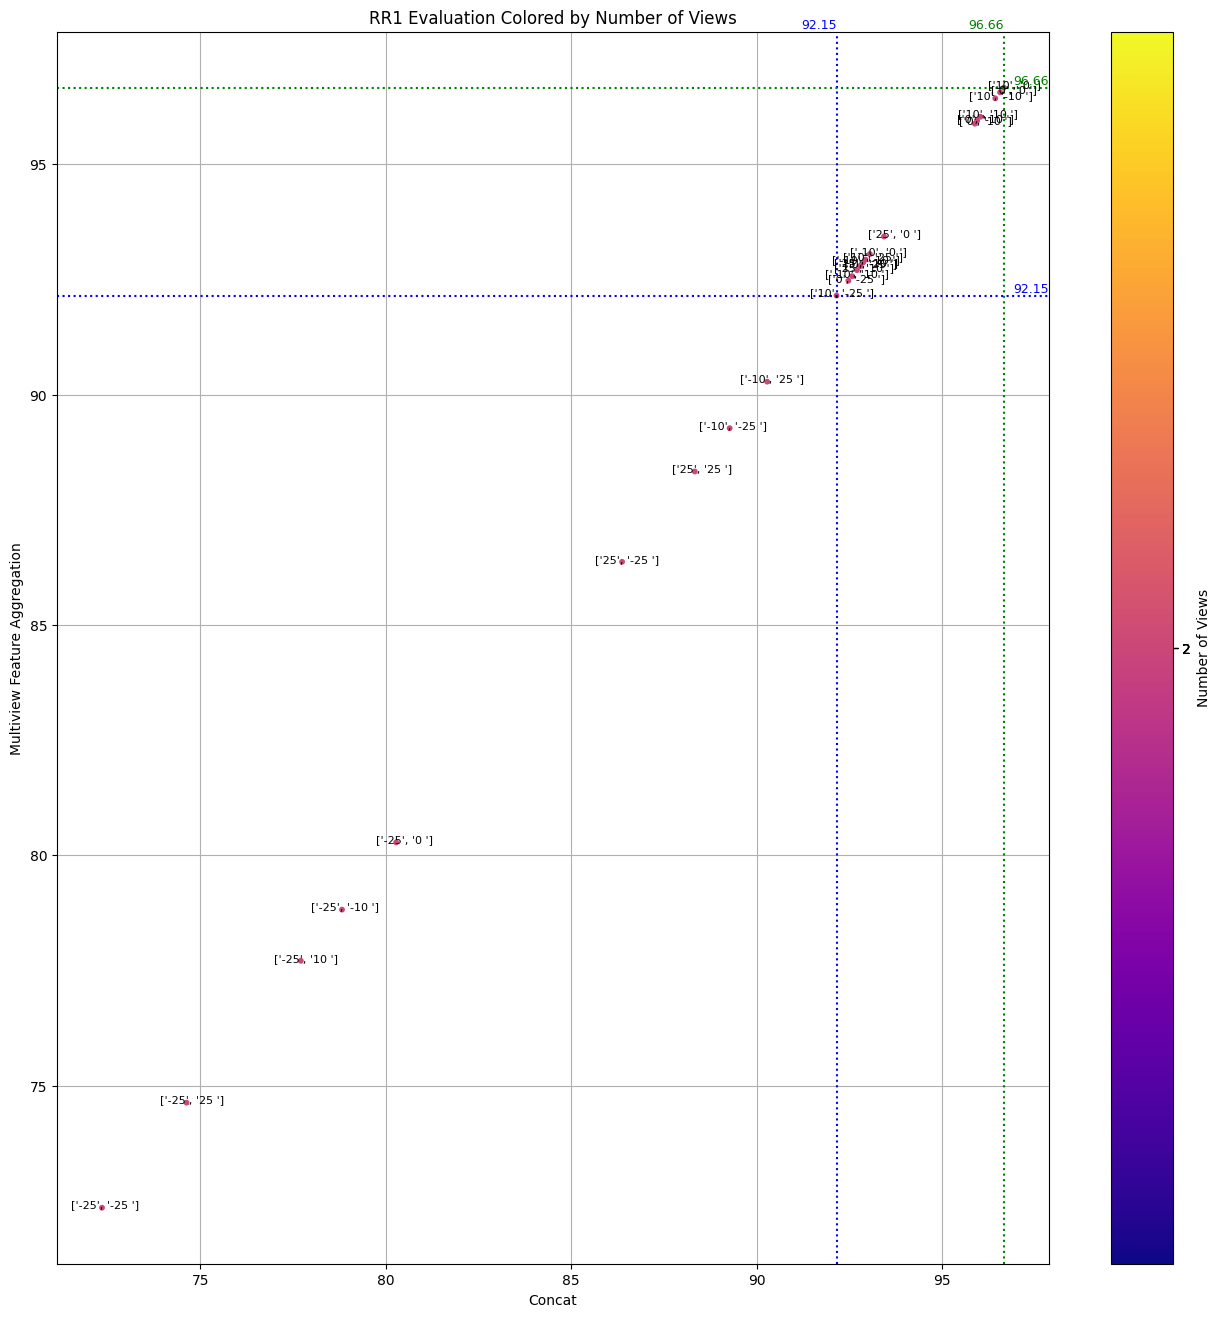

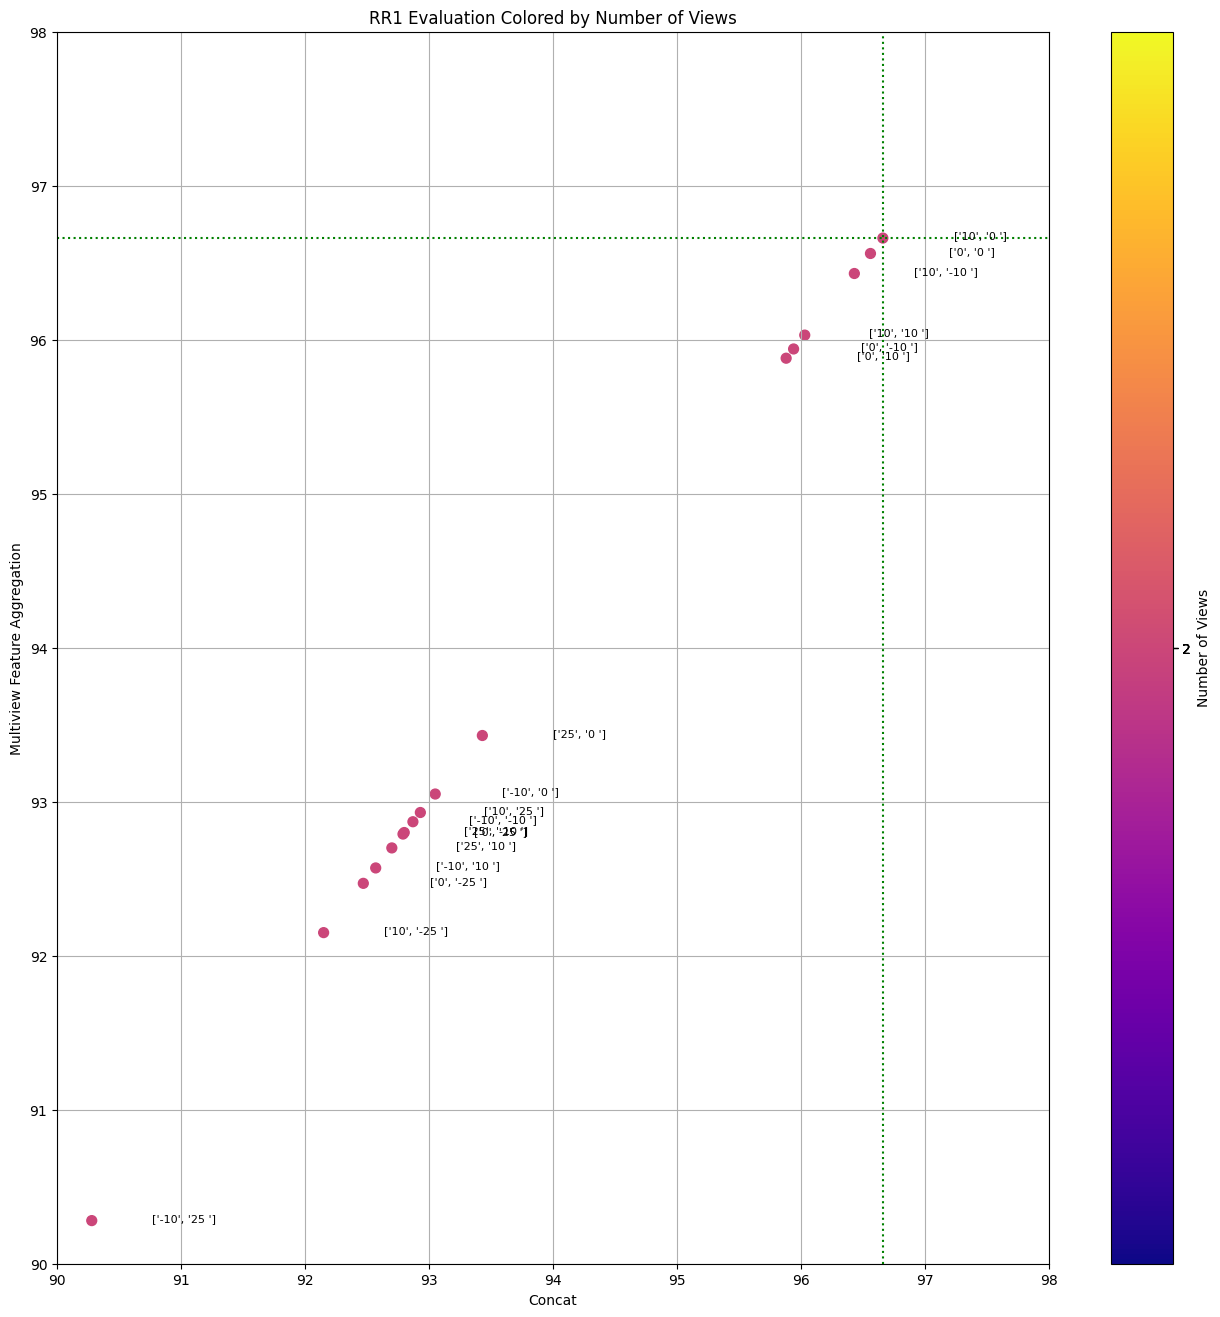

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np


extras_sets = [set(group) for group in extras]
special_views = sorted(set(v for group in extras for v in group))

def is_extra(coords):
    return any(set(coords) == extra for extra in extras_sets)

def clean_ansi(text):
    ansi_codes = ['\x1b[92m', '\x1b[0m', '\x1b[1m', '\x1b[4m']
    for code in ansi_codes:
        text = text.replace(code, '')
    return text

def get_extra_label(coords):
    for i, extra_set in enumerate(extras_sets):
        if set(coords) == extra_set:
            return extras_labels[i]
    return "Unknown Extra Pattern"

def process_and_plot3(file_path, xlim, ylim):

    with open(file_path, 'r') as file:
        data = file.readlines()

    results = []
    for line in data:
        line = clean_ansi(line).strip()
        if "Front-RR1:" in line:
            line = line.strip()
            dataset_part, eval_part = line.split("E1033Q18734:")

            # Parse crop coordinates
            coords_strs = dataset_part.split("_")[-2:]

            parts = eval_part.split()
            front_rr1 = float(parts[1])
            concat_rr1 = float(parts[5])
            mv_rr1 = float(parts[17])

            results.append((coords_strs , front_rr1, concat_rr1, mv_rr1))

    print(f"Dataset len:", len(results))
    print(results)

    coords_strs = [r[0] for r in results]
    front_rr1_values = [r[1] for r in results]
    concat_rr1_values = [r[2] for r in results]
    mv_rr1_values = [r[3] for r in results]


    print("---- Extras Only ----")
    for coords, front_rr1, concat_rr1, mv_rr1 in results:
        if is_extra(coords):
            label = get_extra_label(coords)
            print(f"{label} | Views: {coords}")
            print(f"  Front RR1: {front_rr1:.2f}")
            print(f"  Concat RR1: {concat_rr1:.2f}")
            print(f"  MV RR1: {mv_rr1:.2f}")
            print()

    # ----------------Scatter ---------------
    lengths = [len(c) for c in coords_strs]
    min_len, max_len = min(lengths), max(lengths)
    norm = mcolors.Normalize(vmin=min_len, vmax=max_len)
    cmap = cm.plasma

    fig, ax = plt.subplots(figsize=(16, 16))
    #scatter = ax.scatter(concat_rr1_values, mv_rr1_values, c=lengths, cmap=cmap, norm=norm, s=10)
    colors = [lengths[i] for i in range(len(coords_strs))]
    is_extras = [is_extra(coords_strs[i]) for i in range(len(coords_strs))]

    scatter = ax.scatter(
        [concat_rr1_values[i] for i in range(len(coords_strs)) if not is_extras[i]],
        [mv_rr1_values[i] for i in range(len(coords_strs)) if not is_extras[i]],
        c=[colors[i] for i in range(len(coords_strs)) if not is_extras[i]],
        cmap=cmap, norm=norm, s=10, label="Regular Samples"
    )
    scatter_extras = ax.scatter(
        [concat_rr1_values[i] for i in range(len(coords_strs)) if is_extras[i]],
        [mv_rr1_values[i] for i in range(len(coords_strs)) if is_extras[i]],
        c=[colors[i] for i in range(len(coords_strs)) if is_extras[i]],
        edgecolors='black', marker='*', s=100, label="Extras"
    )

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Number of Views')
    tick_values = np.linspace(min_len, max_len, num=5, dtype=int)
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels([str(v) for v in tick_values])
    for i, txt in enumerate(coords_strs):
        print(txt)
        ax.annotate(txt, (concat_rr1_values[i]+1.0, mv_rr1_values[i]-0.005), fontsize=8, ha='right')
    ax.set_xlabel('Concat')
    val1 = front_rr1_values[0]
    val2 = max(concat_rr1_values)
    val3 = max(mv_rr1_values)
    ax.axvline(val1, color='b', ls=':')
    ax.axhline(val1, color='b', ls=':')
    ax.text(val1, ax.get_ylim()[1], f'{val1:.2f}', color='b', va='bottom', ha='right', fontsize=9)
    ax.text(ax.get_xlim()[1], val1, f'{val1:.2f}', color='b', va='bottom', ha='right', fontsize=9)
    ax.axvline(val2, color='g', ls=':')
    ax.axhline(val3, color='g', ls=':')
    ax.text(val2, ax.get_ylim()[1], f'{val2:.2f}', color='g', va='bottom', ha='right', fontsize=9)
    ax.text(ax.get_xlim()[1], val3, f'{val3:.2f}', color='g', va='bottom', ha='right', fontsize=9)
    ax.set_ylabel('Multiview Feature Aggregation')
    ax.set_title('RR1 Evaluation Colored by Number of Views')
    plt.grid(True)
    plt.show()

    # ------------- Zoomed in scatter ------------------
    lengths = [len(c) for c in coords_strs]
    min_len, max_len = min(lengths), max(lengths)
    norm = mcolors.Normalize(vmin=min_len, vmax=max_len)
    cmap = cm.plasma

    fig, ax = plt.subplots(figsize=(16, 16))
    scatter = ax.scatter(
        [concat_rr1_values[i] for i in range(len(coords_strs)) if not is_extras[i]],
        [mv_rr1_values[i] for i in range(len(coords_strs)) if not is_extras[i]],
        c=[colors[i] for i in range(len(coords_strs)) if not is_extras[i]],
        cmap=cmap, norm=norm, s=50, label="Regular Samples"
    )
    scatter_extras = ax.scatter(
        [concat_rr1_values[i] for i in range(len(coords_strs)) if is_extras[i]],
        [mv_rr1_values[i] for i in range(len(coords_strs)) if is_extras[i]],
        c=[colors[i] for i in range(len(coords_strs)) if is_extras[i]],
        edgecolors='black', marker='*', s=150, label="Extras"
    )

    
    for i, extra_group in enumerate(extras_sets):
        label = extras_labels.get(i, f"Extras {i}")
        for j, coords in enumerate(coords_strs):
            if set(coords) == extra_group:
                x = concat_rr1_values[j]
                y = mv_rr1_values[j]
                ax.annotate(label, (x, y), fontsize=8, ha='left', va='bottom', color='black',
                            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
                break
            
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Number of Views')
    tick_values = np.linspace(min_len, max_len, num=5, dtype=int)
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels([str(v) for v in tick_values])
    for i, txt in enumerate(coords_strs):
        ax.annotate((txt), (concat_rr1_values[i]+1.0, mv_rr1_values[i]-0.005), fontsize=8, ha='right')
    ax.axvline(val2, color='g', ls=':')
    ax.axhline(val3, color='g', ls=':')
    ax.set_xlabel('Concat')
    ax.set_ylabel('Multiview Feature Aggregation')
    ax.set_title('RR1 Evaluation Colored by Number of Views')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.grid(True)
    plt.show()

process_and_plot3('198_masseval_singleviews.txt', xlim=(90, 98), ylim=(90, 98))